In [1]:
# ============================================================
# Cell (GATEv2 Defaults): Embedded configuration (NO env vars)
# ------------------------------------------------------------
# CHANGELOG (2026-01-04):
# - Embedded Stage-2 Gate v2 (segment_priority) knobs directly in the notebook.
# - The notebook now sets required values internally so you don't need to export env vars.
#   (Avoids accidental resets / missing exports.)
# ============================================================

import os

# --- Gate v2 knobs (EDIT HERE) ---
GATEV2 = {
    'STAGE2_SELECT_MODE': 'segment_priority',
    'STAGE2_SEG_ONLY_BENIGN': '1',
    'STAGE2_SEG_OPTIONAL': '0',
    'STAGE2_SEG_MIN_P1': '0.20',
    'STAGE2_TAU': '0.60',
    'STAGE2_MAX_BUDGET': '0',
}

# Apply to process environment *inside* this notebook.
for k, v in GATEV2.items():
    os.environ[k] = str(v)

print('[GATEv2] Using embedded knobs (no external env required):')
for k in sorted(GATEV2.keys()):
    print(f'  {k}={os.environ.get(k)}')


[GATEv2] Using embedded knobs (no external env required):
  STAGE2_MAX_BUDGET=0
  STAGE2_SEG_MIN_P1=0.20
  STAGE2_SEG_ONLY_BENIGN=1
  STAGE2_SEG_OPTIONAL=0
  STAGE2_SELECT_MODE=segment_priority
  STAGE2_TAU=0.60


In [2]:
import os

# ============================================================
# Cell 0 (PATCH): Experiment knobs / safe defaults
# ------------------------------------------------------------
# CHANGELOG (2026-01-01):
# - Added env var defaults for Stage-2 selection (threshold_cap, NO-TOPK default),
#   cap control (STAGE2_MAX_BUDGET=0 disables cap), and early-stopping val split.
# - Added: optional TEST-only class-imbalance evaluation knobs (EVAL_IMBALANCE, EVAL_POS_RATE, etc.).
# - Uses os.environ.setdefault(...) so external env can override.
# ============================================================

# ---- Visualization knobs ----
os.environ.setdefault("VIZ_MAX_K", "40000")
os.environ.setdefault("VIZ_K_STEP", "500")
os.environ.setdefault("VIZ_FN_COST", "3.0")

# ---- (NEW) Evaluation-only imbalance knobs (TEST-ONLY) ----
# Simulate real-world rarity of phishing by downsampling positives in the TEST split only.
# Training split remains unchanged.
os.environ.setdefault("EVAL_IMBALANCE", "0")      # 0=off, 1=enable TEST-only downsampling
os.environ.setdefault("EVAL_POS_RATE", "0.001")   # target positive rate (e.g., 0.001 = 0.1%)
os.environ.setdefault("EVAL_MIN_POS", "200")      # keep at least this many positives (stability)
os.environ.setdefault("EVAL_SEED", "42")          # RNG seed for reproducibility

# ---- Stage-1 / training split ----
os.environ.setdefault("XGB_VAL_SIZE", "0.10")  # val fraction within train(80%) for early stopping

# ---- Stage-2 (LR defer gate) defaults ----
os.environ.setdefault("STAGE2_SELECT_MODE", "segment_priority")  # segment-first gate v2  # topk is intentionally discouraged
os.environ.setdefault("STAGE2_MAX_BUDGET", "0")              # 0 => cap disabled (variable handoff size)
os.environ.setdefault("STAGE2_TAU", "0.60")                  # gray threshold (raise to shrink handoff)                  # gray threshold (raise to shrink handoff)
os.environ.setdefault("STAGE2_OVERRIDE_TAU", "0.60")         # rescue confident-mistake threshold
os.environ.setdefault("STAGE2_PHI_PHISH", "0.99")            # clear-phish extreme
os.environ.setdefault("STAGE2_PHI_BENIGN", "0.01")           # clear-benign extreme

# ---- Gate v2 (segment_priority) knobs ----
os.environ.setdefault("STAGE2_SEG_ONLY_BENIGN", "1")   # safe default: only rescue benign-side errors
os.environ.setdefault("STAGE2_SEG_OPTIONAL", "0")      # 0: priority only (dangerous/idn/brand); 1: include unknown optional pool
os.environ.setdefault("STAGE2_SEG_INCLUDE_IDN", "1")
os.environ.setdefault("STAGE2_SEG_INCLUDE_BRAND", "0") # requires brand list availability
os.environ.setdefault("STAGE2_SEG_MIN_P1", "0.20")       # ignore ultra-low ML in segment gate (aligns with "low-ML rescue is hard")
os.environ.setdefault("STAGE2_SEG_TAU_PRIORITY", "")   # empty => use STAGE2_TAU
os.environ.setdefault("STAGE2_SEG_TAU_OPTIONAL", "")   # empty => use STAGE2_TAU
os.environ.setdefault("STAGE2_OOF_FOLDS", "5")
os.environ.setdefault("STAGE2_CERT_EXTRA", "1")              # keep cert_data-derived extras enabled

# Optional: Stage-1 triage thresholds (leave as-is unless you intentionally tune)
# os.environ.setdefault("XGB_T_LOW", "0.001")
# os.environ.setdefault("XGB_T_HIGH", "0.999")

_mode = (os.environ.get("STAGE2_SELECT_MODE") or "").strip().lower()
if _mode in ("topk", "top_k", "top-k"):
    raise RuntimeError(
        "STAGE2_SELECT_MODE=topk is disabled in this notebook variant. "
        "Use STAGE2_SELECT_MODE=threshold_cap (legacy) or segment_priority (recommended gate v2)."
    )

print("⚙️  Experiment knobs:")
print(f"  - XGB_VAL_SIZE={os.environ.get('XGB_VAL_SIZE')}")
print(f"  - STAGE2_SELECT_MODE={os.environ.get('STAGE2_SELECT_MODE')}")
print(f"  - STAGE2_MAX_BUDGET={os.environ.get('STAGE2_MAX_BUDGET')} (0 disables cap)")
print(f"  - STAGE2_TAU={os.environ.get('STAGE2_TAU')} | OVERRIDE_TAU={os.environ.get('STAGE2_OVERRIDE_TAU')}")
print(f"  - PHI_PHISH={os.environ.get('STAGE2_PHI_PHISH')} | PHI_BENIGN={os.environ.get('STAGE2_PHI_BENIGN')}")
print(f"  - EVAL_IMBALANCE={os.environ.get('EVAL_IMBALANCE')} | EVAL_POS_RATE={os.environ.get('EVAL_POS_RATE')} | EVAL_MIN_POS={os.environ.get('EVAL_MIN_POS')} | EVAL_SEED={os.environ.get('EVAL_SEED')}")


⚙️  Experiment knobs:
  - XGB_VAL_SIZE=0.10
  - STAGE2_SELECT_MODE=segment_priority
  - STAGE2_MAX_BUDGET=0 (0 disables cap)
  - STAGE2_TAU=0.60 | OVERRIDE_TAU=0.60
  - PHI_PHISH=0.99 | PHI_BENIGN=0.01
  - EVAL_IMBALANCE=0 | EVAL_POS_RATE=0.001 | EVAL_MIN_POS=200 | EVAL_SEED=42


In [3]:
# === Cell 0 (02以降 共通): レジストリから解決して paths を読む ===
import run_id_registry as runreg
rid = runreg.bootstrap()  # env→ファイル(artifacts/_current/run_id.txt)→Part3→latest→新規 の順で解決

import importlib
import _compat.paths as paths
importlib.reload(paths)
importlib.reload(paths)
print("[NX] RUN_ID =", rid, "| paths.RUN_ID =", paths.RUN_ID)


[NX] RUN_ID = 2026-01-05_014726 | paths.RUN_ID = 2026-01-05_014726


In [4]:
# --- Cell 0: Bootstrap (run first) ---
from pathlib import Path
import sys, json

# Ensure project root is on sys.path so that "_compat" is importable
sys.path.insert(0, str(Path.cwd()))

# Import utilities from nextstep/_compat/
from _compat.paths import ensure_roots, compat_base_dirs  # paths.py 内の関数/定数

# Create artifacts/<RUN_ID>/... tree
ensure_roots()

# Read your project config (under nextstep/_compat/config.json)
CONFIG = Path("_compat") / "config.json"
with open(CONFIG, "r", encoding="utf-8") as f:
    cfg = json.load(f)

print("CONFIG:", CONFIG.resolve())
print("ARTIFACTS ROOT:", compat_base_dirs.get("root_dir"))

CONFIG: /data/hdd/asomura/nextstep/_compat/config.json
ARTIFACTS ROOT: None


In [5]:
# --- Cell 1: LLM config guard (cfg/env/default の順) ---
import os

llm = cfg.setdefault("llm", {})
# [patched] llm.setdefault("base_url", os.getenv("VLLM_BASE_URL") or llm.get("base_url") or "http://192.168.100.71:30000/v1")
llm.setdefault("model",    os.getenv("BRAND_LLM_MODEL") or llm.get("model") or "Qwen/Qwen3-14B-FP8")
llm.setdefault("api_key",  os.getenv("VLLM_API_KEY") or llm.get("api_key") or "EMPTY")

print("LLM base_url:", llm["base_url"])
print("LLM model   :", llm["model"])

LLM base_url: http://localhost:8000/v1
LLM model   : JunHowie/Qwen3-4B-Thinking-2507-GPTQ-Int8


In [6]:
# --- Cell 2: Brand keywords limits from config.json ---
bk = cfg.setdefault("brand_keywords", {})
MIN_COUNT  = int(bk.get("min_count", 2))
MAX_BRANDS = int(bk.get("max_brands", 20))   # ← config.json で 100 を想定
DYNAMIC    = bool(bk.get("dynamic_extraction", True))
DEFAULTS   = list(bk.get("default_list", []))

print("Brand min_count:", MIN_COUNT, " max_brands:", MAX_BRANDS, " dynamic:", DYNAMIC)

Brand min_count: 2  max_brands: 100  dynamic: True


In [7]:
#!/usr/bin/env python
# coding: utf-8

In [8]:


# === IO PATHS (auto-added guard) ===
import os
from pathlib import Path
from datetime import datetime

if 'RUN_ID' not in globals():
    RUN_ID = os.environ.get("RUN_ID") or datetime.now().strftime("%Y-%m-%d_%H%M%S")
ARTIFACTS = Path("artifacts") / RUN_ID
RAW = ARTIFACTS / "raw"; PROCESSED = ARTIFACTS / "processed"; MODELS = ARTIFACTS / "models"
RESULTS = ARTIFACTS / "results"; HANDOFF = ARTIFACTS / "handoff"; LOGS = ARTIFACTS / "logs"; TRACES = ARTIFACTS / "traces"
for _p in [RAW, PROCESSED, MODELS, RESULTS, HANDOFF, LOGS, TRACES]:
    _p.mkdir(parents=True, exist_ok=True)

RAW_DIR = str(RAW); PROCESSED_DIR = str(PROCESSED); MODELS_DIR = str(MODELS)
RESULTS_DIR = str(RESULTS); HANDOFF_DIR = str(HANDOFF); LOGS_DIR = str(LOGS); TRACES_DIR = str(TRACES)

base_dirs = {
    'raw': RAW_DIR, 'data': PROCESSED_DIR, 'models': MODELS_DIR,
    'results': RESULTS_DIR, 'handoff': HANDOFF_DIR, 'logs': LOGS_DIR, 'traces': TRACES_DIR,
}
def resolve(p): p = Path(p); p.mkdir(parents=True, exist_ok=True); return str(p)
def ensure_roots(): pass
def load_config(): return {"root": str(ARTIFACTS), "run_id": RUN_ID}
print(f"✅ IO guard ready -> artifacts/{RUN_ID}")

✅ IO guard ready -> artifacts/2026-01-05_014726


In [9]:
# === IO PATHS override: base_dirs を artifacts/<RUN_ID> 直下に統一 ===
from pathlib import Path as _Path

# セッションIDはパイプライン全体の RUN_ID に揃える
session_id = RUN_ID

base_dirs = {
    "models": str(_Path(MODELS_DIR)),
    "results": str(_Path(RESULTS_DIR)),
    "data": str(_Path(PROCESSED_DIR)),
}

for _dir in base_dirs.values():
    _Path(_dir).mkdir(parents=True, exist_ok=True)

print("[IO] base_dirs unified to artifacts/<RUN_ID> root:")
for _k, _v in base_dirs.items():
    print(f"  - {_k}: {_v}")

[IO] base_dirs unified to artifacts/<RUN_ID> root:
  - models: artifacts/2026-01-05_014726/models
  - results: artifacts/2026-01-05_014726/results
  - data: artifacts/2026-01-05_014726/processed


In [10]:
# --- preflight: cfg.llm を必ず埋める（assert_llm_available が参照） ---
cfg = globals().get("cfg", {}) or {}
if not isinstance(cfg, dict):
    cfg = {}
llm = cfg.setdefault("llm", {})
llm.setdefault("enabled", True)

# セル内のローカル値を cfg に反映（不足分のみ）
if not llm.get("base_url"):
    llm["base_url"] = (os.getenv("VLLM_BASE_URL") or llm.get("base_url") or "http://192.168.100.71:30000/v1")
if not llm.get("model"):
    llm["model"] = (os.getenv("BRAND_LLM_MODEL") or llm.get("model") or "Qwen/Qwen3-14B-FP8")
    

# 予防的に環境変数も埋めておく（どちら経路でも動くように）
import os
os.environ.setdefault("VLLM_BASE_URL", llm["base_url"])
os.environ.setdefault("BRAND_LLM_MODEL", llm["model"])
#os.environ.setdefault("BRAND_LLM_MODEL", llm["model"])

'JunHowie/Qwen3-4B-Thinking-2507-GPTQ-Int8'

In [11]:


# ---- RUN_ID を一度だけ決めて固定（同一ノート実行でブレない）----
import os
from datetime import datetime

if "RUN_ID" not in globals():
    RUN_ID = os.environ.get("RUN_ID") or datetime.now().strftime("%Y-%m-%d_%H%M%S")
    os.environ["RUN_ID"] = RUN_ID  # 同一カーネル共有したいなら残す

# 既存のbase_dirsの流儀はそのまま（＝機能不変）
# base_dirs['results'] = f"results/{RUN_ID}"  # artifacts配下に統一するため旧仕様を無効化

# 任意（見る用）
print("RUN_ID:", RUN_ID)
print("base_dirs['results']:", base_dirs['results'])

RUN_ID: 2026-01-05_014726
base_dirs['results']: artifacts/2026-01-05_014726/results


In [12]:


# ---- Notebook-local open shim: write-mode open() goes through resolve() ----
import os
import builtins
from _compat.paths import resolve  # これが存在しない環境なら B) を使ってください

_builtin_open = builtins.open  # 本物を退避

def open(path, *args, **kwargs):
    # 文字列/PathLike のときだけ処理
    if isinstance(path, (str, bytes, os.PathLike)):
        # モード取得（args優先）
        mode = args[0] if (args and isinstance(args[0], str)) else kwargs.get('mode', 'r')
        # 書き込み系モードのときだけ resolve を通す
        if any(ch in mode for ch in ('w', 'a', 'x', '+')):
            try:
                path = resolve(path)  # 必要なら親ディレクトリ作成などを含む
            except Exception:
                # resolve 失敗時は元の path のまま
                pass
    return _builtin_open(path, *args, **kwargs)

print("open shim active -> write-mode open() goes through resolve()")

open shim active -> write-mode open() goes through resolve()


In [13]:
"""
セル番号: 11 (修正版)
概要: ライブラリのインポートとデータ読み込み
修正点: 過去のID指定をやめ、現在のRUN_IDのフォルダからデータを読み込むように変更
"""

import os
import pickle
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ML関連ライブラリ
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, roc_curve
)
from sklearn.inspection import permutation_importance
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from cryptography import x509
from cryptography.hazmat.backends import default_backend

# DB設定
DB_CONFIG = {
    'dbname': 'rapids_data',
    'user': 'postgres',
    'password': 'asomura',
    'host': 'localhost',
    'port': '5432'
}

# GPU確認
try:
    import subprocess
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
    gpu_available = result.returncode == 0
    print("✅ GPU使用可能" if gpu_available else "❌ GPU使用不可 - CPUで実行します")
except:
    gpu_available = False
    print("❌ GPU使用不可 - CPUで実行します")

# ------------------------------------------------------------------
# 入出力設定 (すべて現在の RUN_ID を使用)
# ------------------------------------------------------------------

# 現在の実行ID (例: 2025-12-07_143907)
session_id = RUN_ID

# 出力先ディレクトリ作成
base_dirs = {
    'models': str(Path(MODELS_DIR)),
    'results': str(Path(RESULTS_DIR)),
    'data': str(Path(PROCESSED_DIR)),
}
for dir_path in base_dirs.values():
    Path(dir_path).mkdir(parents=True, exist_ok=True)

print(f"🆔 今回のセッションID: {session_id}")
print(f"📁 出力先: artifacts/{session_id}/")

# ------------------------------------------------------------------
# データの読み込み
# 今回生成されたデータ (artifacts/<RUN_ID>/raw/prepared_data.pkl) を読み込みます
# ------------------------------------------------------------------

artifacts_root = Path("artifacts")
# ★修正: SOURCE_RUN_ID を使わず、現在の session_id (RUN_ID) をそのまま使います
data_path = artifacts_root / session_id / "raw" / "prepared_data.pkl"

print(f"📂 読み込み対象 RUN_ID: {session_id} (現在)")
print(f"📄 パス: {data_path}")

if not data_path.exists():
    raise FileNotFoundError(f"データファイルが見つかりません。\nパス: {data_path}\n※01_data_preparation.py がこのRUN_IDで実行済みか確認してください。")

# 読み込み実行
print("\n💾 データ読み込み中...")
with open(data_path, 'rb') as f:
    prepared_data = pickle.load(f)

phishing_df = prepared_data['phishing_data']
trusted_df = prepared_data['trusted_data']
metadata = prepared_data['metadata']

print("✅ データ読み込み完了")

# サマリー表示
print("\n" + "=" * 80)
print("📊 読み込みデータサマリー")
print("=" * 80)
print(f"\n🆔 作成元 RUN_ID: {metadata.get('session_id', 'Unknown')}")
print(f"📅 作成日時: {metadata.get('created_at', 'Unknown')}")
print(f"\n📈 データ件数:")
print(f"├─ フィッシング: {len(phishing_df):,}件")
print(f"└─ 正常: {len(trusted_df):,}件")

if 'source_distribution' in metadata and 'phishing' in metadata['source_distribution']:
    print(f"\n📍 ソース別内訳:")
    for source, count in metadata['source_distribution']['phishing'].items():
        print(f"  - {source}: {count:,}件")

print("\n✅ セットアップ完了")
print("=" * 80)

✅ GPU使用可能
🆔 今回のセッションID: 2026-01-05_014726
📁 出力先: artifacts/2026-01-05_014726/
📂 読み込み対象 RUN_ID: 2026-01-05_014726 (現在)
📄 パス: artifacts/2026-01-05_014726/raw/prepared_data.pkl

💾 データ読み込み中...
✅ データ読み込み完了

📊 読み込みデータサマリー

🆔 作成元 RUN_ID: 2026-01-05_014726
📅 作成日時: 2026-01-05T01:51:09.724513

📈 データ件数:
├─ フィッシング: 320,166件
└─ 正常: 320,166件

✅ セットアップ完了


In [14]:
# 旧:
# MAX_BRANDS = int(os.getenv("BRAND_MAX_ITEMS", "20"))

# 新（cfgがあればそちらを優先、なければ環境変数、最後に20）:
_cfg_val = (cfg.get("brand_keywords", {}).get("max_brands")
            if "cfg" in globals() and isinstance(cfg, dict) else None)
_env_val = os.getenv("BRAND_MAX_ITEMS")
MAX_BRANDS = int(_cfg_val or _env_val or 20)

In [15]:
# === Cell 1.5 (FINAL FIX): Dynamic Brand Keywords via Qwen3-14B-FP8 (vLLM/OpenAI SDK compat) ===
# Purpose: Extract real phishing target brands from DB text and provide BRAND_KEYWORDS to subsequent cells.
# Inputs : DB_CONFIG (host, port, dbname, user, password)
# Output : BRAND_KEYWORDS (list[str])  ← same I/O as original (no file writes)

import os, re, json, time, sys
import psycopg2
from collections import Counter
from dotenv import load_dotenv, find_dotenv
from openai import OpenAI

# --- .env ---
_ = load_dotenv(find_dotenv(usecwd=True) or ".env")

# === vLLM helpers (OpenAI SDK compatible) ===
def get_llm_client(cfg=None):
    """Create OpenAI-compatible client for vLLM using cfg/env/defaults."""
    import os
    try:
        from openai import OpenAI
    except Exception as e:
        raise ImportError("openai package is required. Try: pip install 'openai>=1.48.0'") from e
    llm = ((cfg or {}).get("llm", {}) or {})
    base_url = llm.get("base_url") or os.getenv("VLLM_BASE_URL") or "http://192.168.100.71:30000/v1"
    api_key  = llm.get("api_key")  or os.getenv("OPENAI_API_KEY") or os.getenv("VLLM_API_KEY") or "EMPTY"
    return OpenAI(base_url=base_url, api_key=api_key)

def get_llm_model(cfg=None):
    return ((cfg or {}).get("llm", {}) or {}).get("model") or os.getenv("BRAND_LLM_MODEL") or "Qwen/Qwen3-14B-FP8"

def assert_llm_available(cfg=None):
    """Strict check: required values + actual connectivity (fail fast)."""
    import os
    llm = ((cfg or {}).get("llm", {}) or {})
    base_url = llm.get("base_url") or os.getenv("VLLM_BASE_URL") or "http://192.168.100.71:30000/v1"
    model    = llm.get("model")    or os.getenv("BRAND_LLM_MODEL") or "Qwen/Qwen3-14B-FP8"
    assert isinstance(base_url, str) and base_url.strip(), "LLM base_url is missing."
    assert isinstance(model, str) and model.strip(), "LLM model is missing."
    # NEW: connectivity test (fail fast)
    try:
        _client = get_llm_client(cfg)
        _ = _client.chat.completions.create(
            model=model,
            messages=[{"role": "user", "content": "ping"}],
            max_tokens=1,
            temperature=0.0,
        )
    except Exception as e:
        raise ConnectionError(
            f"LLM接続/初期化に失敗しました (base_url={base_url}, model={model}). "
            "vLLMサーバーの起動状態と .env の VLLM_BASE_URL/BRAND_LLM_MODEL を確認してください。"
        ) from e

# --- Strict LLM init (fail fast) ---
_cfg = cfg if "cfg" in globals() else None
assert_llm_available(_cfg)
client = get_llm_client(_cfg)
DEFAULT_MODEL = get_llm_model(_cfg)

def normalize_brand_name(name: str):
    if not name:
        return None
    s = name.lower().replace("&amp;", "&")
    s = re.sub(r"[^a-z0-9\-&]", "", s)
    return s or None


# ------------------------------------------------------------------------------------
# [CHANGELOG 2025-12-28]
# - vLLM v0.12.0 で `guided_json` が非推奨/削除予定のため、OpenAI互換APIの extra_body を使い
#   `structured_outputs: {"json": <JSON Schema>}` で Structured Output を強制するように変更。
# - JSONの崩れ（True/False, シングルクォート, 余計なテキスト）を吸収するためのパーサを追加。
# - LLMが例を写して 'canonicalname' を返す事故をガード。
#   ※対象は Cell 1.5 のブランド判定のみ。I/Oや後続セルは変更しない。
# ------------------------------------------------------------------------------------

import ast as _ast

# --- Structured Output schemas (vLLM OpenAI-Compatible Server: extra_body["structured_outputs"]["json"]) ---
BRAND_VALIDATION_SCHEMA = {
    "title": "brand_validation",
    "type": "object",
    "additionalProperties": False,
    "properties": {
        "valid": {"type": "boolean", "description": "True if token is a brand/company/organization name."},
        "canon": {
            "type": "string",
            "description": "Canonical token in lowercase ASCII, no spaces, only [a-z0-9&-].",
        },
    },
    "required": ["valid", "canon"],
}

BATCH_VALIDATION_SCHEMA = {
    "title": "brand_validation_batch",
    "type": "object",
    "additionalProperties": False,
    "properties": {
        "results": {
            "type": "array",
            "items": {
                "type": "object",
                "additionalProperties": False,
                "properties": {
                    "index": {"type": "integer"},
                    "input": {"type": "string"},
                    "valid": {"type": "boolean"},
                    "canon": {"type": "string"},
                },
                "required": ["index", "input", "valid", "canon"],
            },
        }
    },
    "required": ["results"],
}

_CANON_PLACEHOLDER = {"canonicalname", "canonical_name", "canon", "brand", "company", "organization"}

def _safe_parse_json_or_python(content: str):
    """Parse JSON (preferred) or Python-literal dict/list as a fallback."""
    if not content:
        return {}
    s = content.strip()

    # 1) Strict JSON
    try:
        return json.loads(s)
    except Exception:
        pass

    # 2) Extract first JSON-looking object/array and try JSON again
    try:
        m = re.search(r"(\{.*\}|\[.*\])", s, flags=re.DOTALL)
        if m:
            return json.loads(m.group(1))
    except Exception:
        pass

    # 3) Python literal (e.g., {'valid': True, 'canon': 'microsoft'})
    try:
        return _ast.literal_eval(s)
    except Exception:
        pass

    # 4) Extract then python literal
    try:
        m = re.search(r"(\{.*\}|\[.*\])", s, flags=re.DOTALL)
        if m:
            return _ast.literal_eval(m.group(1))
    except Exception:
        pass

    return {}

# --- Fetch data from DB (same tables as original) ---
print("\n🔌 データベースに接続中...")
conn = psycopg2.connect(**DB_CONFIG)  # 失敗時は例外（=停止）
cur  = conn.cursor()
print("✅ データベース接続成功")

print("\n📊 phishtank_entries からターゲットを取得...")
cur.execute("""
    SELECT target, COUNT(*) as count
    FROM public.phishtank_entries
    WHERE target IS NOT NULL AND target <> 'Other'
    GROUP BY target
    HAVING COUNT(*) >= 1
    ORDER BY count DESC
    LIMIT 200
""")
phishtank_targets = cur.fetchall()
print(f"  ✅ {len(phishtank_targets)} 件")

print("\n📊 jpcert_phishing_urls から説明文を取得...")
cur.execute("""
    SELECT DISTINCT description
    FROM public.jpcert_phishing_urls
    WHERE description IS NOT NULL
      AND description <> ''
      AND description <> '-'
    LIMIT 200
""")
jpcert_descriptions = [r[0] for r in cur.fetchall()]
print(f"  ✅ {len(jpcert_descriptions)} 件")

cur.close(); conn.close()

# --- Build compact corpus for context helper (not sent as a whole) ---
def _shorten(s, n):
    s = (s or "").strip().replace("\n", " ")
    return (s[:n] + "…") if len(s) > n else s

lines = []
for tgt, cnt in phishtank_targets:
    lines.append(f"- PT target: {_shorten(str(tgt), 90)} (count={cnt})")
for d in jpcert_descriptions:
    lines.append(f"- JP desc: {_shorten(d, 120)}")

# --- MAX_BRANDS & BATCH_SIZE: config/env > default ---
def _load_cfg_for_max_brands():
    # 既存の cfg があれば最優先
    if "cfg" in globals() and isinstance(cfg, dict):
        return cfg
    # _compat 経由の読込を試みる
    try:
        from _compat.paths import ensure_roots, load_config
        ensure_roots()
        return load_config()  # CONFIG_PATH or ./config.json / _compat側の探索に依存
    except Exception:
        pass
    # 直読みのフォールバック（CWD / _compat）
    import json as _json
    from pathlib import Path as _Path
    for cand in ("config.json", "_compat/config.json"):
        if _Path(cand).exists():
            return _json.loads(_Path(cand).read_text(encoding="utf-8"))
    raise RuntimeError("config.json が見つかりません（MAX_BRANDS 取得に失敗）")

try:
    _cfg_for_max = _load_cfg_for_max_brands()
    _cfg_val = (_cfg_for_max.get("brand_keywords", {}) or {}).get("max_brands")
    _cfg_batch = (_cfg_for_max.get("brand_keywords", {}) or {}).get("batch_size")
except Exception:
    _cfg_val = None
    _cfg_batch = None

_env_val = os.getenv("BRAND_MAX_ITEMS")
_env_batch = os.getenv("BRAND_BATCH_SIZE")

MAX_BRANDS = int(_cfg_val or _env_val or 20)
BATCH_SIZE = int(_cfg_batch or _env_batch or 5)
BATCH_SIZE = max(1, min(10, BATCH_SIZE))  # safety clamp (1..10)

# --- PROGRESS options ---
PROGRESS_MODE = (os.getenv("BRAND_PROGRESS") or "auto").lower()   # 'auto' | 'tqdm' | 'plain' | 'none'
_use_tqdm = False
_tqdm = None
if PROGRESS_MODE in ("auto", "tqdm"):
    try:
        from tqdm.auto import tqdm as _tqdm  # may not be installed
        _use_tqdm = True
    except Exception:
        _use_tqdm = False
if PROGRESS_MODE == "none":
    _use_tqdm = False

print(f"🔧 MAX_BRANDS (effective): {MAX_BRANDS}")
print(f"🔧 BATCH_SIZE (effective): {BATCH_SIZE}  ← 1リクエストあたりの同時判定数")
print(f"🟢 PROGRESS_MODE: {PROGRESS_MODE} ({'tqdm' if _use_tqdm else 'plain'})")
print("🚀 Batch mode enabled: 1 request ≈ up to", BATCH_SIZE, "brands")

# === 1brand→batch: 候補ごとに LLM で妥当性判定（最大BATCH_SIZE件/回） ===

# 1) DB候補（正規化＋頻度集計）
pt_counts = {}
for tgt, cnt in phishtank_targets:
    nt = normalize_brand_name(tgt)
    if nt:
        pt_counts[nt] = pt_counts.get(nt, 0) + int(cnt)

# 2) 候補に関係しそうな最小文脈（トークン節約）
def _ctx_for(cand: str, max_lines: int = 2) -> str:
    cand_lc = (cand or "").lower()
    hits = [d for d in jpcert_descriptions if cand_lc in (d or "").lower()][:max_lines]
    return "\n- ".join(hits) if hits else ""

# 3) 1件判定（フォールバック用・互換）
def _validate_one_brand(cand: str) -> tuple[bool, str]:
    """
    cand がブランド(企業/組織)かを判定し、正規化名 canon を返す。
    失敗時は False。LLM疎通はセル冒頭の assert_llm_available で保証済。
    """
    system = "You are a cybersecurity analyst. Output JSON only."
    ctx = _ctx_for(cand)
    user = (
        "Decide if the following token is a brand/company/organization name (not a generic word).\n"
        "If it is a brand, set valid=true and provide a canonical token in `canon`.\n"
        "- `canon` MUST be lowercase ASCII with no spaces, only [a-z0-9&-].\n"
        "- Do NOT return placeholder words like 'canonicalname'.\n"
        f'Token: "{cand}"'
    )

    if ctx:
        user += "\nContext:\n- " + ctx

    for _ in range(2):  # 軽いリトライ
        try:
            r = client.chat.completions.create(
                model=DEFAULT_MODEL,
                messages=[{"role":"system","content":system},{"role":"user","content":user}],
                temperature=0.0,
                max_tokens=64,
                extra_body={"structured_outputs": {"json": BRAND_VALIDATION_SCHEMA}},
            )
            content = (r.choices[0].message.content or "").strip()
            data = _safe_parse_json_or_python(content) or {}
            valid = bool(data.get("valid", False))

            canon_raw = str(data.get("canon", "") or "")
            canon = normalize_brand_name(canon_raw)

            # Guard: model sometimes copies prompt examples (e.g., "canonicalname")
            if canon in _CANON_PLACEHOLDER:
                canon = None

            # Fallback: canonicalize from input token (keeps I/O stable)
            if canon is None:
                canon = normalize_brand_name(cand)

            return (valid and bool(canon)), (canon or cand)
        except Exception:
            time.sleep(0.5)
    return False, cand


# 4) バッチ判定
def _validate_batch_brands(cands: list[str]) -> list[tuple[bool, str]]:
    """
    最大 BATCH_SIZE 件の候補をまとめて判定。
    戻り値: [(ok: bool, canon: str)]  ※入力順を維持。
    失敗時は、該当バッチのみ _validate_one_brand にフォールバック。
    """
    assert 1 <= len(cands) <= BATCH_SIZE
    system = "You are a cybersecurity analyst. Output JSON only."
    items = []
    for idx, cand in enumerate(cands):
        items.append({
            "index": idx,
            "token": cand,
            "context": _ctx_for(cand)
        })

    #user = (
    #    "For each item, decide if token is a brand/company/organization name (not a generic word). "
    #    "Treat items independently.\n"
    #    "Return JSON ONLY in the format: "
    #    "{\"results\":[{\"index\":<int>,\"input\":<token>,\"valid\":<bool>,\"canon\":<string>}]}.\n"
    #    "Rules for `canon`: lowercase ASCII, no spaces, only [a-z0-9&-]. "
    #    "Do NOT return placeholder words like 'canonicalname'.\n\n"
    #    "items:\n" + json.dumps(items, ensure_ascii=False)
    #)

    user = (
        "For each item, decide whether it is a brand/company/organization name (not a generic word). "
        "Treat items independently.\n"
        "Output MUST be a single JSON object and NOTHING else (no markdown, no code fences).\n"
        "The JSON must match exactly this shape:\n"
        "{\"results\":[{\"index\":0,\"input\":\"...\",\"valid\":true,\"canon\":\"...\"}, ...]}\n"
        "Requirements:\n"
        "- results length MUST equal the number of items.\n"
        "- Keep the same order as items. index MUST be 0..n-1.\n"
        "- input MUST be exactly the original item string.\n"
        "- valid MUST be JSON boolean: true or false (lowercase).\n"
        "- If valid is false, set canon to an empty string \"\".\n"
        "- If valid is true, canon MUST be a normalized form of the input: lowercase ASCII, no spaces, only [a-z0-9&-].\n"
        "- Do NOT output placeholder words like 'canonicalname', '<canonical_name>', 'canon', 'brand'.\n\n"
        "items:\n" + json.dumps(items, ensure_ascii=False)
    )

    
    max_tokens = 160 * len(cands) + 120
    for _ in range(2):
        try:
            r = client.chat.completions.create(
                model=DEFAULT_MODEL,
                messages=[{"role":"system","content":system},{"role":"user","content":user}],
                temperature=0.0,
                max_tokens=max_tokens,
                extra_body={"structured_outputs": {"json": BATCH_VALIDATION_SCHEMA}},
            )
            content = (r.choices[0].message.content or "").strip()
            data = _safe_parse_json_or_python(content) or {}
            results = data.get("results", [])
            if not isinstance(results, list):
                raise ValueError("Invalid results type")

            tmp = [None] * len(cands)

            for entry in results:
                if not isinstance(entry, dict):
                    continue
                idx = entry.get("index", None)
                if not isinstance(idx, int) or not (0 <= idx < len(cands)):
                    continue

                valid = bool(entry.get("valid", False))
                canon_raw = str(entry.get("canon", "") or entry.get("input", "") or cands[idx])
                canon = normalize_brand_name(canon_raw)

                if canon in _CANON_PLACEHOLDER:
                    canon = None
                if canon is None:
                    canon = normalize_brand_name(cands[idx])

                tmp[idx] = (valid and bool(canon), (canon or cands[idx]))

            # fill missing indices with per-item fallback (partial fallback)
            for i in range(len(tmp)):
                if tmp[i] is None:
                    tmp[i] = _validate_one_brand(cands[i])

            return tmp

        except Exception:
            time.sleep(0.5)

    # fallback per-item
    return [_validate_one_brand(c) for c in cands]


# 5) 頻度降順で判定し、max_brands まで収集（バッチ処理 + 進捗表示）
def _chunks(seq, n):
    for i in range(0, len(seq), n):
        yield seq[i:i+n]

candidates_sorted = [cand for cand, cnt in sorted(pt_counts.items(), key=lambda x: (-x[1], x[0]))]

BRAND_KEYWORDS = []
_seen = set()

total_candidates = len(candidates_sorted)
processed = 0
found = 0
start_ts = time.time()

pbar = None
if _use_tqdm and _tqdm is not None:
    pbar = _tqdm(total=total_candidates, desc="Brand validation", unit="cand")
    pbar.set_postfix(found=0, target=MAX_BRANDS, batch=BATCH_SIZE)

def _plain_log(processed, total, found, add_list):
    # concise one-line progress per batch
    if add_list:
        sample = ", ".join(add_list[:3])
        if len(add_list) > 3:
            sample += ", ..."
        msg = f"[{processed}/{total}] found={found}/{MAX_BRANDS} (added: {sample})"
    else:
        msg = f"[{processed}/{total}] found={found}/{MAX_BRANDS}"
    print(msg)
    sys.stdout.flush()

for chunk in _chunks(candidates_sorted, BATCH_SIZE):
    if len(BRAND_KEYWORDS) >= MAX_BRANDS:
        break

    results = _validate_batch_brands(chunk)

    added_this_batch = []
    for ok, canon in results:
        if len(BRAND_KEYWORDS) >= MAX_BRANDS:
            break
        if ok and canon not in _seen:
            BRAND_KEYWORDS.append(canon)
            _seen.add(canon)
            added_this_batch.append(canon)

    processed += len(chunk)
    found = len(BRAND_KEYWORDS)

    if pbar is not None:
        # update by processed count; show found in postfix
        delta = len(chunk)
        pbar.update(delta)
        pbar.set_postfix(found=found, target=MAX_BRANDS, batch=BATCH_SIZE, elapsed=f"{time.time()-start_ts:.1f}s")
    else:
        _plain_log(processed, total_candidates, found, added_this_batch)

# close pbar
if pbar is not None:
    pbar.close()

elapsed = time.time() - start_ts
print(f"\n⏱️  Done. processed={processed}/{total_candidates}, found={found}/{MAX_BRANDS}, elapsed={elapsed:.1f}s")

print(f"\n✅ 最終的なBRAND_KEYWORDS: {len(BRAND_KEYWORDS)}件（batch={BATCH_SIZE}, max={MAX_BRANDS}）")
print(f"📋 最初の20件: {BRAND_KEYWORDS[:20]}")
print("=" * 80)



🔌 データベースに接続中...
✅ データベース接続成功

📊 phishtank_entries からターゲットを取得...
  ✅ 119 件

📊 jpcert_phishing_urls から説明文を取得...
  ✅ 200 件
🔧 MAX_BRANDS (effective): 100
🔧 BATCH_SIZE (effective): 5  ← 1リクエストあたりの同時判定数
🟢 PROGRESS_MODE: auto (tqdm)
🚀 Batch mode enabled: 1 request ≈ up to 5 brands


Brand validation:  97%|███████████████████████▏| 115/119 [00:44<00:01,  2.58cand/s, batch=5, elapsed=44.5s, found=100, target=100]


⏱️  Done. processed=115/119, found=100/100, elapsed=44.5s

✅ 最終的なBRAND_KEYWORDS: 100件（batch=5, max=100）
📋 最初の20件: ['allegro', 'internalrevenueservice', 'facebook', 'microsoft', 'att', 'adobe', 'optus', 'aeoncard', 'amazoncom', 'apple', 'yahoo', 'docusign', 'britishtelecom', 'coinbase', 'netflix', 'aol', 'steam', 'bankofamericacorporation', 'hsbcgroup', 'ebayinc']


In [16]:
"""
セル番号: 2
概要: ドメイン+証明書特徴量（拡張版）を生成する関数群の定義（動的BRAND_KEYWORDS使用）
入力: BRAND_KEYWORDS（セル1.5で生成）
出力: extract_features関数
"""
import math

# 特徴量の順序を定義（04_cross_validation.pyで検証済み）
FEATURE_ORDER = [
    # ドメイン特徴量（15個）
    'domain_length', 'dot_count', 'hyphen_count', 'digit_count', 'digit_ratio', 'tld_length', 'subdomain_count', 'longest_part_length', 'entropy', 'vowel_ratio', 'max_consonant_length', 'has_special_chars', 'non_alphanumeric_count', 'contains_brand', 'has_www',
    # 証明書特徴量（既存5 + 拡張15 = 20個）
    'cert_validity_days', 'cert_is_wildcard', 'cert_san_count', 'cert_issuer_length', 'cert_is_self_signed',
    'cert_cn_length', 'cert_subject_has_org', 'cert_subject_org_length', 'cert_san_dns_count', 'cert_san_ip_count', 'cert_cn_matches_domain', 'cert_san_matches_domain', 'cert_san_matches_etld1', 'cert_has_ocsp', 'cert_has_crl_dp', 'cert_has_sct', 'cert_sig_algo_weak', 'cert_pubkey_size', 'cert_key_type_code', 'cert_is_lets_encrypt'
]

# BRAND_KEYWORDSの確認（セル1.5で動的生成されたもの）
try:
    BRAND_KEYWORDS  # セル1.5で定義されている前提
except NameError:
    raise RuntimeError(
        "BRAND_KEYWORDSが未定義です。セル1.5（動的抽出）を実行するか、"
        "brand_keywords.dynamic_extraction=False として default_list を設定してください。"
    )
print(f"✅ 動的生成されたBRAND_KEYWORDS: {len(BRAND_KEYWORDS)}件")


def calculate_entropy(text):
    """文字列のエントロピーを計算"""
    if not text:
        return 0
    
    # 文字の出現頻度を計算
    char_counts = Counter(text)
    length = len(text)
    
    # エントロピーの計算
    entropy = 0
    for count in char_counts.values():
        probability = count / length
        if probability > 0:
            entropy -= probability * math.log2(probability)
    
    return entropy

def extract_domain_features(domain):
    """ドメイン名から特徴量を抽出"""
    features = {}
    
    # 基本的な特徴量
    features['domain_length'] = len(domain)
    features['dot_count'] = domain.count('.')
    features['hyphen_count'] = domain.count('-')
    
    # 数字関連
    digits = sum(c.isdigit() for c in domain)
    features['digit_count'] = digits
    features['digit_ratio'] = digits / len(domain) if len(domain) > 0 else 0
    
    # TLD（トップレベルドメイン）
    parts = domain.split('.')
    if len(parts) > 1:
        features['tld_length'] = len(parts[-1])
    else:
        features['tld_length'] = 0
    
    # サブドメイン数
    features['subdomain_count'] = len(parts) - 2 if len(parts) > 2 else 0
    
    # 最長パート長
    features['longest_part_length'] = max(len(part) for part in parts) if parts else 0
    
    # エントロピー
    features['entropy'] = calculate_entropy(domain)
    
    # 母音比率
    vowels = sum(c.lower() in 'aeiou' for c in domain if c.isalpha())
    letters = sum(c.isalpha() for c in domain)
    features['vowel_ratio'] = vowels / letters if letters > 0 else 0
    
    # 最大連続子音長
    consonant_lengths = []
    current_length = 0
    for c in domain:
        if c.isalpha() and c.lower() not in 'aeiou':
            current_length += 1
        else:
            if current_length > 0:
                consonant_lengths.append(current_length)
            current_length = 0
    if current_length > 0:
        consonant_lengths.append(current_length)
    features['max_consonant_length'] = max(consonant_lengths) if consonant_lengths else 0
    
    # 特殊文字
    special_chars = sum(not c.isalnum() and c not in '.-' for c in domain)
    features['has_special_chars'] = 1 if special_chars > 0 else 0
    features['non_alphanumeric_count'] = special_chars
    
    # ブランド名チェック（動的生成されたBRAND_KEYWORDSを使用）
    domain_lower = domain.lower()
    features['contains_brand'] = 1 if any(brand in domain_lower for brand in BRAND_KEYWORDS) else 0
    
    # wwwチェック
    features['has_www'] = 1 if domain.lower().startswith('www.') else 0
    
    return features

# ============================================================
# Certificate feature extraction (extended)
# ------------------------------------------------------------
# CHANGELOG (2025-12-31):
# - Added certificate-domain consistency features (CN/SAN match),
#   richer certificate properties (OCSP/CRL/SCT, key/sig),
#   and CA heuristics (Let's Encrypt flag).
# - Kept existing 5 cert features for backward compatibility.
# ============================================================

def _naive_etld1(domain: str) -> str:
    """
    Naive eTLD+1 extractor (no PSL). Good enough for most gTLDs and some ccTLD 2LDs.
    NOTE: For research-grade accuracy, replace with PSL-based extraction.
    """
    if not domain:
        return ""
    d = domain.strip(".").lower()
    parts = [p for p in d.split(".") if p]
    if len(parts) < 2:
        return d

    # small heuristic for common ccTLD 2LD patterns
    cc2 = {"jp","uk","kr","au","nz","za"}
    second_level = {"co","or","ne","ac","go","ed","gr","lg","com","net","org"}
    if len(parts) >= 3 and parts[-1] in cc2 and parts[-2] in second_level:
        return ".".join(parts[-3:])
    return ".".join(parts[-2:])

def _wildcard_matches(pattern: str, domain: str) -> bool:
    """
    Very small wildcard matcher for patterns like '*.example.com'.
    Only supports a single left-most wildcard.
    """
    if not pattern or not domain:
        return False
    p = pattern.lower().strip(".")
    d = domain.lower().strip(".")
    if not p.startswith("*."):
        return p == d
    suffix = p[2:]
    if not d.endswith("." + suffix):
        return False
    # '*.example.com' matches 'a.example.com' but NOT 'a.b.example.com'
    d_labels = d.split(".")
    s_labels = suffix.split(".")
    return len(d_labels) == len(s_labels) + 1

def extract_certificate_features(cert_data, domain: str = None):
    """証明書データ(DER/PEM/BASE64)から特徴量を抽出（拡張版）"""
    features = {
        # === existing 5 ===
        'cert_validity_days': 0,
        'cert_is_wildcard': 0,
        'cert_san_count': 0,
        'cert_issuer_length': 0,
        'cert_is_self_signed': 0,

        # === new (extended) ===
        'cert_cn_length': 0,
        'cert_subject_has_org': 0,
        'cert_subject_org_length': 0,
        'cert_san_dns_count': 0,
        'cert_san_ip_count': 0,
        'cert_cn_matches_domain': 0,
        'cert_san_matches_domain': 0,
        'cert_san_matches_etld1': 0,
        'cert_has_ocsp': 0,
        'cert_has_crl_dp': 0,
        'cert_has_sct': 0,
        'cert_sig_algo_weak': 0,
        'cert_pubkey_size': 0,
        'cert_key_type_code': 0,  # 0=unknown, 1=RSA, 2=EC, 3=DSA/other
        'cert_is_lets_encrypt': 0,
    }

    if cert_data is None:
        return features

    d = (domain or "").lower().strip(".")
    etld1 = _naive_etld1(d) if d else ""

    try:
        from cryptography import x509
        from cryptography.hazmat.backends import default_backend
        from cryptography.hazmat.primitives.asymmetric import rsa, ec, dsa
        from cryptography.x509.oid import ExtensionOID, AuthorityInformationAccessOID

        # --- Plan-A PATCH (2026-01-04): robust certificate parsing ---
        # Many datasets store certificates as PEM text, base64 strings, or dict payloads.
        # If we only attempt DER parsing, certificate features can become "all zeros" (dead features).
        _cert_bytes = None
        _cd = cert_data

        # dict-like payload (best-effort)
        if isinstance(_cd, dict):
            for _k in ("der", "cert_der", "bytes", "data", "raw", "pem", "cert_pem", "certificate"):
                if _k in _cd and _cd[_k] is not None:
                    _cd = _cd[_k]
                    break

        # normalize to bytes
        if isinstance(_cd, (bytearray, memoryview)):
            _cert_bytes = bytes(_cd)
        elif isinstance(_cd, bytes):
            _cert_bytes = _cd
        elif isinstance(_cd, str):
            _s = _cd.strip()
            if "BEGIN CERTIFICATE" in _s:
                _cert_bytes = _s.encode("utf-8", errors="ignore")
            else:
                # try base64 → bytes, fallback to utf-8 bytes
                try:
                    import base64 as _b64
                    _cert_bytes = _b64.b64decode(_s, validate=True)
                except Exception:
                    _cert_bytes = _s.encode("utf-8", errors="ignore")
        else:
            try:
                _cert_bytes = bytes(_cd)
            except Exception:
                _cert_bytes = None

        if not _cert_bytes:
            return features

        cert = None
        try:
            cert = x509.load_der_x509_certificate(_cert_bytes, default_backend())
        except Exception:
            try:
                cert = x509.load_pem_x509_certificate(_cert_bytes, default_backend())
            except Exception:
                cert = None

        if cert is None:
            return features

        # validity (days)
        validity_period = cert.not_valid_after - cert.not_valid_before
        features['cert_validity_days'] = int(getattr(validity_period, 'days', 0) or 0)

        # CN + wildcard flag
        cn = ""
        try:
            cn = cert.subject.get_attributes_for_oid(x509.NameOID.COMMON_NAME)[0].value or ""
        except Exception:
            cn = ""
        cn_l = str(cn)
        features['cert_cn_length'] = len(cn_l)
        features['cert_is_wildcard'] = 1 if cn_l.lower().startswith('*.') else 0

        # Subject O (organization)
        try:
            org = cert.subject.get_attributes_for_oid(x509.NameOID.ORGANIZATION_NAME)[0].value or ""
            org_s = str(org)
            features['cert_subject_has_org'] = 1 if len(org_s) > 0 else 0
            features['cert_subject_org_length'] = len(org_s)
        except Exception:
            features['cert_subject_has_org'] = 0
            features['cert_subject_org_length'] = 0

        # Issuer length + Let's Encrypt flag
        issuer_name = cert.issuer.rfc4514_string()
        issuer_l = issuer_name.lower()
        features['cert_issuer_length'] = len(issuer_name)
        features['cert_is_lets_encrypt'] = 1 if ("let's encrypt" in issuer_l or "lets encrypt" in issuer_l) else 0

        # Self-signed
        features['cert_is_self_signed'] = 1 if cert.issuer == cert.subject else 0

        # SAN analysis
        dns_names = []
        ip_names = []
        try:
            san = cert.extensions.get_extension_for_oid(ExtensionOID.SUBJECT_ALTERNATIVE_NAME).value
            # extract DNS / IP entries
            dns_names = [str(x.value).lower().strip(".") for x in san.get_values_for_type(x509.DNSName)]
            ip_names = [str(x) for x in san.get_values_for_type(x509.IPAddress)]
        except Exception:
            dns_names, ip_names = [], []

        features['cert_san_dns_count'] = len(dns_names)
        features['cert_san_ip_count'] = len(ip_names)

        # keep legacy cert_san_count = DNS SAN count (most useful)
        features['cert_san_count'] = len(dns_names)

        # CN/SAN ↔ domain consistency (when domain provided)
        if d:
            # CN match
            features['cert_cn_matches_domain'] = 1 if _wildcard_matches(cn_l, d) else 0

            # SAN match to domain (exact or wildcard)
            san_match_domain = False
            san_match_etld1 = False
            for name in dns_names:
                if _wildcard_matches(name, d):
                    san_match_domain = True
                # for etld1, accept exact or subdomain under etld1, plus wildcard at one level under etld1
                if etld1:
                    if name == etld1 or name.endswith("." + etld1):
                        san_match_etld1 = True
                    elif name.startswith("*.") and _wildcard_matches(name, "x." + etld1):
                        san_match_etld1 = True
            features['cert_san_matches_domain'] = 1 if san_match_domain else 0
            features['cert_san_matches_etld1'] = 1 if san_match_etld1 else 0

        # OCSP / AIA
        try:
            aia = cert.extensions.get_extension_for_oid(ExtensionOID.AUTHORITY_INFORMATION_ACCESS).value
            has_ocsp = any(ad.access_method == AuthorityInformationAccessOID.OCSP for ad in aia)
            features['cert_has_ocsp'] = 1 if has_ocsp else 0
        except Exception:
            features['cert_has_ocsp'] = 0

        # CRL distribution points
        try:
            crl = cert.extensions.get_extension_for_oid(ExtensionOID.CRL_DISTRIBUTION_POINTS).value
            # any distribution point with full_name
            has_crl = any(getattr(dp, 'full_name', None) for dp in crl)
            features['cert_has_crl_dp'] = 1 if has_crl else 0
        except Exception:
            features['cert_has_crl_dp'] = 0

        # SCT (Certificate Transparency)
        try:
            # Some builds expose SCT via ExtensionOID.SIGNED_CERTIFICATE_TIMESTAMPS
            try:
                cert.extensions.get_extension_for_oid(ExtensionOID.SIGNED_CERTIFICATE_TIMESTAMPS)
                features['cert_has_sct'] = 1
            except Exception:
                # fallback to OID string
                oid = x509.ObjectIdentifier("1.3.6.1.4.1.11129.2.4.2")
                cert.extensions.get_extension_for_oid(oid)
                features['cert_has_sct'] = 1
        except Exception:
            features['cert_has_sct'] = 0

        # key type + key size
        try:
            pk = cert.public_key()
            if isinstance(pk, rsa.RSAPublicKey):
                features['cert_key_type_code'] = 1
                features['cert_pubkey_size'] = int(pk.key_size)
            elif isinstance(pk, ec.EllipticCurvePublicKey):
                features['cert_key_type_code'] = 2
                features['cert_pubkey_size'] = int(pk.key_size)
            elif isinstance(pk, dsa.DSAPublicKey):
                features['cert_key_type_code'] = 3
                features['cert_pubkey_size'] = int(pk.key_size)
            else:
                features['cert_key_type_code'] = 0
                features['cert_pubkey_size'] = 0
        except Exception:
            features['cert_key_type_code'] = 0
            features['cert_pubkey_size'] = 0

        # weak signature hash (sha1 / md5)
        try:
            h = getattr(cert, "signature_hash_algorithm", None)
            hname = (getattr(h, "name", "") or "").lower()
            features['cert_sig_algo_weak'] = 1 if ("sha1" in hname or "md5" in hname) else 0
        except Exception:
            features['cert_sig_algo_weak'] = 0

    except Exception:
        # keep defaults
        pass

    return features

def extract_features(domain, cert_data):
    """ドメインと証明書から全特徴量を抽出"""
    # ドメイン特徴量
    domain_features = extract_domain_features(domain)
    
    # 証明書特徴量
    cert_features = extract_certificate_features(cert_data, domain)
    
    # 統合
    all_features = {**domain_features, **cert_features}
    
    # FEATURE_ORDERに従って並べ替え
    ordered_features = [all_features[feature] for feature in FEATURE_ORDER]
    
    return ordered_features

# 関数のテスト
print("✅ 特徴量生成関数を定義しました")
print(f"📊 特徴量数: {len(FEATURE_ORDER)}個")
print(f"🏷️ ブランドキーワード数: {len(BRAND_KEYWORDS)}個")
print("\n🔍 特徴量リスト:")
print("【ドメイン特徴量】")
for i, feature in enumerate(FEATURE_ORDER[:15]):
    print(f"  {i+1:2d}. {feature}")
print("\n【証明書特徴量】")
for i, feature in enumerate(FEATURE_ORDER[15:], 16):
    print(f"  {i:2d}. {feature}")

# サンプルデータでテスト
if not phishing_df.empty:
    print("\n🧪 サンプルデータでテスト...")
    sample = phishing_df.iloc[0]
    test_features = extract_features(sample['domain'], sample['cert_data'])
    print(f"✅ テスト成功 - 生成された特徴量数: {len(test_features)}")
    print(f"📊 サンプル特徴量値（最初の5個）: {test_features[:5]}")
    
    # ブランド含有チェックのテスト
    test_domains = ['apple.phishing.com', 'random-site.com', 'amazon-login.net']
    print("\n🔍 ブランド含有チェックのテスト:")
    for test_domain in test_domains:
        features = extract_domain_features(test_domain)
        print(f"  - {test_domain}: contains_brand = {features['contains_brand']}")

print("\n✅ 特徴量生成関数の準備が完了しました（動的ブランドリスト使用）")


✅ 動的生成されたBRAND_KEYWORDS: 100件
✅ 特徴量生成関数を定義しました
📊 特徴量数: 35個
🏷️ ブランドキーワード数: 100個

🔍 特徴量リスト:
【ドメイン特徴量】
   1. domain_length
   2. dot_count
   3. hyphen_count
   4. digit_count
   5. digit_ratio
   6. tld_length
   7. subdomain_count
   8. longest_part_length
   9. entropy
  10. vowel_ratio
  11. max_consonant_length
  12. has_special_chars
  13. non_alphanumeric_count
  14. contains_brand
  15. has_www

【証明書特徴量】
  16. cert_validity_days
  17. cert_is_wildcard
  18. cert_san_count
  19. cert_issuer_length
  20. cert_is_self_signed
  21. cert_cn_length
  22. cert_subject_has_org
  23. cert_subject_org_length
  24. cert_san_dns_count
  25. cert_san_ip_count
  26. cert_cn_matches_domain
  27. cert_san_matches_domain
  28. cert_san_matches_etld1
  29. cert_has_ocsp
  30. cert_has_crl_dp
  31. cert_has_sct
  32. cert_sig_algo_weak
  33. cert_pubkey_size
  34. cert_key_type_code
  35. cert_is_lets_encrypt

🧪 サンプルデータでテスト...
✅ テスト成功 - 生成された特徴量数: 35
📊 サンプル特徴量値（最初の5個）: [22, 3, 0, 5, 0.22727272727272

In [17]:
"""
セル番号: 3
概要: 全データに対する特徴量生成とデータセット準備
入力: phishing_df, trusted_df
出力: X_train, X_test, y_train, y_test, domain_train, domain_test
"""

import time

print("🔄 全データの特徴量生成を開始...")
print("=" * 80)

# データの結合
all_data = pd.concat([
    phishing_df[['domain', 'cert_data', 'label', 'source']],
    trusted_df[['domain', 'cert_data', 'label', 'source']]
], ignore_index=True)

print(f"📊 総データ数: {len(all_data):,}件")
print(f"  - フィッシング: {len(all_data[all_data['label'] == 1]):,}件")
print(f"  - 正常: {len(all_data[all_data['label'] == 0]):,}件")

# 特徴量生成（進捗表示付き）
print("\n⚙️ 特徴量生成中...")
start_time = time.time()

features_list = []
domains_list = []
labels_list = []
sources_list = []

# バッチ処理で効率化
batch_size = 10000
total_batches = (len(all_data) + batch_size - 1) // batch_size

for batch_idx in range(total_batches):
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, len(all_data))
    batch_data = all_data.iloc[start_idx:end_idx]
    
    # バッチ内の処理
    for _, row in batch_data.iterrows():
        try:
            features = extract_features(row['domain'], row['cert_data'])
            features_list.append(features)
            domains_list.append(row['domain'])
            labels_list.append(row['label'])
            sources_list.append(row['source'])
        except Exception as e:
            # エラーが発生したデータはスキップ
            continue
    
    # 進捗表示
    processed = end_idx
    progress = processed / len(all_data) * 100
    elapsed = time.time() - start_time
    eta = elapsed / processed * len(all_data) - elapsed if processed > 0 else 0
    
    print(f"\r  進捗: {processed:,}/{len(all_data):,} ({progress:.1f}%) - "
          f"経過: {elapsed:.1f}秒 - 残り: {eta:.1f}秒", end='', flush=True)

print("\n✅ 特徴量生成完了")

# NumPy配列に変換
X = np.array(features_list)
y = np.array(labels_list)
domains = np.array(domains_list)
sources = np.array(sources_list)

print(f"\n📊 生成された特徴量の統計:")
print(f"  - データ数: {len(X):,}件")
print(f"  - 特徴量数: {X.shape[1]}個")
print(f"  - 処理時間: {time.time() - start_time:.1f}秒")

# データ分割（80:20）
print("\n📂 データ分割中...")
X_train, X_test, y_train, y_test, domain_train, domain_test, source_train, source_test = train_test_split(
    X, y, domains, sources, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

# ------------------------------------------------------------
# (PATCH 2026-01-01) TEST-only imbalance simulation
# - Downsample positives in TEST split only to emulate real-world rarity.
# - Training split is unchanged.
# - Controlled by env vars:
#     EVAL_IMBALANCE (0/1), EVAL_POS_RATE (float), EVAL_MIN_POS (int), EVAL_SEED (int)
# ------------------------------------------------------------
import os
import numpy as np

eval_imbalance_meta = {"enabled": False}

if os.getenv("EVAL_IMBALANCE", "0") == "1":
    target_rate = float(os.getenv("EVAL_POS_RATE", "0.001"))
    min_pos = int(os.getenv("EVAL_MIN_POS", "200"))
    seed = int(os.getenv("EVAL_SEED", "42"))
    rng = np.random.default_rng(seed)

    y_test_arr = np.asarray(y_test)
    neg_idx = np.where(y_test_arr == 0)[0]
    pos_idx = np.where(y_test_arr == 1)[0]

    n_neg = int(len(neg_idx))
    n_pos = int(len(pos_idx))
    n_all = int(n_neg + n_pos)

    if n_pos == 0:
        print("⚠️ [eval imbalance] TEST has no positives; skipping downsample.")
    else:
        # keep all negatives; choose how many positives to keep to hit target_rate
        denom = max(1e-12, (1.0 - target_rate))
        desired_pos = int(round(target_rate / denom * n_neg))
        desired_pos = max(min_pos, desired_pos)
        desired_pos = min(desired_pos, n_pos)

        pos_keep = rng.choice(pos_idx, size=desired_pos, replace=False) if desired_pos < n_pos else pos_idx
        keep = np.concatenate([neg_idx, pos_keep])
        rng.shuffle(keep)

        # apply to all TEST-aligned arrays
        X_test = np.asarray(X_test)[keep]
        y_test = y_test_arr[keep]
        domain_test = np.asarray(domain_test)[keep]
        source_test = np.asarray(source_test)[keep]

        new_pos = int((y_test == 1).sum())
        new_all = int(len(y_test))

        print("🧪 [eval imbalance] Downsampled TEST positives (train unchanged)")
        print(f"  - target_pos_rate={target_rate:g} | min_pos={min_pos} | seed={seed}")
        print(f"  - original_TEST: N={n_all:,} pos={n_pos:,} ({(n_pos/n_all)*100:.2f}%)")
        print(f"  - new_TEST:      N={new_all:,} pos={new_pos:,} ({(new_pos/new_all)*100:.4f}%)")

        eval_imbalance_meta = {
            "enabled": True,
            "target_pos_rate": float(target_rate),
            "min_pos": int(min_pos),
            "seed": int(seed),
            "original_test_size": int(n_all),
            "original_test_pos": int(n_pos),
            "original_test_neg": int(n_neg),
            "final_test_size": int(new_all),
            "final_test_pos": int(new_pos),
            "final_test_neg": int(new_all - new_pos),
        }

print(f"✅ データ分割完了:")
print(f"  - 訓練データ: {len(X_train):,}件")
print(f"  - テストデータ: {len(X_test):,}件")

# クラス分布の確認
print(f"\n📊 クラス分布:")
print(f"【訓練データ】")
print(f"  - フィッシング: {sum(y_train == 1):,}件 ({sum(y_train == 1)/len(y_train)*100:.1f}%)")
print(f"  - 正常: {sum(y_train == 0):,}件 ({sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"【テストデータ】")
print(f"  - フィッシング: {sum(y_test == 1):,}件 ({sum(y_test == 1)/len(y_test)*100:.1f}%)")
print(f"  - 正常: {sum(y_test == 0):,}件 ({sum(y_test == 0)/len(y_test)*100:.1f}%)")

# データの保存（後続の分析用）
print("\n💾 処理済みデータを保存中...")

# DataFrameに変換（特徴量名付き）
X_train_df = pd.DataFrame(X_train, columns=FEATURE_ORDER)
X_test_df = pd.DataFrame(X_test, columns=FEATURE_ORDER)

# メタデータ付きで保存
train_data = {
    'X': X_train,
    'y': y_train,
    'domains': domain_train,
    'sources': source_train,
    'feature_names': FEATURE_ORDER
}

test_data = {
    'X': X_test,
    'y': y_test,
    'domains': domain_test,
    'sources': source_test,
    'eval_imbalance': eval_imbalance_meta,
    'feature_names': FEATURE_ORDER
}

# 保存
import joblib

joblib.dump(train_data, f"{base_dirs['data']}/train_data.pkl")
joblib.dump(test_data, f"{base_dirs['data']}/test_data.pkl")

# DataFrameも保存（分析用）
X_train_df.to_parquet(f"{base_dirs['data']}/X_train.parquet")
X_test_df.to_parquet(f"{base_dirs['data']}/X_test.parquet")

print("✅ データ保存完了")

# 特徴量の基本統計
print("\n📊 特徴量の基本統計（訓練データ）:")
print(X_train_df.describe().round(2).T[['mean', 'std', 'min', 'max']].head(10))

# ============================================================
# Plan-A PATCH: Feature health diagnostics (dead feature detection)
# ------------------------------------------------------------
# CHANGELOG (2026-01-04):
# - Detect constant / mostly-zero features early (especially certificate fields)
# - Save diagnostics to results/feature_health.json for later analysis
# ============================================================

import json as _json

def _is_numeric_series(s):
    try:
        return np.issubdtype(s.dtype, np.number)
    except Exception:
        return False

feature_health = {}
for _col in FEATURE_ORDER:
    _s = X_train_df[_col]
    _nunique = int(_s.nunique(dropna=False))
    _missing = int(_s.isna().sum()) if hasattr(_s, "isna") else 0

    if _is_numeric_series(_s):
        _zero_rate = float((_s == 0).mean())
        _nonzero_rate = float((_s != 0).mean())
    else:
        _zero_rate = None
        _nonzero_rate = None

    feature_health[_col] = {
        "nunique": _nunique,
        "missing": _missing,
        "zero_rate": _zero_rate,
        "nonzero_rate": _nonzero_rate,
    }

constant_features = [f for f, v in feature_health.items() if v["nunique"] <= 1]
mostly_zero_features = [
    f for f, v in feature_health.items()
    if (v["zero_rate"] is not None) and (v["zero_rate"] >= 0.999)
]

# quick spotlight for cert features (common failure mode: parsing returns zeros)
cert_cols = [c for c in FEATURE_ORDER if c.startswith("cert_")]
cert_nonzero = {c: feature_health[c]["nonzero_rate"] for c in cert_cols}

feature_health_report = {
    "n_train": int(len(X_train_df)),
    "n_test": int(len(X_test_df)),
    "n_features": int(len(FEATURE_ORDER)),
    "constant_features": constant_features,
    "mostly_zero_features": mostly_zero_features,
    "cert_nonzero_rate": cert_nonzero,
    "note": "If most cert_* nonzero_rate are ~0, cert parsing is likely failing (DER/PEM mismatch).",
}

out_path = Path(base_dirs["results"]) / "feature_health.json"
out_path.parent.mkdir(parents=True, exist_ok=True)

# もし誤って feature_health.json が「ディレクトリ」になっていたら退避してから作り直す
if out_path.exists() and out_path.is_dir():
    backup = out_path.with_name(f"{out_path.name}.dir_backup_{int(time.time())}")
    out_path.rename(backup)
    print(f"⚠️ {out_path} がディレクトリだったので退避しました -> {backup}")

# shim を避けて “本物の open” で書く（他の保存処理と同じ挙動に寄せる）
with builtins.open(out_path, "w", encoding="utf-8") as f:
    _json.dump(feature_health_report, f, indent=2, ensure_ascii=False)

print("\n🧪 Feature health (Plan-A): saved ->", out_path)
print(f"  - constant_features: {len(constant_features)}")
print(f"  - mostly_zero_features(>=99.9% zeros): {len(mostly_zero_features)}")
# show a few
if constant_features:
    print("    e.g.", constant_features[:10])
print("  - cert_* nonzero_rate (top 8):")
for _k in list(cert_nonzero.keys())[:8]:
    print(f"    {_k}: {cert_nonzero[_k]}")

print("\n✅ データセットの準備が完了しました")
print("=" * 80)

🔄 全データの特徴量生成を開始...
📊 総データ数: 640,332件
  - フィッシング: 320,166件
  - 正常: 320,166件

⚙️ 特徴量生成中...
  進捗: 640,332/640,332 (100.0%) - 経過: 95.7秒 - 残り: 0.0秒
✅ 特徴量生成完了

📊 生成された特徴量の統計:
  - データ数: 640,332件
  - 特徴量数: 35個
  - 処理時間: 96.7秒

📂 データ分割中...
✅ データ分割完了:
  - 訓練データ: 512,265件
  - テストデータ: 128,067件

📊 クラス分布:
【訓練データ】
  - フィッシング: 256,133件 (50.0%)
  - 正常: 256,132件 (50.0%)
【テストデータ】
  - フィッシング: 64,033件 (50.0%)
  - 正常: 64,034件 (50.0%)

💾 処理済みデータを保存中...
✅ データ保存完了

📊 特徴量の基本統計（訓練データ）:
                      mean   std   min    max
domain_length        17.83  7.29  4.00  94.00
dot_count             1.60  0.85  1.00  10.00
hyphen_count          0.20  0.59  0.00  11.00
digit_count           0.43  1.33  0.00  45.00
digit_ratio           0.02  0.07  0.00   0.80
tld_length            2.79  0.62  1.00  13.00
subdomain_count       0.60  0.85  0.00   9.00
longest_part_length  10.33  4.67  2.00  63.00
entropy               3.44  0.39  0.59   4.96
vowel_ratio           0.31  0.12  0.00   1.00

🧪 Feature health (Plan-A): sa

In [18]:


# --- cleanup (auto-added): remove mistaken directories created by old open() wrapper ---
from pathlib import Path
import shutil
_suspects = [
    f"{base_dirs['models']}/feature_order.json",
    f"{base_dirs['models']}/brand_keywords.json",
    f"{base_dirs['models']}/brand_stats.json",
    f"{base_dirs['results']}/training_metrics.json",
]
for _p in _suspects:
    p = Path(_p)
    if p.exists() and p.is_dir():
        print("⚠️ removing directory that should be a file:", p)
        shutil.rmtree(p)
    p.parent.mkdir(parents=True, exist_ok=True)
print("✅ cleanup done")

✅ cleanup done


In [19]:


# --- SAFETY FIX (disable shim + cleanup mistaken directories + ensure parents) ---
import builtins, shutil
from pathlib import Path
open = builtins.open  # まず shim を無効化（これが一番確実）

suspects = [
    f"{base_dirs['models']}/feature_order.json",
    f"{base_dirs['models']}/brand_keywords.json",
    f"{base_dirs['models']}/brand_stats.json",
    f"{base_dirs['results']}/training_metrics.json",
]

# 誤って「ファイル名のディレクトリ」が存在すれば削除、親だけ作る
for p_str in suspects:
    p = Path(p_str)
    if p.exists() and p.is_dir():
        print("⚠️ removing directory that should be a file:", p)
        shutil.rmtree(p)
    p.parent.mkdir(parents=True, exist_ok=True)

print("✅ shim disabled & cleanup done")

✅ shim disabled & cleanup done


In [20]:
"""
セル番号: 4
概要: XGBoostモデルの訓練（Plan-A: "確信を持って間違える" FP/FN を減らす）
入力: X_train, X_test, y_train, y_test, BRAND_KEYWORDS
出力: model, training_history, training_metrics.json, brand_keywords.json, etc.

Plan-A 追加ポイント（森先生の方針に寄せる）:
- (A1) 証明書特徴量が "全ゼロ" になりやすい問題を潰す（Cell 2 の cert parsing patch）
- (A2) 自信を持って間違えたサンプル（train内）を重み付けして再学習（hard-example reweighting）
- (A3) 確率の校正（Platt/temperature scaling相当）を optional で実施し、しきい値の意味を安定化

環境変数で調整可能:
- PLAN_A_REWEIGHT      (default=1)  : hard-example reweighting を有効化
- PLAN_A_HARD_FN_TH    (default=0.20): y=1 なのに p<th の "confident FN" とみなす
- PLAN_A_HARD_FP_TH    (default=0.80): y=0 なのに p>th の "confident FP" とみなす
- PLAN_A_HARD_MULT     (default=5.0) : hard例の重み倍率
- PLAN_A_CALIBRATE     (default=1)   : 確率校正（Platt scaling）を有効化
- PLAN_A_SELECT_MODEL  (default="planA"): "baseline" or "planA"
"""

import os, time, json
import numpy as np
import joblib
import xgboost as xgb
from datetime import datetime
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("🚀 XGBoostモデルの訓練を開始...")
print("=" * 80)

# ----------------------------
# 0) Settings (Plan-A knobs)
# ----------------------------
PLAN_A_REWEIGHT   = bool(int(os.getenv("PLAN_A_REWEIGHT", "1")))
PLAN_A_CALIBRATE  = bool(int(os.getenv("PLAN_A_CALIBRATE", "1")))
PLAN_A_HARD_FN_TH = float(os.getenv("PLAN_A_HARD_FN_TH", "0.20"))
PLAN_A_HARD_FP_TH = float(os.getenv("PLAN_A_HARD_FP_TH", "0.80"))
PLAN_A_HARD_MULT  = float(os.getenv("PLAN_A_HARD_MULT", "5.0"))
PLAN_A_SELECT_MODEL = os.getenv("PLAN_A_SELECT_MODEL", "planA").strip().lower()  # baseline / plana

# For reporting "confident errors" on TEST
CONF_ERR_LOW  = float(os.getenv("CONF_ERR_LOW", "0.10"))   # p < 0.10 で FN なら "かなり自信"
CONF_ERR_HIGH = float(os.getenv("CONF_ERR_HIGH", "0.90"))  # p > 0.90 で FP なら "かなり自信"

print("🧩 Plan-A knobs:")
print(f"  - PLAN_A_REWEIGHT={PLAN_A_REWEIGHT}")
print(f"  - PLAN_A_CALIBRATE={PLAN_A_CALIBRATE}")
print(f"  - HARD_FN_TH={PLAN_A_HARD_FN_TH} | HARD_FP_TH={PLAN_A_HARD_FP_TH} | HARD_MULT={PLAN_A_HARD_MULT}")
print(f"  - SELECT_MODEL={PLAN_A_SELECT_MODEL}")
print(f"  - CONF_ERR_LOW={CONF_ERR_LOW} | CONF_ERR_HIGH={CONF_ERR_HIGH}")

# ----------------------------
# 1) Standardize
# ----------------------------
print("\n📊 データの標準化...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# ----------------------------
# 2) XGBoost params
# ----------------------------
xgb_major, xgb_minor = map(int, xgb.__version__.split(".")[:2])

if xgb_major >= 2:
    xgb_device = "cuda" if globals().get("gpu_available", False) else "cpu"
    xgb_tree_method = "hist"
else:
    xgb_device = None
    xgb_tree_method = "gpu_hist" if globals().get("gpu_available", False) else "hist"

params = {
    'n_estimators': 300,
    'max_depth': 8,
    'learning_rate': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'verbosity': 1,
    'early_stopping_rounds': 20,
    'tree_method': xgb_tree_method,
}
if xgb_device is not None:
    params['device'] = xgb_device

print("\n📋 Base hyperparameters:")
for key, value in params.items():
    print(f"  - {key}: {value}")

# ----------------------------
# helpers
# ----------------------------
def _logit(p, eps=1e-6):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p / (1 - p))

def _platt_fit(p_val, y_val):
    """Platt scaling on logit(p) (temperature scaling相当)."""
    from sklearn.linear_model import LogisticRegression
    Xv = _logit(np.asarray(p_val)).reshape(-1, 1)
    yv = np.asarray(y_val).astype(int).reshape(-1)
    lr = LogisticRegression(max_iter=2000, solver="lbfgs")
    lr.fit(Xv, yv)
    return lr

def _platt_apply(lr, p):
    X = _logit(np.asarray(p)).reshape(-1, 1)
    return lr.predict_proba(X)[:, 1]

def _metrics_from_proba(y_true, p, thr=0.5):
    y_true = np.asarray(y_true).astype(int).reshape(-1)
    p = np.asarray(p).reshape(-1)
    y_hat = (p >= thr).astype(int)
    cm = confusion_matrix(y_true, y_hat)
    tn, fp, fn, tp = cm.ravel()
    roc_auc = roc_auc_score(y_true, p)
    out = {
        "tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp),
        "accuracy": float((tp + tn) / (tp + tn + fp + fn)),
        "precision": float(tp / (tp + fp)) if (tp + fp) else 0.0,
        "recall": float(tp / (tp + fn)) if (tp + fn) else 0.0,
        "f1": float(2 * tp / (2 * tp + fp + fn)) if (2 * tp + fp + fn) else 0.0,
        "roc_auc": float(roc_auc),
        "false_negative_rate": float(fn / (fn + tp)) if (fn + tp) else 0.0,
        "false_positive_rate": float(fp / (fp + tn)) if (fp + tn) else 0.0,
    }
    return y_hat, out

def _confident_error_stats(y_true, p, low=0.10, high=0.90):
    y_true = np.asarray(y_true).astype(int).reshape(-1)
    p = np.asarray(p).reshape(-1)
    fn_low = int(((y_true == 1) & (p < low)).sum())
    fp_high = int(((y_true == 0) & (p > high)).sum())
    return {"fn_p_lt_low": fn_low, "fp_p_gt_high": fp_high, "low": float(low), "high": float(high)}

# ----------------------------
# 3) Early stopping split (indices!)
# ----------------------------
VAL_SIZE = float(os.getenv("XGB_VAL_SIZE", "0.1"))
idx_all = np.arange(len(y_train))
idx_tr, idx_val = train_test_split(
    idx_all,
    test_size=VAL_SIZE,
    random_state=42,
    stratify=y_train
)
X_tr, y_tr = X_train_scaled[idx_tr], np.asarray(y_train)[idx_tr]
X_val, y_val = X_train_scaled[idx_val], np.asarray(y_train)[idx_val]

print("\n🔄 訓練開始 (Early Stopping: train_sub + val_sub)...")
print(f"  - {'GPU' if globals().get('gpu_available', False) else 'CPU'}で実行 (xgboost {xgb.__version__})")
print(f"  - val_size={VAL_SIZE:g} | train_sub={len(y_tr):,}, val={len(y_val):,}")
print("  - NOTE: テストデータ(X_test)は Early Stopping に使用しない（リーク防止）")

# ----------------------------
# 4) Baseline training
# ----------------------------
start_time = time.time()

model_es = xgb.XGBClassifier(**params)
eval_set_es = [(X_tr, y_tr), (X_val, y_val)]
model_es.fit(X_tr, y_tr, eval_set=eval_set_es, verbose=True)

best_iteration = int(getattr(model_es, "best_iteration", 0))
best_score = float(getattr(model_es, "best_score", float("nan")))
best_n_estimators = best_iteration + 1

# Expose for later visualization
XGB_BEST_ITERATION = best_iteration
XGB_BEST_SCORE = (float(best_score) if best_score == best_score else None)
XGB_EVALS_RESULT = model_es.evals_result()

print(f"\n✅ Early Stopping 完了! best_iteration={best_iteration} | best_n_estimators={best_n_estimators}")

params_final = dict(params)
params_final['n_estimators'] = int(best_n_estimators)
params_final.pop('early_stopping_rounds', None)

model_baseline = xgb.XGBClassifier(**params_final)
model_baseline.fit(X_train_scaled, y_train, verbose=False)

# --- baseline predictions ---
p_test_raw = model_baseline.predict_proba(X_test_scaled)[:, 1]
p_val_raw  = model_baseline.predict_proba(X_val)[:, 1]

calibrator_baseline = None
if PLAN_A_CALIBRATE:
    calibrator_baseline = _platt_fit(p_val_raw, y_val)
    p_test = _platt_apply(calibrator_baseline, p_test_raw)
else:
    p_test = p_test_raw

y_pred, baseline_perf = _metrics_from_proba(y_test, p_test, thr=0.5)
baseline_conferr = _confident_error_stats(y_test, p_test, low=CONF_ERR_LOW, high=CONF_ERR_HIGH)

print("\n📊 Baseline performance (test):")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Phishing']))
print("  - confusion:", {k: baseline_perf[k] for k in ["tn","fp","fn","tp"]})
print(f"  - roc_auc={baseline_perf['roc_auc']:.4f} | fn_rate={baseline_perf['false_negative_rate']:.4f} | fp_rate={baseline_perf['false_positive_rate']:.4f}")
print(f"  - confident_errors: FN(p<{CONF_ERR_LOW})={baseline_conferr['fn_p_lt_low']}, FP(p>{CONF_ERR_HIGH})={baseline_conferr['fp_p_gt_high']}")

# ----------------------------
# 5) Plan-A: hard-example reweighting
# ----------------------------
planA_artifacts = {}
model_planA = None
calibrator_planA = None
planA_perf = None
planA_conferr = None

if PLAN_A_REWEIGHT:
    print("\n🧪 Plan-A: hard-example reweighting ...")

    # identify "confident errors" on TRAIN (best-effort, in-sample)
    p_train_raw = model_baseline.predict_proba(X_train_scaled)[:, 1]
    y_train_arr = np.asarray(y_train).astype(int)

    hard_fn = (y_train_arr == 1) & (p_train_raw < PLAN_A_HARD_FN_TH)
    hard_fp = (y_train_arr == 0) & (p_train_raw > PLAN_A_HARD_FP_TH)

    n_hard_fn = int(hard_fn.sum())
    n_hard_fp = int(hard_fp.sum())
    n_hard_total = int((hard_fn | hard_fp).sum())

    sample_weight = np.ones(len(y_train_arr), dtype=float)
    sample_weight[hard_fn | hard_fp] *= float(PLAN_A_HARD_MULT)

    print(f"  - hard_fn(train): {n_hard_fn:,} (y=1 & p<{PLAN_A_HARD_FN_TH})")
    print(f"  - hard_fp(train): {n_hard_fp:,} (y=0 & p>{PLAN_A_HARD_FP_TH})")
    print(f"  - total_hard: {n_hard_total:,} | weight_mult={PLAN_A_HARD_MULT}")

    # re-run early stopping with weights
    w_tr = sample_weight[idx_tr]
    w_val = sample_weight[idx_val]

    model_es_w = xgb.XGBClassifier(**params)
    try:
        model_es_w.fit(
            X_tr, y_tr,
            sample_weight=w_tr,
            eval_set=[(X_tr, y_tr), (X_val, y_val)],
            sample_weight_eval_set=[w_tr, w_val],
            verbose=True
        )
    except TypeError:
        # older xgboost/sklearn wrappers might not support sample_weight_eval_set
        model_es_w.fit(
            X_tr, y_tr,
            sample_weight=w_tr,
            eval_set=[(X_tr, y_tr), (X_val, y_val)],
            verbose=True
        )

    best_iter_w = int(getattr(model_es_w, "best_iteration", 0))
    best_score_w = float(getattr(model_es_w, "best_score", float("nan")))
    best_n_estimators_w = best_iter_w + 1

    params_final_w = dict(params_final)
    params_final_w["n_estimators"] = int(best_n_estimators_w)

    model_planA = xgb.XGBClassifier(**params_final_w)
    model_planA.fit(X_train_scaled, y_train, sample_weight=sample_weight, verbose=False)

    # planA predictions + optional calibration (use same val split)
    p_test_raw_A = model_planA.predict_proba(X_test_scaled)[:, 1]
    p_val_raw_A  = model_planA.predict_proba(X_val)[:, 1]

    if PLAN_A_CALIBRATE:
        calibrator_planA = _platt_fit(p_val_raw_A, y_val)
        p_test_A = _platt_apply(calibrator_planA, p_test_raw_A)
    else:
        p_test_A = p_test_raw_A

    y_pred_A, planA_perf = _metrics_from_proba(y_test, p_test_A, thr=0.5)
    planA_conferr = _confident_error_stats(y_test, p_test_A, low=CONF_ERR_LOW, high=CONF_ERR_HIGH)

    print("\n📊 Plan-A performance (test):")
    print(classification_report(y_test, y_pred_A, target_names=['Normal', 'Phishing']))
    print("  - confusion:", {k: planA_perf[k] for k in ["tn","fp","fn","tp"]})
    print(f"  - roc_auc={planA_perf['roc_auc']:.4f} | fn_rate={planA_perf['false_negative_rate']:.4f} | fp_rate={planA_perf['false_positive_rate']:.4f}")
    print(f"  - confident_errors: FN(p<{CONF_ERR_LOW})={planA_conferr['fn_p_lt_low']}, FP(p>{CONF_ERR_HIGH})={planA_conferr['fp_p_gt_high']}")

    planA_artifacts = {
        "hard_reweight": {
            "enabled": True,
            "hard_fn_th": float(PLAN_A_HARD_FN_TH),
            "hard_fp_th": float(PLAN_A_HARD_FP_TH),
            "hard_mult": float(PLAN_A_HARD_MULT),
            "n_hard_fn_train": int(n_hard_fn),
            "n_hard_fp_train": int(n_hard_fp),
            "n_hard_total_train": int(n_hard_total),
        },
        "early_stopping_weighted": {
            "best_iteration": int(best_iter_w),
            "best_score": (float(best_score_w) if best_score_w == best_score_w else None),
            "best_n_estimators": int(best_n_estimators_w),
        }
    }

    # overwrite viz vars with Plan-A (so later cells plot the latest)
    XGB_BEST_ITERATION = int(best_iter_w)
    XGB_BEST_SCORE = (float(best_score_w) if best_score_w == best_score_w else None)
    XGB_EVALS_RESULT = model_es_w.evals_result()

# ----------------------------
# 6) Select which model to export for downstream cells
# ----------------------------
selected = "baseline"
model = model_baseline
y_pred_proba = p_test
y_pred = (y_pred_proba >= 0.5).astype(int)

if (PLAN_A_SELECT_MODEL == "plana") and (model_planA is not None) and (planA_perf is not None):
    selected = "planA"
    model = model_planA
    y_pred_proba = p_test_A
    y_pred = (y_pred_proba >= 0.5).astype(int)

training_time = time.time() - start_time
print(f"\n✅ Selected model = {selected} | training_time={training_time:.1f}s")

# final confusion matrix for the selected model
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\n📈 詳細な性能指標（Selected Model / test）:")
print(f"  - 真陰性 (TN): {tn:,}件")
print(f"  - 偽陽性 (FP): {fp:,}件")
print(f"  - 偽陰性 (FN): {fn:,}件 ⚠️")
print(f"  - 真陽性 (TP): {tp:,}件")
print(f"\n  - 偽陰性率: {fn/(fn+tp)*100:.2f}% ⚠️")
print(f"  - 偽陽性率: {fp/(fp+tn)*100:.2f}%")
print(f"\n  - ROC-AUC: {roc_auc:.4f}")

# ----------------------------
# 6.5) Export "confident errors" (debug / analysis)
# ----------------------------
# NOTE: In real deployment you don't have y_true, but here we DO for offline evaluation.
# This makes it much easier to inspect "自信を持って間違えている" FP/FN の傾向を掘れます。
try:
    import pandas as pd

    dom_test = globals().get("domain_test")
    src_test = globals().get("source_test")

    if dom_test is not None:
        dom_test = np.asarray(dom_test).reshape(-1)
    if src_test is not None:
        src_test = np.asarray(src_test).reshape(-1)

    n_test = len(y_test)
    if dom_test is None or len(dom_test) != n_test:
        dom_test = np.array(["unknown"] * n_test, dtype=object)
    if src_test is None or len(src_test) != n_test:
        src_test = np.array(["unknown"] * n_test, dtype=object)

    df_test_dbg = pd.DataFrame({
        "domain": dom_test,
        "source": src_test,
        "y_true": np.asarray(y_test).astype(int),
        "ml_probability": np.asarray(y_pred_proba).astype(float),
        "y_pred": np.asarray(y_pred).astype(int),
        "selected_model": selected,
    })

    df_test_dbg["is_confident_fn"] = (df_test_dbg["y_true"] == 1) & (df_test_dbg["ml_probability"] < CONF_ERR_LOW)
    df_test_dbg["is_confident_fp"] = (df_test_dbg["y_true"] == 0) & (df_test_dbg["ml_probability"] > CONF_ERR_HIGH)

    df_conf = df_test_dbg[df_test_dbg["is_confident_fn"] | df_test_dbg["is_confident_fp"]].copy()
    out_csv = Path(f"{base_dirs['results']}/confident_errors_test.csv")
    df_conf.to_csv(out_csv, index=False)

    print(f"\n🧾 confident_errors_test.csv saved -> {out_csv} (n={len(df_conf):,})")
except Exception as e:
    print("[WARN] could not export confident errors:", repr(e))

# ----------------------------
# 7) Save artifacts
# ----------------------------
print("\n💾 モデルを保存中...")

# Always save scaler
joblib.dump(scaler, f"{base_dirs['models']}/scaler.pkl")

# Save baseline + planA separately for reproducibility
joblib.dump(model_baseline, f"{base_dirs['models']}/xgboost_model_baseline.pkl")
if calibrator_baseline is not None:
    joblib.dump(calibrator_baseline, f"{base_dirs['models']}/xgb_platt_calibrator_baseline.pkl")

if model_planA is not None:
    joblib.dump(model_planA, f"{base_dirs['models']}/xgboost_model_planA.pkl")
if calibrator_planA is not None:
    joblib.dump(calibrator_planA, f"{base_dirs['models']}/xgb_platt_calibrator_planA.pkl")

# Save the selected model as the default name (backward compatible)
joblib.dump(model, f"{base_dirs['models']}/xgboost_model.pkl")

# feature order
with open(f"{base_dirs['models']}/feature_order.json", 'w') as f:
    json.dump(FEATURE_ORDER, f, indent=2)

# ブランドキーワードの保存
print("\n🏷️ ブランドキーワードを保存中...")
with open(f"{base_dirs['models']}/brand_keywords.json", 'w') as f:
    json.dump(BRAND_KEYWORDS, f, indent=2)

brand_stats = {
    'total_brands': len(BRAND_KEYWORDS),
    'extraction_date': datetime.now().isoformat(),
    'note': 'Dynamic brand keywords if enabled'
}
if 'brand_counter' in globals():
    brand_stats.update({
        'top_20_brands': globals()['brand_counter'].most_common(20)
    })

with open(f"{base_dirs['models']}/brand_stats.json", 'w') as f:
    json.dump(brand_stats, f, indent=2)

print(f"  ✅ {len(BRAND_KEYWORDS)}件のブランドキーワードを保存")
print(f"  ✅ ブランド統計情報を保存")

# ----------------------------
# 8) training_metrics.json (baseline vs planA vs selected)
# ----------------------------
training_metrics = {
    "training_time": float(training_time),
    "xgboost_version": str(xgb.__version__),
    "selected_model": selected,
    "planA": {
        "reweight_enabled": bool(PLAN_A_REWEIGHT),
        "calibrate_enabled": bool(PLAN_A_CALIBRATE),
        "hard_fn_th": float(PLAN_A_HARD_FN_TH),
        "hard_fp_th": float(PLAN_A_HARD_FP_TH),
        "hard_mult": float(PLAN_A_HARD_MULT),
        "conf_err_low": float(CONF_ERR_LOW),
        "conf_err_high": float(CONF_ERR_HIGH),
    },
    "early_stopping": {
        "val_size": float(VAL_SIZE),
        "train_sub_samples": int(len(y_tr)),
        "val_samples": int(len(y_val)),
        "best_iteration": int(getattr(model_es, "best_iteration", 0)),
        "best_score": (float(getattr(model_es, "best_score", float("nan"))) if float(getattr(model_es, "best_score", float("nan"))) == float(getattr(model_es, "best_score", float("nan"))) else None),
        "note": "val split from training set; test not used for early stopping",
    },
    "params_base": params,
    "params_final_baseline": params_final,
    "baseline": {
        "performance": baseline_perf,
        "confident_errors": baseline_conferr,
        "calibrated": bool(PLAN_A_CALIBRATE),
    },
    "planA_variant": (planA_perf if planA_perf is not None else None),
    "planA_confident_errors": (planA_conferr if planA_conferr is not None else None),
    "planA_artifacts": planA_artifacts,
    "selected_performance": {
        "tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp),
        "roc_auc": float(roc_auc),
    },
    "brand_keywords_count": int(len(BRAND_KEYWORDS)),
}

with open(f"{base_dirs['results']}/training_metrics.json", 'w') as f:
    json.dump(training_metrics, f, indent=2)

print("✅ モデルとメタデータの保存完了")
print("\n" + "=" * 80)


🚀 XGBoostモデルの訓練を開始...
🧩 Plan-A knobs:
  - PLAN_A_REWEIGHT=True
  - PLAN_A_CALIBRATE=True
  - HARD_FN_TH=0.2 | HARD_FP_TH=0.8 | HARD_MULT=5.0
  - SELECT_MODEL=plana
  - CONF_ERR_LOW=0.1 | CONF_ERR_HIGH=0.9

📊 データの標準化...

📋 Base hyperparameters:
  - n_estimators: 300
  - max_depth: 8
  - learning_rate: 0.1
  - objective: binary:logistic
  - eval_metric: logloss
  - subsample: 0.8
  - colsample_bytree: 0.8
  - random_state: 42
  - verbosity: 1
  - early_stopping_rounds: 20
  - tree_method: hist
  - device: cuda

🔄 訓練開始 (Early Stopping: train_sub + val_sub)...
  - GPUで実行 (xgboost 3.1.2)
  - val_size=0.1 | train_sub=461,038, val=51,227
  - NOTE: テストデータ(X_test)は Early Stopping に使用しない（リーク防止）
[0]	validation_0-logloss:0.60956	validation_1-logloss:0.60986
[1]	validation_0-logloss:0.53964	validation_1-logloss:0.53994
[2]	validation_0-logloss:0.48230	validation_1-logloss:0.48265
[3]	validation_0-logloss:0.43375	validation_1-logloss:0.43420
[4]	validation_0-logloss:0.39146	validation_1-logloss:0.39

In [21]:
import xgboost as xgb
print("xgboost version:", xgb.__version__)
print("xgboost path   :", xgb.__file__)


xgboost version: 3.1.2
xgboost path   : /home/asomura/waseda/phish-core/lib/python3.12/site-packages/xgboost/__init__.py


📊 Starting model evaluation and visualization...

1️⃣ Creating Confusion Matrix...


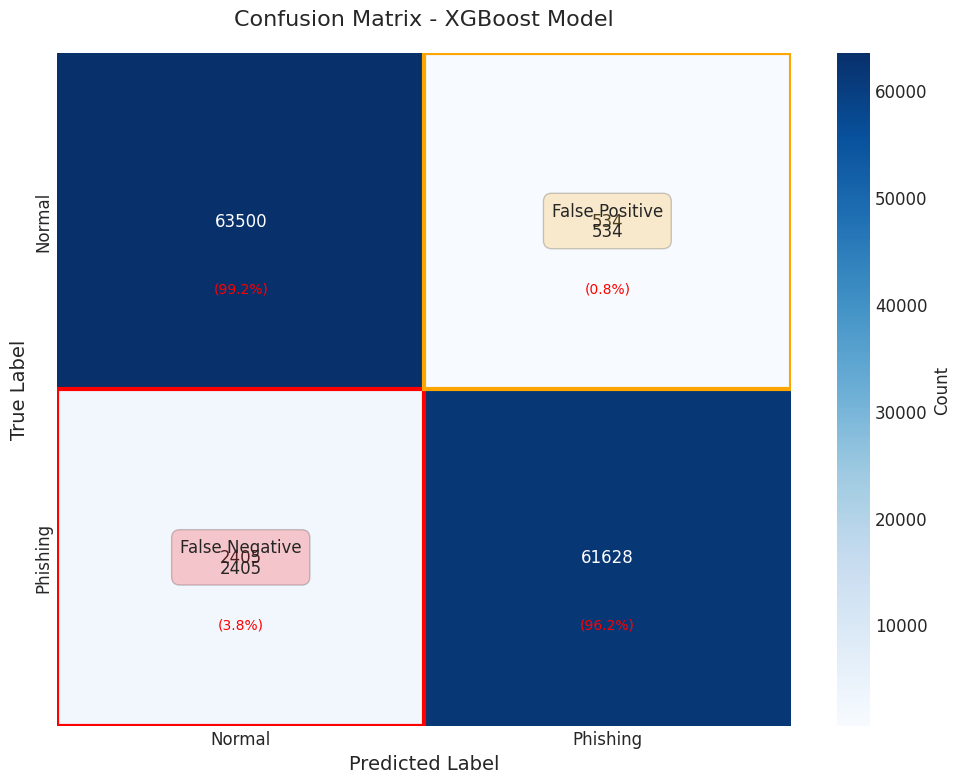


2️⃣ Creating Learning Curves...


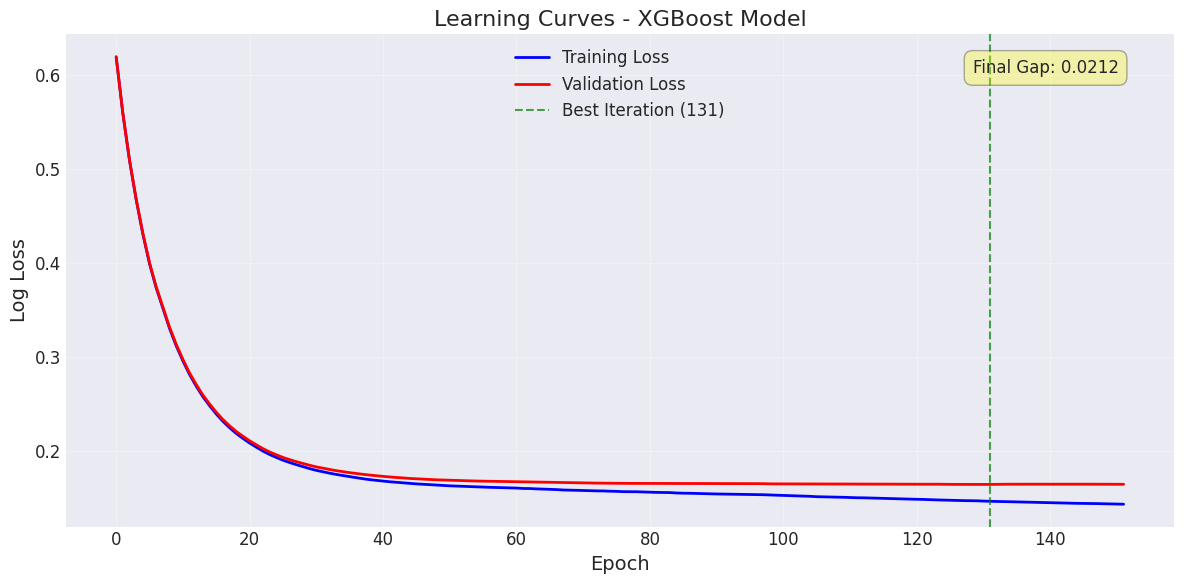


3️⃣ Analyzing Feature Importance...


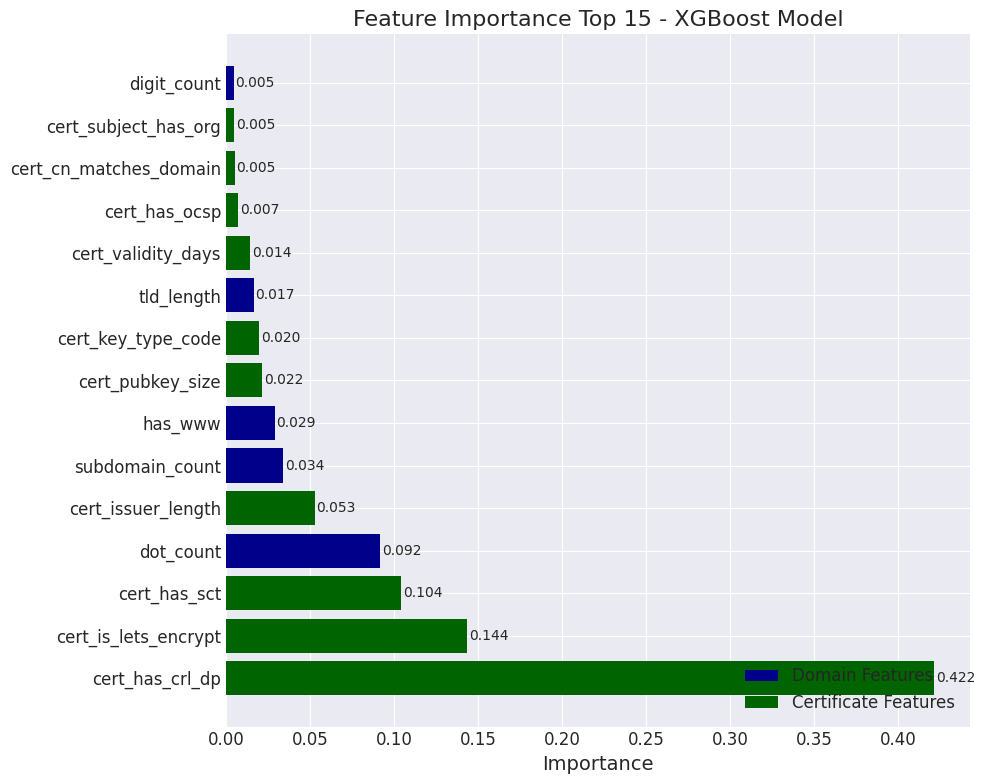


4️⃣ Analyzing Prediction Probability Distribution...


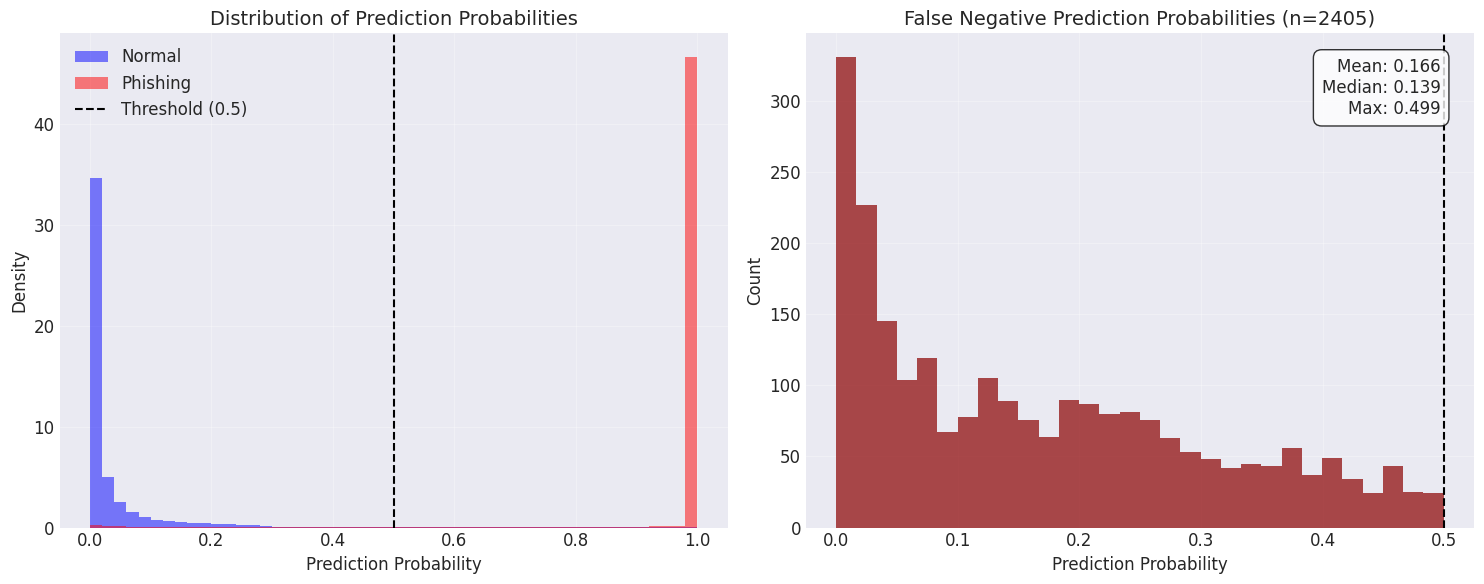


📊 Feature Importance Summary:
             feature  importance
     cert_has_crl_dp    0.421662
cert_is_lets_encrypt    0.143715
        cert_has_sct    0.104373
           dot_count    0.091838
  cert_issuer_length    0.052786
     subdomain_count    0.034033
             has_www    0.029001
    cert_pubkey_size    0.021609
  cert_key_type_code    0.019702
          tld_length    0.016531

📈 Model Evaluation Summary:
  - Most Important Feature: cert_has_crl_dp (0.422)
  - Total Domain Feature Importance: 0.196
  - Total Certificate Feature Importance: 0.804

✅ Model evaluation and visualization completed


In [22]:


"""
セル番号: 5
概要: モデルの詳細な評価と可視化（Confusion Matrix、学習曲線、特徴量重要度）
入力: model, X_test_scaled, y_test, y_pred, y_pred_proba
出力: 各種グラフ（confusion_matrix.png, learning_curves.png, feature_importance.png）
"""

# 可視化の設定
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# 英語フォントを使用（文字化け防止）
plt.rcParams['font.family'] = 'DejaVu Sans'
# マイナス記号の文字化けを防ぐ
plt.rcParams['axes.unicode_minus'] = False

print("📊 Starting model evaluation and visualization...")
print("=" * 80)

# 1. Confusion Matrixの可視化
print("\n1️⃣ Creating Confusion Matrix...")

fig, ax = plt.subplots(figsize=(10, 8))

# Confusion Matrixの計算（正規化版も）
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# ヒートマップの作成
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Phishing'],
            yticklabels=['Normal', 'Phishing'],
            cbar_kws={'label': 'Count'})

# 各セルにパーセンテージを追加
for i in range(2):
    for j in range(2):
        percentage = cm_normalized[i, j] * 100
        text = ax.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)',
                      ha='center', va='center', fontsize=10, color='red')

plt.title('Confusion Matrix - XGBoost Model', fontsize=16, pad=20)
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)

# 偽陰性と偽陽性を強調
ax.add_patch(plt.Rectangle((0, 1), 1, 1, fill=False, edgecolor='red', lw=3))
ax.add_patch(plt.Rectangle((1, 0), 1, 1, fill=False, edgecolor='orange', lw=3))

# 注釈を追加
plt.text(0.5, 1.5, f'False Negative\n{cm[1, 0]}', ha='center', va='center', 
         bbox=dict(boxstyle='round,pad=0.5', facecolor='red', alpha=0.2))
plt.text(1.5, 0.5, f'False Positive\n{cm[0, 1]}', ha='center', va='center',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='orange', alpha=0.2))

plt.tight_layout()
plt.savefig(f"{base_dirs['results']}/confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

# 2. 学習曲線の可視化
print("\n2️⃣ Creating Learning Curves...")

# 訓練履歴の取得
if 'XGB_EVALS_RESULT' in globals() and XGB_EVALS_RESULT:
    results = XGB_EVALS_RESULT
else:
    results = model.evals_result()

fig, ax = plt.subplots(figsize=(12, 6))

epochs = range(len(results['validation_0']['logloss']))
train_loss = results['validation_0']['logloss']
val_loss = results['validation_1']['logloss']

plt.plot(epochs, train_loss, 'b-', label='Training Loss', linewidth=2)
plt.plot(epochs, val_loss, 'r-', label='Validation Loss', linewidth=2)

# 最良の地点をマーク
best_epoch = int(globals().get('XGB_BEST_ITERATION', getattr(model, 'best_iteration', 0)))
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, 
            label=f'Best Iteration ({best_epoch})')

plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Log Loss', fontsize=14)
plt.title('Learning Curves - XGBoost Model', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# 過学習の兆候をチェック
final_gap = val_loss[-1] - train_loss[-1]
plt.text(0.95, 0.95, f'Final Gap: {final_gap:.4f}',
         transform=ax.transAxes, ha='right', va='top',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.3))

plt.tight_layout()
plt.savefig(f"{base_dirs['results']}/learning_curves.png", dpi=300, bbox_inches='tight')
plt.show()

# 3. 特徴量重要度の可視化
print("\n3️⃣ Analyzing Feature Importance...")

# 特徴量重要度の取得
feature_importance = model.feature_importances_
importance_df = pd.DataFrame({
    'feature': FEATURE_ORDER,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# 上位15特徴量を表示
fig, ax = plt.subplots(figsize=(10, 8))

top_features = importance_df.head(15)
colors = ['darkgreen' if 'cert_' in feat else 'darkblue' for feat in top_features['feature']]

bars = plt.barh(range(len(top_features)), top_features['importance'], color=colors)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance', fontsize=14)
plt.title('Feature Importance Top 15 - XGBoost Model', fontsize=16)

# 値を表示
for i, (idx, row) in enumerate(top_features.iterrows()):
    plt.text(row['importance'] + 0.001, i, f'{row["importance"]:.3f}',
             va='center', fontsize=10)

# 凡例
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='darkblue', label='Domain Features'),
    Patch(facecolor='darkgreen', label='Certificate Features')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig(f"{base_dirs['results']}/feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()

# 4. 予測確率の分布
print("\n4️⃣ Analyzing Prediction Probability Distribution...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 全体の分布
ax1.hist(y_pred_proba[y_test == 0], bins=50, alpha=0.5, label='Normal', color='blue', density=True)
ax1.hist(y_pred_proba[y_test == 1], bins=50, alpha=0.5, label='Phishing', color='red', density=True)
ax1.axvline(x=0.5, color='black', linestyle='--', label='Threshold (0.5)')
ax1.set_xlabel('Prediction Probability', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.set_title('Distribution of Prediction Probabilities', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 偽陰性の分布に注目
fn_mask = (y_test == 1) & (y_pred == 0)
fn_probs = y_pred_proba[fn_mask]

ax2.hist(fn_probs, bins=30, color='darkred', alpha=0.7)
ax2.axvline(x=0.5, color='black', linestyle='--', label='Threshold (0.5)')
ax2.set_xlabel('Prediction Probability', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title(f'False Negative Prediction Probabilities (n={len(fn_probs)})', fontsize=14)
ax2.grid(True, alpha=0.3)

# 統計情報を追加
stats_text = f'Mean: {fn_probs.mean():.3f}\nMedian: {np.median(fn_probs):.3f}\nMax: {fn_probs.max():.3f}'
ax2.text(0.95, 0.95, stats_text, transform=ax2.transAxes,
         ha='right', va='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig(f"{base_dirs['results']}/prediction_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

# 重要度の統計サマリー
print("\n📊 Feature Importance Summary:")
print(importance_df.head(10).to_string(index=False))

print(f"\n📈 Model Evaluation Summary:")
print(f"  - Most Important Feature: {importance_df.iloc[0]['feature']} ({importance_df.iloc[0]['importance']:.3f})")
print(f"  - Total Domain Feature Importance: {importance_df[~importance_df['feature'].str.contains('cert_')]['importance'].sum():.3f}")
print(f"  - Total Certificate Feature Importance: {importance_df[importance_df['feature'].str.contains('cert_')]['importance'].sum():.3f}")

print("\n✅ Model evaluation and visualization completed")
print("=" * 80)

🔍 Starting overfitting validation and false negative analysis...

1️⃣ Creating Learning Curves with Different Data Sizes...
  ⚠️ This process may take several minutes...


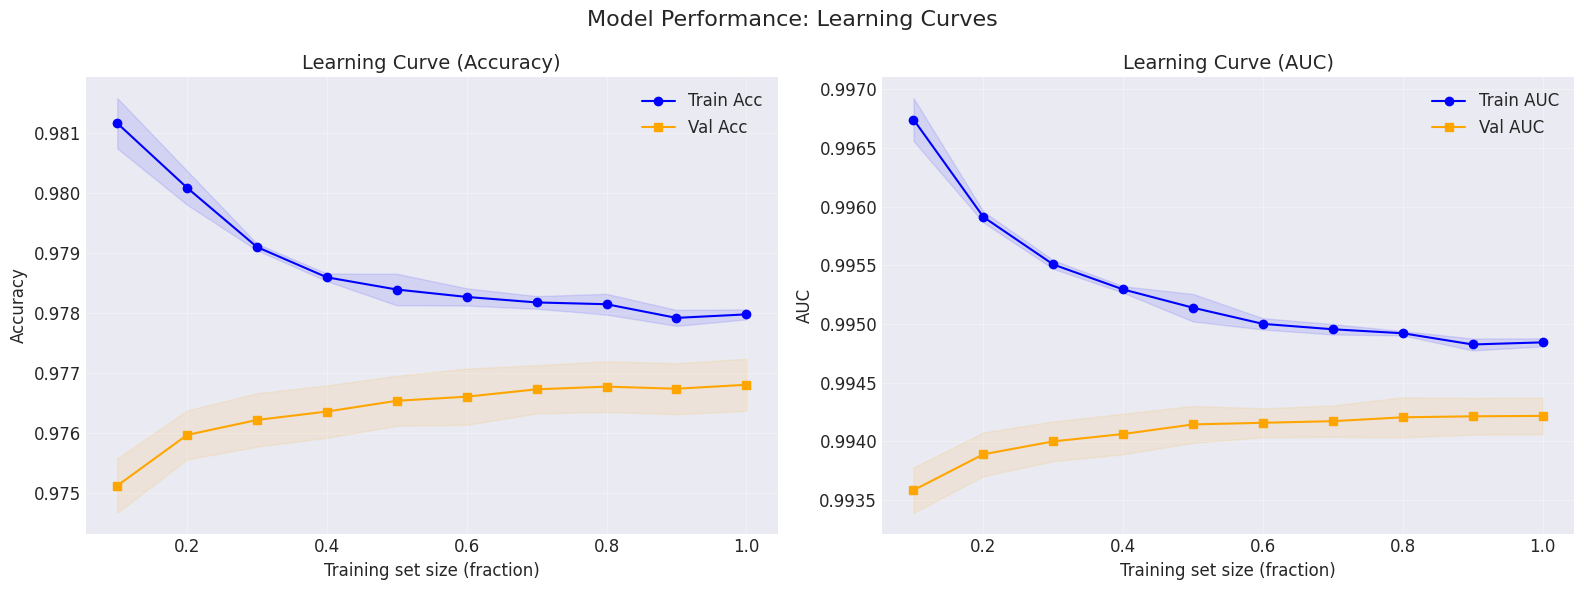


📊 Overfitting Diagnosis:
  - Accuracy Gap (Val-Train): -0.0012
  - AUC Gap (Val-Train): -0.0006
  → ✅ No signs of overfitting detected

2️⃣ Running 5-fold Cross-Validation...
  - CV AUC scores: [0.99420283 0.99464522 0.9945093  0.99478653 0.99413805]
  - Mean CV AUC: 0.9945 (±0.0003)

3️⃣ Computing Permutation Importance...


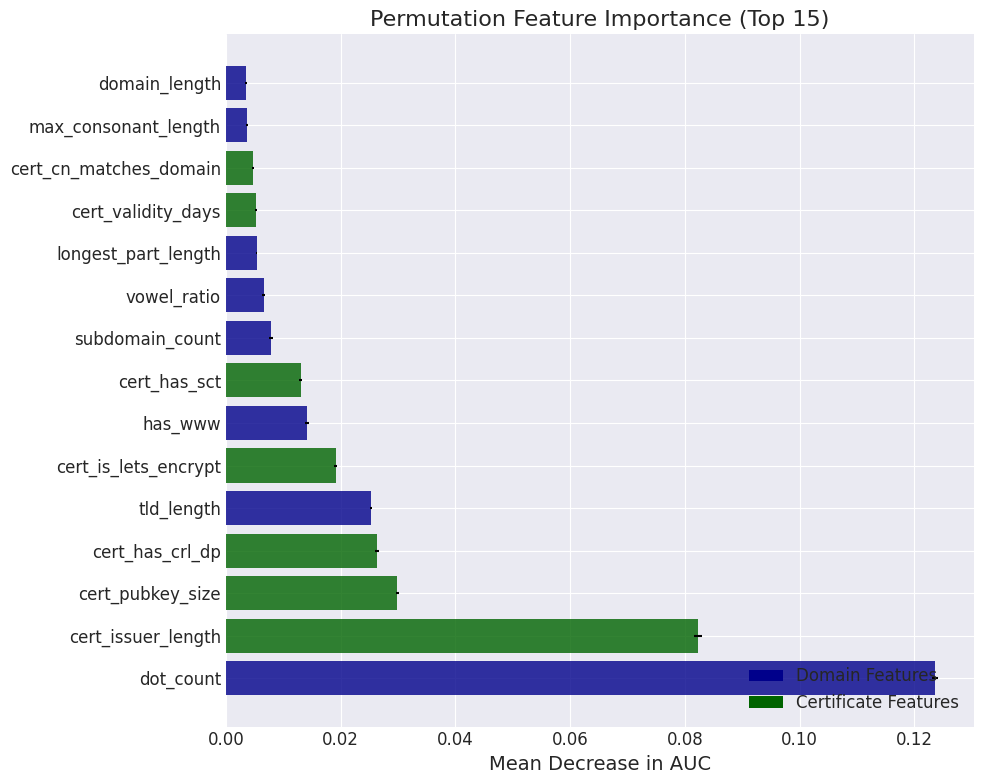


4️⃣ Detailed Analysis of False Negative Samples...

📊 False Negative Samples: 2405
  - False Negative Rate: 3.76%

⚠️ High Confidence False Negatives: 1935
  (Phishing sites that the model strongly classified as 'normal')

📊 False Negative Analysis by Source:
  - certificates: 387/38041 (1.02%)
  - jpcert: 1098/22521 (4.88%)
  - phishtank: 920/3471 (26.51%)

📊 False Negative Domain Characteristics:
  - Average Domain Length: 14.7
  - Min/Max Length: 4/47

  Top 10 TLDs in False Negatives:
    - .com: 1350
    - .cn: 134
    - .top: 94
    - .jp: 56
    - .net: 52
    - .xyz: 37
    - .icu: 35
    - .br: 34
    - .cc: 32
    - .org: 31

💾 False negative data saved to: artifacts/2026-01-05_014726/results/false_negatives.pkl

🔍 False Negative Samples (sorted by lowest prediction probability):
                           domain  prediction_proba       source
                            wk.pl          0.000003    phishtank
                            tx.gl          0.000006    phishtank
   

In [23]:


"""
セル番号: 6
概要: 過学習検証（データサイズ別学習曲線）と偽陰性サンプルの詳細分析
入力: X_train_scaled, X_test_scaled, y_train, y_test, domain_test
出力: overfitting_analysis.png, false_negatives.pkl
"""

from sklearn.model_selection import learning_curve
import gc

print("🔍 Starting overfitting validation and false negative analysis...")
print("=" * 80)

# 必要な変数の確認
if 'y_pred' not in globals() or 'y_pred_proba' not in globals():
    print("⚠️ Prediction results not found. Please run Cell 4 first.")
    print("  Re-running predictions...")
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# 1. データサイズを変えた学習曲線
print("\n1️⃣ Creating Learning Curves with Different Data Sizes...")
print("  ⚠️ This process may take several minutes...")

# 訓練サイズの設定
train_sizes = np.linspace(0.1, 1.0, 10)

# 学習曲線の計算（Accuracy）
train_sizes_abs, train_scores_acc, val_scores_acc = learning_curve(
    xgb.XGBClassifier(
        n_estimators=100,  # 計算時間短縮のため削減
        max_depth=8,
        learning_rate=0.1,
        random_state=42,
        device='cuda' if gpu_available else 'cpu'
    ),
    X_train_scaled, y_train,
    cv=5,
    train_sizes=train_sizes,
    scoring='accuracy',
    n_jobs=1,  # GPU使用時はn_jobs=1に設定
    return_times=False
)

# 学習曲線の計算（AUC）
_, train_scores_auc, val_scores_auc = learning_curve(
    xgb.XGBClassifier(
        n_estimators=100,
        max_depth=8,
        learning_rate=0.1,
        random_state=42,
        device='cuda' if gpu_available else 'cpu'
    ),
    X_train_scaled, y_train,
    cv=5,
    train_sizes=train_sizes,
    scoring='roc_auc',
    n_jobs=1,  # GPU使用時はn_jobs=1に設定
    return_times=False
)

# メモリ解放
gc.collect()

# 結果の可視化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy曲線
train_mean_acc = train_scores_acc.mean(axis=1)
train_std_acc = train_scores_acc.std(axis=1)
val_mean_acc = val_scores_acc.mean(axis=1)
val_std_acc = val_scores_acc.std(axis=1)

ax1.plot(train_sizes, train_mean_acc, 'o-', color='blue', label='Train Acc')
ax1.plot(train_sizes, val_mean_acc, 's-', color='orange', label='Val Acc')
ax1.fill_between(train_sizes, train_mean_acc - train_std_acc,
                 train_mean_acc + train_std_acc, alpha=0.1, color='blue')
ax1.fill_between(train_sizes, val_mean_acc - val_std_acc,
                 val_mean_acc + val_std_acc, alpha=0.1, color='orange')

ax1.set_xlabel('Training set size (fraction)', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Learning Curve (Accuracy)', fontsize=14)
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# AUC曲線
train_mean_auc = train_scores_auc.mean(axis=1)
train_std_auc = train_scores_auc.std(axis=1)
val_mean_auc = val_scores_auc.mean(axis=1)
val_std_auc = val_scores_auc.std(axis=1)

ax2.plot(train_sizes, train_mean_auc, 'o-', color='blue', label='Train AUC')
ax2.plot(train_sizes, val_mean_auc, 's-', color='orange', label='Val AUC')
ax2.fill_between(train_sizes, train_mean_auc - train_std_auc,
                 train_mean_auc + train_std_auc, alpha=0.1, color='blue')
ax2.fill_between(train_sizes, val_mean_auc - val_std_auc,
                 val_mean_auc + val_std_auc, alpha=0.1, color='orange')

ax2.set_xlabel('Training set size (fraction)', fontsize=12)
ax2.set_ylabel('AUC', fontsize=12)
ax2.set_title('Learning Curve (AUC)', fontsize=14)
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

plt.suptitle('Model Performance: Learning Curves', fontsize=16)
plt.tight_layout()
plt.savefig(f"{base_dirs['results']}/learning_curves_by_size.png", dpi=300, bbox_inches='tight')
plt.show()

# 過学習の診断
final_gap_acc = val_mean_acc[-1] - train_mean_acc[-1]
final_gap_auc = val_mean_auc[-1] - train_mean_auc[-1]

print(f"\n📊 Overfitting Diagnosis:")
print(f"  - Accuracy Gap (Val-Train): {final_gap_acc:.4f}")
print(f"  - AUC Gap (Val-Train): {final_gap_auc:.4f}")

if abs(final_gap_acc) < 0.01 and abs(final_gap_auc) < 0.01:
    print("  → ✅ No signs of overfitting detected")
elif abs(final_gap_acc) < 0.02 and abs(final_gap_auc) < 0.02:
    print("  → ⚠️ Mild overfitting may be present")
else:
    print("  → ❌ Overfitting is likely occurring")

# 2. 5-fold交差検証
print("\n2️⃣ Running 5-fold Cross-Validation...")

# 交差検証用のモデル（early_stoppingなし）
cv_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.1,
    objective='binary:logistic',
    eval_metric='logloss',
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    device='cuda' if gpu_available else 'cpu'
)

cv_scores = cross_val_score(
    cv_model, X_train_scaled, y_train, 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=1  # GPU使用時はn_jobs=1に設定
)

print(f"  - CV AUC scores: {cv_scores}")
print(f"  - Mean CV AUC: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# 3. Permutation Importance（テストデータで実施）
print("\n3️⃣ Computing Permutation Importance...")

perm_importance = permutation_importance(
    model, X_test_scaled, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=1  # GPU使用時はn_jobs=1に設定
)

# Permutation Importanceの可視化
perm_imp_df = pd.DataFrame({
    'feature': FEATURE_ORDER,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))

top_perm_features = perm_imp_df.head(15)
colors = ['darkgreen' if 'cert_' in feat else 'darkblue' for feat in top_perm_features['feature']]

bars = ax.barh(range(len(top_perm_features)), 
                top_perm_features['importance_mean'],
                xerr=top_perm_features['importance_std'],
                color=colors, alpha=0.8)

ax.set_yticks(range(len(top_perm_features)))
ax.set_yticklabels(top_perm_features['feature'])
ax.set_xlabel('Mean Decrease in AUC', fontsize=14)
ax.set_title('Permutation Feature Importance (Top 15)', fontsize=16)

# 凡例
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='darkblue', label='Domain Features'),
    Patch(facecolor='darkgreen', label='Certificate Features')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig(f"{base_dirs['results']}/permutation_importance.png", dpi=300, bbox_inches='tight')
plt.show()

# 4. 偽陰性サンプルの詳細分析
print("\n4️⃣ Detailed Analysis of False Negative Samples...")

# 偽陰性のインデックスを取得
fn_indices = np.where((y_test == 1) & (y_pred == 0))[0]
fn_proba = y_pred_proba[fn_indices]

print(f"\n📊 False Negative Samples: {len(fn_indices)}")
print(f"  - False Negative Rate: {len(fn_indices) / sum(y_test == 1) * 100:.2f}%")

# グローバル変数から必要な変数を取得
if 'domain_test' not in globals() or 'source_test' not in globals():
    print("⚠️ Domain information not found. Loading from saved data...")
    # test_data.pklから読み込み
    try:
        test_data = joblib.load(f"{base_dirs['data']}/test_data.pkl")
        domain_test = test_data['domains']
        source_test = test_data['sources']
        print("✅ Domain information loaded successfully")
    except Exception as e:
        print(f"❌ Failed to load domain information: {e}")
        # 基本的な分析のみ実行
        false_negatives_data = {
            'indices': fn_indices,
            'features': X_test[fn_indices],
            'prediction_proba': fn_proba,
            'statistics': {
                'total_fn': len(fn_indices),
                'fn_rate': len(fn_indices) / sum(y_test == 1) * 100,
                'avg_proba': float(fn_proba.mean()),
                'min_proba': float(fn_proba.min()),
                'max_proba': float(fn_proba.max())
            }
        }
        joblib.dump(false_negatives_data, f"{base_dirs['results']}/false_negatives.pkl")
        print(f"  - Average Prediction Probability: {fn_proba.mean():.3f}")
        print(f"  - Minimum Prediction Probability: {fn_proba.min():.3f}")
        print("\n⚠️ Saved limited false negative data (no domain information)")
    
if 'domain_test' in globals() and 'source_test' in globals():
    # 偽陰性サンプルのデータフレーム作成
    fn_analysis_df = pd.DataFrame({
        'domain': domain_test[fn_indices],
        'source': source_test[fn_indices],
        'prediction_proba': fn_proba,
        'confidence': 1 - fn_proba  # 正常と判定した確信度
    })

    # 高確信度偽陰性（予測確率が0.3未満）
    high_confidence_fn = fn_analysis_df[fn_analysis_df['prediction_proba'] < 0.3].copy()
    print(f"\n⚠️ High Confidence False Negatives: {len(high_confidence_fn)}")
    print("  (Phishing sites that the model strongly classified as 'normal')")

    # ソース別の偽陰性率
    print("\n📊 False Negative Analysis by Source:")
    for source in np.unique(source_test):
        source_mask = source_test == source
        source_phishing = (y_test == 1) & source_mask
        source_fn = (y_test == 1) & (y_pred == 0) & source_mask
        
        if source_phishing.sum() > 0:
            fn_rate = source_fn.sum() / source_phishing.sum() * 100
            print(f"  - {source}: {source_fn.sum()}/{source_phishing.sum()} ({fn_rate:.2f}%)")

    # 偽陰性のドメインパターン分析
    print("\n📊 False Negative Domain Characteristics:")
    fn_domains = domain_test[fn_indices]
    fn_domain_lengths = [len(d) for d in fn_domains]
    print(f"  - Average Domain Length: {np.mean(fn_domain_lengths):.1f}")
    print(f"  - Min/Max Length: {min(fn_domain_lengths)}/{max(fn_domain_lengths)}")

    # TLDの分析
    fn_tlds = [d.split('.')[-1] if '.' in d else '' for d in fn_domains]
    tld_counts = pd.Series(fn_tlds).value_counts().head(10)
    print("\n  Top 10 TLDs in False Negatives:")
    for tld, count in tld_counts.items():
        print(f"    - .{tld}: {count}")

    # 偽陰性データの辞書を作成
    false_negatives_data = {
        'analysis_df': fn_analysis_df,
        'indices': fn_indices,
        'features': X_test[fn_indices],
        'high_confidence_fn': high_confidence_fn,
        'statistics': {
            'total_fn': int(len(fn_indices)),
            'fn_rate': float(len(fn_indices) / sum(y_test == 1) * 100),
            'high_confidence_fn_count': int(len(high_confidence_fn)),
            'avg_proba': float(fn_proba.mean()),
            'min_proba': float(fn_proba.min()),
            'max_proba': float(fn_proba.max())
        }
    }

    # 保存
    joblib.dump(false_negatives_data, f"{base_dirs['results']}/false_negatives.pkl")
    print(f"\n💾 False negative data saved to: {base_dirs['results']}/false_negatives.pkl")

    # サンプル表示
    print("\n🔍 False Negative Samples (sorted by lowest prediction probability):")
    print(fn_analysis_df.nsmallest(10, 'prediction_proba')[['domain', 'prediction_proba', 'source']].to_string(index=False))
    
    # 保存データの確認
    print("\n📋 Verifying saved data format:")
    with open(f"{base_dirs['results']}/false_negatives.pkl", 'rb') as f:
        fn_data = joblib.load(f)
    
    print(f"  - Data type: {type(fn_data)}")
    if isinstance(fn_data, dict):
        print(f"  - Keys: {list(fn_data.keys())}")
        print(f"  - analysis_df type: {type(fn_data.get('analysis_df'))}")
        print(f"  - analysis_df rows: {len(fn_data.get('analysis_df', []))}")
        print("  ✅ Data saved in correct format!")

print("\n✅ Overfitting validation and false negative analysis completed")
print("=" * 80)

In [24]:


"""
セル番号: 7
概要: プロジェクト全体のサマリーと05_ai_agent_analysis.ipynbへの引き継ぎ情報
入力: training_metrics.json, false_negatives.pkl
出力: project_summary.txt
"""

print("=" * 80)
print("📋 PROJECT SUMMARY: 02_xgboost_training_evaluation.py")
print("=" * 80)

# トレーニングメトリクスの読み込み
with open(f"{base_dirs['results']}/training_metrics.json", 'r') as f:
    metrics = json.load(f)

# セッション情報
print(f"\n📅 Session Information:")
print(f"  - Session ID: {session_id}")
print(f"  - Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"  - GPU Used: {'Yes' if gpu_available else 'No'}")

# データ統計
print(f"\n📊 Data Statistics:")
print(f"  - Total samples: {len(X_train) + len(X_test):,}")
print(f"  - Training samples: {len(X_train):,}")
print(f"  - Test samples: {len(X_test):,}")
print(f"  - Features: {len(FEATURE_ORDER)}")
print(f"  - Class balance: 50.0% / 50.0%")

# モデル性能
print(f"\n🎯 Model Performance:")
print(f"  - Accuracy: {metrics['performance']['accuracy']:.4f}")
print(f"  - Precision: {metrics['performance']['precision']:.4f}")
print(f"  - Recall: {metrics['performance']['recall']:.4f}")
print(f"  - F1-Score: {metrics['performance']['f1_score']:.4f}")
print(f"  - ROC-AUC: {metrics['performance']['roc_auc']:.4f}")

# 偽陰性分析
print(f"\n⚠️ False Negative Analysis:")
print(f"  - False Negative Rate: {metrics['performance']['false_negative_rate']:.4f}")
print(f"  - False Negatives: {metrics['confusion_matrix']['fn']:,}")
print(f"  - False Positive Rate: {metrics['performance']['false_positive_rate']:.4f}")
print(f"  - False Positives: {metrics['confusion_matrix']['fp']:,}")

# 保存ファイル
print(f"\n💾 Saved Files:")
print(f"  Models:")
print(f"    - {base_dirs['models']}/xgboost_model.pkl")
print(f"    - {base_dirs['models']}/scaler.pkl")
print(f"    - {base_dirs['models']}/feature_order.json")
print(f"  Results:")
print(f"    - {base_dirs['results']}/confusion_matrix.png")
print(f"    - {base_dirs['results']}/learning_curves.png")
print(f"    - {base_dirs['results']}/feature_importance.png")
print(f"    - {base_dirs['results']}/prediction_distribution.png")
print(f"    - {base_dirs['results']}/learning_curves_by_size.png")
print(f"    - {base_dirs['results']}/permutation_importance.png")
print(f"    - {base_dirs['results']}/false_negatives.pkl")
print(f"    - {base_dirs['results']}/training_metrics.json")
print(f"  Data:")
print(f"    - {base_dirs['data']}/train_data.pkl")
print(f"    - {base_dirs['data']}/test_data.pkl")

# 05_ai_agent_analysis.ipynbへの引き継ぎ
print(f"\n🔄 For 05_ai_agent_analysis.ipynb:")
print(f"  Key findings:")
print(f"    - {metrics['confusion_matrix']['fn']:,} false negatives need AI agent analysis")
print(f"    - False negative rate: {metrics['performance']['false_negative_rate']*100:.2f}%")
print(f"    - These are phishing sites that XGBoost missed")
print(f"\n  Load the following files:")
print(f"    - Model: {base_dirs['models']}/xgboost_model.pkl")
print(f"    - False negatives: {base_dirs['results']}/false_negatives.pkl")
print(f"    - Scaler: {base_dirs['models']}/scaler.pkl")

# サマリーファイルの保存
summary_text = f"""
PROJECT SUMMARY: 02_xgboost_training_evaluation
===============================================

Session ID: {session_id}
Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

DATA STATISTICS:
- Total samples: {len(X_train) + len(X_test):,}
- Training samples: {len(X_train):,}
- Test samples: {len(X_test):,}
- Features: {len(FEATURE_ORDER)}

MODEL PERFORMANCE:
- Accuracy: {metrics['performance']['accuracy']:.4f}
- Precision: {metrics['performance']['precision']:.4f}
- Recall: {metrics['performance']['recall']:.4f}
- F1-Score: {metrics['performance']['f1_score']:.4f}
- ROC-AUC: {metrics['performance']['roc_auc']:.4f}

FALSE NEGATIVE ANALYSIS:
- False Negative Rate: {metrics['performance']['false_negative_rate']:.4f}
- False Negatives: {metrics['confusion_matrix']['fn']:,}
- False Positive Rate: {metrics['performance']['false_positive_rate']:.4f}
- False Positives: {metrics['confusion_matrix']['fp']:,}

CONCLUSION:
The XGBoost model achieved high overall performance with {metrics['performance']['accuracy']:.1%} accuracy.
However, {metrics['confusion_matrix']['fn']:,} phishing sites were misclassified as normal.
These false negatives will be analyzed by the AI agent in 05_ai_agent_analysis.ipynb.

NEXT STEPS:
1. Run 05_ai_agent_analysis.ipynb to analyze false negatives with GPT-4o mini
2. Identify patterns that ML model missed
3. Develop hybrid ML+LLM approach for improved detection
"""

with open(f"{base_dirs['results']}/project_summary.txt", 'w') as f:
    f.write(summary_text)

print(f"\n✅ Project summary saved to: {base_dirs['results']}/project_summary.txt")

# 重要な洞察
if 'importance_df' in globals():
    print(f"\n🔍 Key Insights:")
    print(f"  Most important features:")
    for i, (idx, row) in enumerate(importance_df.head(5).iterrows()):
        print(f"    {i+1}. {row['feature']}: {row['importance']:.3f}")

print("\n" + "=" * 80)
print("✨ 02_xgboost_training_evaluation.py COMPLETED SUCCESSFULLY!")
print("🚀 Next: Run 05_ai_agent_analysis.ipynb to analyze false negatives with AI")
print("=" * 80)

📋 PROJECT SUMMARY: 02_xgboost_training_evaluation.py

📅 Session Information:
  - Session ID: 2026-01-05_014726
  - Date: 2026-01-05 02:46:08
  - GPU Used: Yes

📊 Data Statistics:
  - Total samples: 640,332
  - Training samples: 512,265
  - Test samples: 128,067
  - Features: 35
  - Class balance: 50.0% / 50.0%

🎯 Model Performance:


KeyError: 'performance'

In [ ]:
"""
セル番号: 7.x
概要: 閾値をスイープして FN / FP / Fβ / Agent負荷 を評価する
入力: y_test, y_pred_proba, base_dirs
出力: threshold_sweep_metrics_beta{beta}.csv
"""

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score, fbeta_score

print("\n⚙️ 閾値スイープ解析を開始します...")

# 必要変数の存在確認
required_vars = ["y_test", "y_pred_proba", "base_dirs"]
missing = [v for v in required_vars if v not in globals()]
if missing:
    raise NameError(
        f"Threshold analysis requires variables {missing}. "
        "モデル訓練セルを先に実行してください。"
    )

y_true = np.asarray(y_test)
proba = np.asarray(y_pred_proba)

total = len(y_true)
total_phishing = int((y_true == 1).sum())
total_normal = int((y_true == 0).sum())

print(f"  - テストサンプル数: {total:,}")
print(f"  - Normal: {total_normal:,}, Phishing: {total_phishing:,}")

# 閾値候補（必要に応じて変更）
thresholds = np.round(np.arange(0.05, 0.95, 0.05), 2)  # 0.05〜0.90
beta = 2.0  # Recall を重視する Fβ の β

rows = []

for thr in thresholds:
    y_pred_thr = (proba >= thr).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_thr).ravel()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    # 通常の F1
    f1 = f1_score(y_true, y_pred_thr, pos_label=1)

    # Recall を重視した Fβ（Phishing=1クラスのみ）
    f_beta = fbeta_score(
        y_true, y_pred_thr,
        beta=beta,
        pos_label=1,
        average="binary"
    )

    fn_rate = fn / total_phishing if total_phishing > 0 else 0.0
    fp_rate = fp / total_normal if total_normal > 0 else 0.0

    # 「Phishing と判定された割合」= Agentに回る割合とみなせる
    positive_rate = (tp + fp) / total if total > 0 else 0.0

    rows.append({
        "threshold": thr,
        "tp": tp,
        "fp": fp,
        "fn": fn,
        "tn": tn,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        f"f_beta(beta={beta})": f_beta,
        "fn_rate_phishing": fn_rate,   # フィッシング中での FN率
        "fp_rate_normal": fp_rate,     # Normal中での FP率
        "agent_load_rate": positive_rate,  # 全体の何割を Agent に回すか
    })

threshold_df = (
    pd.DataFrame(rows)
    .sort_values("threshold", ascending=False)
    .reset_index(drop=True)
)

# Fβ が最大の閾値を表示
best_row = threshold_df.loc[threshold_df[f"f_beta(beta={beta})"].idxmax()]

print("\n🏁 Fβ(β={:.1f}) が最大となる閾値候補:".format(beta))
print(best_row[[
    "threshold",
    "precision",
    "recall",
    "f1",
    f"f_beta(beta={beta})",
    "fn_rate_phishing",
    "fp_rate_normal",
    "agent_load_rate",
]].to_string())

print("\n📋 閾値別メトリクス（先頭10行）:")
print(threshold_df.head(10).to_string(index=False))

# CSV 保存
out_path = f"{base_dirs['results']}/threshold_sweep_metrics_beta{beta:.1f}.csv"
threshold_df.to_csv(out_path, index=False)
print(f"\n💾 閾値スイープ結果を保存しました: {out_path}")


In [ ]:
# セル: 閾値と Fβ / F1 の関係をプロット

import os
import pandas as pd
import matplotlib.pyplot as plt

beta = 2.0
metrics_path = f"{base_dirs['results']}/threshold_sweep_metrics_beta{beta:.1f}.csv"

# 既に threshold_df がメモリにあるならこの行は省略してOK
threshold_df = pd.read_csv(metrics_path)

# 閾値を昇順に並べ替え（グラフを見やすくするため）
threshold_df = threshold_df.sort_values("threshold").reset_index(drop=True)

# ベスト閾値（Fβ最大）を取得
best_idx = threshold_df[f"f_beta(beta={beta})"].idxmax()
best_row = threshold_df.loc[best_idx]
best_thr = best_row["threshold"]

print(f"Best threshold (beta={beta}): {best_thr:.2f}")
print(best_row[[
    "threshold", "precision", "recall", "f1", f"f_beta(beta={beta})",
    "fn_rate_phishing", "fp_rate_normal", "agent_load_rate"
]])

plt.figure(figsize=(8, 5))

plt.plot(
    threshold_df["threshold"],
    threshold_df[f"f_beta(beta={beta})"],
    marker="o",
    label=f"Fβ (β={beta})"
)
plt.plot(
    threshold_df["threshold"],
    threshold_df["f1"],
    marker="s",
    linestyle="--",
    label="F1"
)

# 現行の閾値(0.5)と、Fβ最大の閾値に縦線を引く
plt.axvline(0.5, linestyle="--", linewidth=1, label="Current threshold 0.50")
plt.axvline(best_thr, linestyle=":", linewidth=1.5, label=f"Best threshold {best_thr:.2f}")

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title(f"F1 and Fβ (β={beta}) vs Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()

# 画像として保存しておく（レポートやスライドに貼る用）
out_path = os.path.join(base_dirs["results"], f"threshold_f1_fbeta_beta{beta:.1f}.png")
plt.savefig(out_path, dpi=200)
print(f"Saved figure: {out_path}")
plt.show()


In [ ]:
## =========================================
# ① threshold_df の読み込み（または作成）
# =========================================
import pandas as pd
import matplotlib.pyplot as plt
import os

beta = 2.0
csv_path = f"{base_dirs['results']}/threshold_sweep_metrics_beta{beta:.1f}.csv"

threshold_df = pd.read_csv(csv_path)

print("Loaded threshold_df:")
display(threshold_df.head())

# =========================================
# ② グラフ描画（Correct Rates）
# =========================================

# 昇順
threshold_df = threshold_df.sort_values("threshold").reset_index(drop=True)

# 正しい率を % に変換
fn_rate_pct   = threshold_df["fn_rate_phishing"] * 100.0
fp_rate_pct   = threshold_df["fp_rate_normal"] * 100.0
load_rate_pct = threshold_df["agent_load_rate"] * 100.0

plt.figure(figsize=(8, 5))

plt.plot(threshold_df["threshold"], fn_rate_pct, marker="o", color="tab:blue",
         label="FN rate (FN / Phishing)")
plt.plot(threshold_df["threshold"], fp_rate_pct, marker="s", color="tab:orange",
         label="FP rate (FP / Normal)")
plt.plot(threshold_df["threshold"], load_rate_pct, marker="^", linestyle="--",
         color="tab:green", label="Agent load rate ((TP+FP)/Total)")

# 重要 Threshold
plt.axvline(0.50, linestyle="--", linewidth=1, color="gray", label="Threshold = 0.50")
plt.axvline(0.20, linestyle=":", linewidth=1, color="gray", label="Threshold = 0.20")

plt.xlabel("Threshold")
plt.ylabel("Rate (percentage)")
plt.title("FN / FP / Agent Load vs Threshold (Correct Rates)")
plt.grid(True)
plt.legend()
plt.tight_layout()

out_path = os.path.join(base_dirs["results"],
                        f"threshold_fn_fp_load_correct_rates_beta{beta:.1f}.png")
plt.savefig(out_path, dpi=200)
print(f"Saved figure: {out_path}")

plt.show()


In [ ]:
# セル: 閾値と FN率 / FP率 / Agent負荷の関係をプロット

import matplotlib.pyplot as plt
import os

# threshold_df が上のセルですでにある前提

plt.figure(figsize=(8, 5))

plt.plot(
    threshold_df["threshold"],
    threshold_df["fn_rate_phishing"],
    marker="o",
    label="FN rate (phishing)"
)
plt.plot(
    threshold_df["threshold"],
    threshold_df["fp_rate_normal"],
    marker="s",
    label="FP rate (normal)"
)
plt.plot(
    threshold_df["threshold"],
    threshold_df["agent_load_rate"],
    marker="^",
    linestyle="--",
    label="Agent load rate"
)

plt.axvline(0.5, linestyle="--", linewidth=1, label="Current threshold 0.50")
plt.axvline(best_thr, linestyle=":", linewidth=1.5, label=f"Best threshold {best_thr:.2f}")

plt.xlabel("Threshold")
plt.ylabel("Rate")
plt.title("FN / FP / Agent Load vs Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()

out_path = os.path.join(base_dirs["results"], f"threshold_fn_fp_load_beta{beta:.1f}.png")
plt.savefig(out_path, dpi=200)
print(f"Saved figure: {out_path}")
plt.show()


In [ ]:
"""
セル番号: 5-ROC
概要: ROC曲線の描画と、Fβ(Recall重視) が最大となるthresholdの算出・可視化
入力: y_test, y_pred_proba, base_dirs, model, X_test_scaled
出力: roc_curve_with_best_fbeta.png （results/ 以下）
"""

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    fbeta_score,
    confusion_matrix,
)

# ------------------------------------------------------------
# 1. 必要な変数の存在チェック & 足りなければ補完
# ------------------------------------------------------------
required_vars = ["y_test", "y_pred_proba", "base_dirs"]
missing = [v for v in required_vars if v not in globals()]
if missing:
    # y_pred_proba は model.predict_proba から再計算できるので、可能なら補完
    if missing == ["y_pred_proba"] and "model" in globals() and "X_test_scaled" in globals():
        print("⚠️ y_pred_proba が無かったので model.predict_proba から再計算します。")
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        raise RuntimeError(
            f"必要な変数 {missing} が見つかりません。"
            "データ読み込みセルとモデル学習セル（セル1〜4）を先に実行してください。"
        )

y_true = np.asarray(y_test)
scores = np.asarray(y_pred_proba)

# ------------------------------------------------------------
# 2. ROC曲線の計算
# ------------------------------------------------------------
fpr, tpr, thresholds = roc_curve(y_true, scores, pos_label=1)
roc_auc = roc_auc_score(y_true, scores)

print(f"ROC AUC: {roc_auc:.4f}")
print(f"ROC points: {len(thresholds)} 個")

# ------------------------------------------------------------
# 3. 各thresholdに対する Fβ (Recall重視) を計算
#    ※ 課題の「重み付きF1」に対応（ここでは β=2 を例）
# ------------------------------------------------------------
beta = 2.0

fbeta_list = []
for thr in thresholds:
    y_pred_thr = (scores >= thr).astype(int)
    fbeta = fbeta_score(y_true, y_pred_thr, beta=beta, pos_label=1)
    fbeta_list.append(fbeta)

fbeta_arr = np.asarray(fbeta_list)
best_idx = int(np.argmax(fbeta_arr))
best_thr = float(thresholds[best_idx])
best_fbeta = float(fbeta_arr[best_idx])
best_fpr = float(fpr[best_idx])
best_tpr = float(tpr[best_idx])

print("\n🏁 Fβ(β={:.1f}) が最大となるthreshold:".format(beta))
print(f"  - best_threshold = {best_thr:.4f}")
print(f"  - best_Fβ        = {best_fbeta:.4f}")
print(f"  - TPR(=Recall)   = {best_tpr:.4f}")
print(f"  - FPR            = {best_fpr:.4f}")

# 参考用: 現在運用を想定している閾値（例: 0.50）の点も出しておく
current_thr = 0.50
y_pred_current = (scores >= current_thr).astype(int)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred_current).ravel()
tpr_current = tp / (tp + fn)
fpr_current = fp / (fp + tn)
fbeta_current = fbeta_score(y_true, y_pred_current, beta=beta, pos_label=1)

print("\n📌 現行threshold {:.2f} のとき:".format(current_thr))
print(f"  - Fβ(β={beta:.1f}) = {fbeta_current:.4f}")
print(f"  - TPR(=Recall)     = {tpr_current:.4f}")
print(f"  - FPR              = {fpr_current:.4f}")

# ------------------------------------------------------------
# 4. ROC曲線の描画（ベストthresholdと現行thresholdをマーク）
# ------------------------------------------------------------

# 既存セルと同じスタイルに揃える
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

plt.figure()

# メインのROC曲線
plt.plot(
    fpr,
    tpr,
    label=f"ROC curve (AUC = {roc_auc:.3f})",
)

# ランダム分類の対角線
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label="Random")

# Fβ最大のthresholdの点
plt.scatter(
    best_fpr,
    best_tpr,
    s=80,
    marker='o',
    edgecolor='black',
    linewidths=1,
    label=f"Best Fβ (β={beta:.1f}, thr={best_thr:.2f})",
)

# 現行thresholdの点
plt.scatter(
    fpr_current,
    tpr_current,
    s=80,
    marker='s',
    edgecolor='black',
    linewidths=1,
    label=f"Current thr={current_thr:.2f}",
)

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR / Recall)")
plt.title(f"ROC Curve and Best Fβ(β={beta:.1f}) Threshold")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()

# 画像保存
out_path = os.path.join(base_dirs["results"], f"roc_curve_with_best_fbeta_beta{beta:.1f}.png")
plt.savefig(out_path, dpi=300, bbox_inches='tight')
print(f"\n💾 ROC曲線画像を保存しました: {out_path}")
plt.show()


In [ ]:


"""
プログラム名: 02_xgboost_training_evaluation.ipynb
概要: MLモデルが見逃したフィッシングサイトをAIエージェント（GPT-4o mini）で検出
目的: 国際学会論文での発表（MLとLLMのハイブリッドアプローチの実証）
作成日: 2024-01-22
"""

"""
セル番号: 7.5
概要: 偽陰性の予測確率分布の詳細分析（閾値付近 vs 全体）
入力: y_test, y_pred, y_pred_proba, false_negatives.pkl
出力: fn_distribution_analysis.png, fn_distribution_stats.json
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json
import joblib
from datetime import datetime
from typing import Dict, List, Tuple

print("=" * 80)
print("🔬 偽陰性（False Negative）の予測確率分布詳細分析")
print("=" * 80)

# 必要な変数の確認
required_vars = ['y_test', 'y_pred', 'y_pred_proba', 'base_dirs']
missing_vars = [var for var in required_vars if var not in globals()]

if missing_vars:
    print(f"⚠️ 必要な変数が不足しています: {missing_vars}")
    print("   Cell 4（モデル訓練）を先に実行してください")
    raise NameError(f"Required variables not found: {missing_vars}")

# 偽陰性データの読み込み
try:
    with open(f"{base_dirs['results']}/false_negatives.pkl", 'rb') as f:
        fn_data = joblib.load(f)
    print(f"✅ 偽陰性データを読み込みました")
except FileNotFoundError:
    print("⚠️ false_negatives.pklが見つかりません。Cell 6を先に実行してください")
    raise

# ========================================
# 1. 基本的な偽陰性の分布統計
# ========================================

print("\n📊 1. 偽陰性の基本統計")
print("-" * 40)

# 偽陰性のマスクと予測確率を取得
fn_mask = (y_test == 1) & (y_pred == 0)
fn_proba = y_pred_proba[fn_mask]
tp_mask = (y_test == 1) & (y_pred == 1)
tp_proba = y_pred_proba[tp_mask]

total_phishing = sum(y_test == 1)
total_fn = len(fn_proba)
fn_rate = total_fn / total_phishing * 100

print(f"  - 総フィッシングサンプル数: {total_phishing:,}")
print(f"  - 偽陰性（FN）数: {total_fn:,}")
print(f"  - 偽陰性率: {fn_rate:.2f}%")
print(f"\n  予測確率の統計:")
print(f"    - 平均値: {fn_proba.mean():.4f}")
print(f"    - 中央値: {np.median(fn_proba):.4f}")
print(f"    - 標準偏差: {fn_proba.std():.4f}")
print(f"    - 最小値: {fn_proba.min():.4f}")
print(f"    - 最大値: {fn_proba.max():.4f}")

# ========================================
# 2. 予測確率の区間別分析
# ========================================

print("\n📊 2. 予測確率の区間別分布")
print("-" * 40)

# 区間を定義（0.05刻みの細かい分析）
bins = np.arange(0, 1.05, 0.05)
bin_labels = [f"{bins[i]:.2f}-{bins[i+1]:.2f}" for i in range(len(bins)-1)]

# 偽陰性の区間別カウント
fn_hist, _ = np.histogram(fn_proba, bins=bins)
fn_cumsum = np.cumsum(fn_hist)
fn_cumsum_pct = fn_cumsum / total_fn * 100

# 詳細な統計テーブルを作成
distribution_df = pd.DataFrame({
    '区間': bin_labels,
    'FN数': fn_hist,
    'FN割合(%)': fn_hist / total_fn * 100,
    '累積FN数': fn_cumsum,
    '累積割合(%)': fn_cumsum_pct
})

print("\n予測確率区間別の偽陰性分布:")
print(distribution_df.to_string(index=False))

# DataFrameをJSON用に変換（NumPy型をPython型に変換）
distribution_dict = []
for _, row in distribution_df.iterrows():
    distribution_dict.append({
        '区間': str(row['区間']),
        'FN数': int(row['FN数']),
        'FN割合(%)': float(row['FN割合(%)']),
        '累積FN数': int(row['累積FN数']),
        '累積割合(%)': float(row['累積割合(%)'])
    })

# ========================================
# 3. 閾値からの距離別分析
# ========================================

print("\n📊 3. 閾値（0.5）からの距離別分析")
print("-" * 40)

threshold = 0.5
distance_ranges = {
    '閾値直前（0.45-0.50）': (0.45, 0.50),
    '閾値付近（0.40-0.45）': (0.40, 0.45),
    '中距離（0.30-0.40）': (0.30, 0.40),
    '遠距離（0.20-0.30）': (0.20, 0.30),
    '超遠距離（0.00-0.20）': (0.00, 0.20)
}

distance_stats = {}
for range_name, (low, high) in distance_ranges.items():
    range_mask = (fn_proba >= low) & (fn_proba < high)
    range_count = range_mask.sum()
    range_pct = range_count / total_fn * 100 if total_fn > 0 else 0
    distance_stats[range_name] = {
        'count': int(range_count),
        'percentage': float(range_pct)
    }
    print(f"  {range_name}: {range_count:,}件 ({range_pct:.1f}%)")

# 重要な累積統計
print("\n📊 累積統計（閾値から離れた偽陰性）:")
cumulative_ranges = [
    (0.4, "予測確率 < 0.4"),
    (0.3, "予測確率 < 0.3"),
    (0.2, "予測確率 < 0.2"),
    (0.1, "予測確率 < 0.1")
]

for threshold_val, description in cumulative_ranges:
    count = (fn_proba < threshold_val).sum()
    pct = count / total_fn * 100 if total_fn > 0 else 0
    print(f"  {description}: {count:,}件 ({pct:.1f}%)")

# ========================================
# 4. 可視化
# ========================================

print("\n📊 4. 分布の可視化を作成中...")

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 4.1. ヒストグラムと密度プロット
ax1 = fig.add_subplot(gs[0, :2])
ax1.hist(fn_proba, bins=50, alpha=0.6, color='red', label='False Negatives', density=True)
ax1.hist(tp_proba, bins=50, alpha=0.6, color='green', label='True Positives', density=True)

# カーネル密度推定
if len(fn_proba) > 1:
    density_fn = stats.gaussian_kde(fn_proba)
    x_range = np.linspace(0, 1, 200)
    ax1.plot(x_range, density_fn(x_range), 'r-', linewidth=2, label='FN Density')

if len(tp_proba) > 1:
    density_tp = stats.gaussian_kde(tp_proba)
    ax1.plot(x_range, density_tp(x_range), 'g-', linewidth=2, label='TP Density')

ax1.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Threshold')
ax1.set_xlabel('Prediction Probability', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.set_title('False Negative vs True Positive Distribution', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 4.2. 累積分布関数（CDF）
ax2 = fig.add_subplot(gs[0, 2])
sorted_fn_proba = np.sort(fn_proba)
cumulative_pct = np.arange(1, len(sorted_fn_proba) + 1) / len(sorted_fn_proba) * 100

ax2.plot(sorted_fn_proba, cumulative_pct, 'r-', linewidth=2)
ax2.fill_between(sorted_fn_proba, 0, cumulative_pct, alpha=0.3, color='red')
ax2.axvline(x=0.5, color='black', linestyle='--', linewidth=2)
ax2.axhline(y=50, color='gray', linestyle=':', alpha=0.5)
ax2.set_xlabel('Prediction Probability', fontsize=12)
ax2.set_ylabel('Cumulative % of FN', fontsize=12)
ax2.set_title('Cumulative Distribution of FN', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 重要な点をマーク
for prob_threshold in [0.1, 0.2, 0.3, 0.4]:
    pct = (fn_proba < prob_threshold).sum() / len(fn_proba) * 100
    ax2.plot(prob_threshold, pct, 'ro', markersize=8)
    ax2.annotate(f'{pct:.1f}%', xy=(prob_threshold, pct), 
                xytext=(prob_threshold-0.05, pct+5),
                fontsize=9)

# 4.3. 箱ひげ図と分布の要約
ax3 = fig.add_subplot(gs[1, 0])
box_data = [fn_proba, tp_proba]
bp = ax3.boxplot(box_data, labels=['False Negatives', 'True Positives'],
                  patch_artist=True, showmeans=True)
bp['boxes'][0].set_facecolor('red')
bp['boxes'][0].set_alpha(0.6)
bp['boxes'][1].set_facecolor('green')
bp['boxes'][1].set_alpha(0.6)

ax3.axhline(y=0.5, color='black', linestyle='--', linewidth=2)
ax3.set_ylabel('Prediction Probability', fontsize=12)
ax3.set_title('Distribution Summary', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# 4.4. 区間別偽陰性数の棒グラフ
ax4 = fig.add_subplot(gs[1, 1:])
colors = ['darkred' if float(label.split('-')[0]) < 0.3 else 
          'red' if float(label.split('-')[0]) < 0.5 else 
          'orange' for label in bin_labels]

bars = ax4.bar(range(len(bin_labels)), fn_hist, color=colors, alpha=0.7, edgecolor='black')
ax4.set_xticks(range(len(bin_labels)))
ax4.set_xticklabels(bin_labels, rotation=45, ha='right')
ax4.set_xlabel('Prediction Probability Range', fontsize=12)
ax4.set_ylabel('Number of False Negatives', fontsize=12)
ax4.set_title('False Negative Distribution by Probability Range', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# 各棒の上に値を表示
for i, (bar, value) in enumerate(zip(bars, fn_hist)):
    if value > 0:
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{value}\n({value/total_fn*100:.1f}%)', 
                ha='center', va='bottom', fontsize=8)

# 4.5. ヒートマップ（2D密度）
ax5 = fig.add_subplot(gs[2, :2])
# 予測確率を細かいビンに分割してヒートマップを作成
prob_bins = np.linspace(0, 1, 51)
hist_2d = np.histogram(fn_proba, bins=prob_bins)[0]

# ヒートマップデータの作成（1行のデータを複数行に複製して見やすくする）
heatmap_data = np.repeat(hist_2d.reshape(1, -1), 10, axis=0)

im = ax5.imshow(heatmap_data, aspect='auto', cmap='YlOrRd', 
                extent=[0, 1, 0, 1], origin='lower')
ax5.axvline(x=0.5, color='blue', linestyle='--', linewidth=2)
ax5.set_xlabel('Prediction Probability', fontsize=12)
ax5.set_ylabel('Density', fontsize=12)
ax5.set_title('False Negative Density Heatmap', fontsize=14, fontweight='bold')

# カラーバーを追加
cbar = plt.colorbar(im, ax=ax5)
cbar.set_label('Number of FN', rotation=270, labelpad=15)

# 4.6. 統計サマリーテーブル
ax6 = fig.add_subplot(gs[2, 2])
ax6.axis('tight')
ax6.axis('off')

# サマリーテーブルのデータ
summary_data = [
    ['Metric', 'Value'],
    ['Total FN', f'{total_fn:,}'],
    ['FN Rate', f'{fn_rate:.2f}%'],
    ['Mean Prob', f'{fn_proba.mean():.4f}'],
    ['Median Prob', f'{np.median(fn_proba):.4f}'],
    ['Std Dev', f'{fn_proba.std():.4f}'],
    ['< 0.4', f'{(fn_proba < 0.4).sum():,} ({(fn_proba < 0.4).sum()/total_fn*100:.1f}%)'],
    ['< 0.3', f'{(fn_proba < 0.3).sum():,} ({(fn_proba < 0.3).sum()/total_fn*100:.1f}%)'],
    ['< 0.2', f'{(fn_proba < 0.2).sum():,} ({(fn_proba < 0.2).sum()/total_fn*100:.1f}%)'],
]

table = ax6.table(cellText=summary_data, loc='center', cellLoc='left')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

# ヘッダー行のスタイリング
for i in range(2):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')

ax6.set_title('Statistical Summary', fontsize=14, fontweight='bold', pad=20)

# 全体のタイトル
fig.suptitle('False Negative Distribution Analysis - Comprehensive View', 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.savefig(f"{base_dirs['results']}/fn_distribution_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

# ========================================
# 5. 統計情報の保存
# ========================================

print("\n💾 5. 統計情報を保存中...")

# 分析結果をJSON形式で保存
fn_stats = {
    'analysis_date': datetime.now().isoformat(),
    'basic_statistics': {
        'total_phishing_samples': int(total_phishing),
        'total_false_negatives': int(total_fn),
        'false_negative_rate': float(fn_rate),
        'mean_probability': float(fn_proba.mean()),
        'median_probability': float(np.median(fn_proba)),
        'std_probability': float(fn_proba.std()),
        'min_probability': float(fn_proba.min()),
        'max_probability': float(fn_proba.max())
    },
    'distribution_by_range': distribution_dict,  # 変換済みのdictを使用
    'distance_from_threshold': {k: v for k, v in distance_stats.items()},
    'cumulative_statistics': {
        'below_0.4': {
            'count': int((fn_proba < 0.4).sum()),
            'percentage': float((fn_proba < 0.4).sum() / total_fn * 100)
        },
        'below_0.3': {
            'count': int((fn_proba < 0.3).sum()),
            'percentage': float((fn_proba < 0.3).sum() / total_fn * 100)
        },
        'below_0.2': {
            'count': int((fn_proba < 0.2).sum()),
            'percentage': float((fn_proba < 0.2).sum() / total_fn * 100)
        },
        'below_0.1': {
            'count': int((fn_proba < 0.1).sum()),
            'percentage': float((fn_proba < 0.1).sum() / total_fn * 100)
        }
    },
    'quartiles': {
        'q1': float(np.percentile(fn_proba, 25)),
        'q2_median': float(np.percentile(fn_proba, 50)),
        'q3': float(np.percentile(fn_proba, 75)),
        'iqr': float(np.percentile(fn_proba, 75) - np.percentile(fn_proba, 25))
    }
}

# JSONファイルとして保存
with open(f"{base_dirs['results']}/fn_distribution_stats.json", 'w') as f:
    json.dump(fn_stats, f, indent=2, ensure_ascii=False)

print(f"  ✅ 統計情報を保存: {base_dirs['results']}/fn_distribution_stats.json")

# ========================================
# 6. 重要な知見のまとめ
# ========================================

print("\n" + "=" * 80)
print("💡 重要な知見")
print("=" * 80)

# 閾値付近の集中度を評価
near_threshold_pct = distance_stats['閾値直前（0.45-0.50）']['percentage'] + \
                     distance_stats['閾値付近（0.40-0.45）']['percentage']

print(f"\n1. 閾値付近（0.40-0.50）の偽陰性: {near_threshold_pct:.1f}%")
if near_threshold_pct > 50:
    print("   → 偽陰性の多くが閾値付近に集中しています")
elif near_threshold_pct > 30:
    print("   → 偽陰性は閾値付近にある程度集中していますが、広く分布もしています")
else:
    print("   → 偽陰性は閾値から離れた領域に広く分布しています")

# 低確率領域の偽陰性
low_prob_pct = fn_stats['cumulative_statistics']['below_0.3']['percentage']
print(f"\n2. 予測確率0.3未満の偽陰性: {low_prob_pct:.1f}%")
if low_prob_pct > 30:
    print("   → MLモデルが高い確信度で「正常」と誤判定したケースが多数存在")
    print("   → これらのケースにAIエージェントが特に有効と考えられます")

# 分布の偏り
skewness = stats.skew(fn_proba)
print(f"\n3. 分布の歪度（Skewness）: {skewness:.3f}")
if skewness > 0.5:
    print("   → 分布は左に偏っています（低確率側に多い）")
elif skewness < -0.5:
    print("   → 分布は右に偏っています（高確率側に多い）")
else:
    print("   → 分布は比較的対称的です")

# AIエージェント適用範囲の推奨
print("\n4. AIエージェント適用範囲の推奨:")
if low_prob_pct > 20:
    print("   → 予測確率 0.1-0.7 の範囲でAIエージェントを適用することを推奨")
    print("   → 特に0.3未満の低確率領域での効果が期待できます")
else:
    print("   → 予測確率 0.3-0.7 の範囲でAIエージェントを適用することを推奨")
    print("   → 閾値付近での判定精度向上が期待できます")

print("\n" + "=" * 80)
print("✅ 偽陰性分布の詳細分析が完了しました")
print("=" * 80)


# In[ ]:





# In[ ]:

In [ ]:
# ============================================================
# Cell X (PATCH): Selective Handoff (Uncertainty / Reject Option)
# ------------------------------------------------------------
# CHANGELOG (2025-12-27):
# CHANGELOG (2025-12-28):
# - Fixed ValueError from numpy array truthiness when resolving domains/sources (use explicit None/len checks).
# - Added selective handoff artifact generation using TWO thresholds:
#     * t_low  : auto_benign  (only if very confident benign)
#     * t_high : auto_phishing (only if very confident phishing)
#     * otherwise: handoff_to_agent
# - IMPORTANT: Handoff selection is based ONLY on predicted probability,
#   NOT on ground-truth labels (so it works in real deployment).
# - Outputs (backward compatible for 03_* notebooks):
#     * results/<RUN_ID>/false_negatives_reconstructed.pkl  (analysis_df = handoff candidates)
#     * artifacts/<RUN_ID>/handoff/handoff_candidates_*.pkl (same content + CSV)
#     * artifacts/<RUN_ID>/results/stage1_decisions_*.csv   (full triage list)
#
# CHANGELOG (2025-12-28):
# - Bugfix: make outputs easier to find by saving BOTH:
#     (1) artifacts/<RUN_ID>/results|handoff (primary, consistent with artifacts)
#     (2) ./results/<RUN_ID>/... (compat for some 03_* workflows)
# - Bugfix: save "latest" aliases and a dot-notation filename as well
#   (some users searched for tl0.001_th0.999, while the original used tl0p001_th0p999).
# - Robustness: if y_pred_proba is missing, compute it from (model, X_test_scaled) when available.
# ============================================================

import os
import numpy as np
import pandas as pd
import joblib
from pathlib import Path
from datetime import datetime

# ---- thresholds (config/env/default) ----
_cfg = globals().get("cfg", {}) or {}
handoff_cfg = _cfg.get("xgb_handoff") or _cfg.get("handoff") or {}
t_low = float(os.getenv("XGB_T_LOW", handoff_cfg.get("t_low", 0.001)))
t_high = float(os.getenv("XGB_T_HIGH", handoff_cfg.get("t_high", 0.999)))

if not (0.0 <= t_low < t_high <= 1.0):
    raise ValueError(f"Invalid thresholds: t_low={t_low}, t_high={t_high} (must satisfy 0<=t_low<t_high<=1)")

# ---- resolve RUN_ID and dirs (prefer existing globals) ----
RUN_ID = globals().get("RUN_ID") or os.getenv("RUN_ID")
if not RUN_ID:
    # Keep fallback but make it very obvious in logs (prevents "files not found" confusion)
    RUN_ID = datetime.now().strftime("%Y-%m-%d_%H%M%S")
    print(f"[WARN] RUN_ID not found in globals/env. Using fallback RUN_ID={RUN_ID}")

base_dirs = globals().get("base_dirs") or {}
artifacts_base = Path("artifacts") / str(RUN_ID)

results_dir = Path(base_dirs.get("results", artifacts_base / "results"))
handoff_dir = Path(base_dirs.get("handoff", artifacts_base / "handoff"))
results_dir.mkdir(parents=True, exist_ok=True)
handoff_dir.mkdir(parents=True, exist_ok=True)

# ---- get predicted probabilities (or compute if missing) ----
proba = None
for _name in ["y_pred_proba_calibrated", "y_pred_proba", "y_pred_proba_test", "proba"]:
    if _name in globals():
        proba = np.asarray(globals()[_name]).reshape(-1)
        break

if proba is None:
    # Try to compute from model + X_test_scaled    _model = globals().get("model")
    if _model is None:
        _model = globals().get("xgb_model")
    if _model is None:
        _model = globals().get("xgboost_model")
    _X_test_scaled = globals().get("X_test_scaled")
    if _X_test_scaled is None:
        _X_test_scaled = globals().get("X_test_scaled_df")
    if _model is not None and _X_test_scaled is not None:
        proba = _model.predict_proba(_X_test_scaled)[:, 1]
        proba = np.asarray(proba).reshape(-1)
        print("[INFO] y_pred_proba was missing; computed from (model, X_test_scaled).")
    else:
        raise ValueError(
            "Predicted probabilities not found. Expected y_pred_proba, or (model + X_test_scaled) to compute it."
        )

n = len(proba)

# ---- get domains/sources (best-effort) ----
def _pick_first(*cands):
    """Return the first candidate that is not None (and not empty if it is a sequence)."""
    for v in cands:
        if v is None:
            continue
        try:
            if hasattr(v, "__len__") and len(v) == 0:
                continue
        except Exception:
            pass
        return v
    return None

domains = _pick_first(globals().get("domain_test"), globals().get("domains_test"), globals().get("domains"))
sources = _pick_first(globals().get("source_test"), globals().get("sources_test"), globals().get("sources"))

# try to read from test_data if present
_test_data = globals().get("test_data")
if (domains is None or sources is None) and isinstance(_test_data, dict):
    domains = domains or _test_data.get("domains") or _test_data.get("domain") or _test_data.get("domain_test")
    sources = sources or _test_data.get("sources") or _test_data.get("source") or _test_data.get("source_test")

if domains is None:
    domains = np.array([f"row_{i}" for i in range(n)], dtype=object)
else:
    domains = np.asarray(domains).reshape(-1)

if sources is None:
    sources = np.array(["unknown"] * n, dtype=object)
else:
    sources = np.asarray(sources).reshape(-1)

if len(domains) != n:
    raise ValueError(f"Length mismatch: domains={len(domains)} vs proba={n}")
if len(sources) != n:
    # pad / trim instead of failing hard
    sources = np.array(list(sources)[:n] + ["unknown"] * max(0, n - len(sources)), dtype=object)

# ---- build triage table ----
stage1_decision = np.where(
    proba <= t_low, "auto_benign",
    np.where(proba >= t_high, "auto_phishing", "handoff_to_agent")
)

df_stage1 = pd.DataFrame({
    "domain": domains,
    "source": sources,
    "ml_probability": proba.astype(float),
    "stage1_decision": stage1_decision,
})

# attach labels if present (paper/debug only)
y_true = None
if "y_test" in globals():
    y_true = np.asarray(globals()["y_test"]).reshape(-1)
elif isinstance(_test_data, dict) and ("y" in _test_data):
    y_true = np.asarray(_test_data["y"]).reshape(-1)

if y_true is not None and len(y_true) == n:
    df_stage1["y_true"] = y_true.astype(int)

df_handoff = df_stage1[df_stage1["stage1_decision"] == "handoff_to_agent"].copy()

auto_n = int((df_stage1["stage1_decision"] != "handoff_to_agent").sum())
handoff_n = int((df_stage1["stage1_decision"] == "handoff_to_agent").sum())

print("=" * 80)
print("🧭 Selective Handoff Summary")
print(f"  - RUN_ID={RUN_ID}")
print(f"  - t_low={t_low}, t_high={t_high}")
print(f"  - total={n:,} | auto={auto_n:,} | handoff={handoff_n:,} | handoff_rate={handoff_n/n:.3%}")

# optional: evaluate auto errors on labeled data
if "y_true" in df_stage1.columns and auto_n > 0:
    auto_df = df_stage1[df_stage1["stage1_decision"] != "handoff_to_agent"].copy()
    auto_pred = np.where(auto_df["stage1_decision"] == "auto_phishing", 1, 0)
    auto_y = auto_df["y_true"].astype(int).values
    auto_err = (auto_pred != auto_y)
    print(f"  - auto_errors={int(auto_err.sum()):,} | auto_error_rate={float(auto_err.mean()):.6f}")
print("=" * 80)

# ---- filename suffix (save both 'p' and '.' formats to avoid confusion) ----
suffix_p = f"tl{t_low:g}_th{t_high:g}".replace(".", "p")
suffix_dot = f"tl{t_low:g}_th{t_high:g}"

# (A) full triage list (CSV)
out_stage1_csv_p = results_dir / f"stage1_decisions_{suffix_p}.csv"
out_stage1_csv_dot = results_dir / f"stage1_decisions_{suffix_dot}.csv"
out_stage1_csv_latest = results_dir / "stage1_decisions_latest.csv"

df_stage1.to_csv(out_stage1_csv_p, index=False)
df_stage1.to_csv(out_stage1_csv_dot, index=False)
df_stage1.to_csv(out_stage1_csv_latest, index=False)

print(f"💾 Saved: {out_stage1_csv_p.resolve()}")
print(f"💾 Saved: {out_stage1_csv_dot.resolve()}")
print(f"💾 Saved: {out_stage1_csv_latest.resolve()}")

# (B) handoff candidates for Stage-2 (PKL + CSV)
payload = {
    "analysis_df": df_handoff,
    "meta": {
        "t_low": t_low,
        "t_high": t_high,
        "created_at": datetime.now().isoformat(),
        "note": "Handoff candidates selected by uncertainty region (NOT ground-truth FN).",
    },
}

out_handoff_pkl_p = handoff_dir / f"handoff_candidates_{suffix_p}.pkl"
out_handoff_pkl_dot = handoff_dir / f"handoff_candidates_{suffix_dot}.pkl"
out_handoff_pkl_latest = handoff_dir / "handoff_candidates_latest.pkl"

joblib.dump(payload, out_handoff_pkl_p)
joblib.dump(payload, out_handoff_pkl_dot)
joblib.dump(payload, out_handoff_pkl_latest)

out_handoff_csv_p = handoff_dir / f"handoff_candidates_{suffix_p}.csv"
out_handoff_csv_dot = handoff_dir / f"handoff_candidates_{suffix_dot}.csv"
out_handoff_csv_latest = handoff_dir / "handoff_candidates_latest.csv"

df_handoff.to_csv(out_handoff_csv_p, index=False)
df_handoff.to_csv(out_handoff_csv_dot, index=False)
df_handoff.to_csv(out_handoff_csv_latest, index=False)

print(f"💾 Saved: {out_handoff_pkl_p.resolve()}")
print(f"💾 Saved: {out_handoff_pkl_dot.resolve()}")
print(f"💾 Saved: {out_handoff_pkl_latest.resolve()}")
print(f"💾 Saved: {out_handoff_csv_p.resolve()}")
print(f"💾 Saved: {out_handoff_csv_dot.resolve()}")
print(f"💾 Saved: {out_handoff_csv_latest.resolve()}")

# (C) Backward-compatible file name for 03_* notebooks:
#     Save BOTH locations:
#       1) artifacts/<RUN_ID>/results/false_negatives_reconstructed.pkl (primary)
#       2) ./results/<RUN_ID>/false_negatives_reconstructed.pkl (compat)
compat_payload = payload  # same structure: {"analysis_df": ..., "meta": ...}

compat_pkl_primary = results_dir / "false_negatives_reconstructed.pkl"
joblib.dump(compat_payload, compat_pkl_primary)
print(f"💾 Saved (compat primary): {compat_pkl_primary.resolve()}")

compat_results = Path("results") / str(RUN_ID)
compat_results.mkdir(parents=True, exist_ok=True)
compat_pkl = compat_results / "false_negatives_reconstructed.pkl"
joblib.dump(compat_payload, compat_pkl)
print(f"💾 Saved (compat cwd): {compat_pkl.resolve()}")


In [ ]:
# ============================================================
# Cell Y (NEW PATCH): Stage-2 LR Defer Gate (Selectable Handoff)
# ------------------------------------------------------------
# CHANGELOG (2025-12-29):
# - Added Stage-2 Logistic Regression "defer/error predictor" to shrink handoff candidates to a fixed budget
#   (e.g., 10k〜20k) while keeping downstream handoff I/F unchanged.
# - Uses cert_data-derived features already present in X_train/X_test (NO JSON dependence).
# - Overwrites:
#     * artifacts/<RUN_ID>/handoff/handoff_candidates_*.{pkl,csv}  (analysis_df = stage2 selected)
#     * artifacts/<RUN_ID>/results/false_negatives_reconstructed.pkl  (analysis_df = stage2 selected)
#     * ./results/<RUN_ID>/false_negatives_reconstructed.pkl  (compat)
#   keeping the SAME payload structure {"analysis_df": <DataFrame>, "meta": {...}} and SAME DF columns.
# - Saves stage2 artifacts under artifacts/<RUN_ID>/models:
#     * lr_defer_model.pkl
#     * lr_defer_scaler.pkl
#     * lr_defer_feature_order.json
#
# CHANGELOG (2025-12-30):
# - Added confusion-matrix based evaluation for Stage-2 gating and post-handoff AUTO subset (non-breaking).
# - Added optional FN-weighted training via env var STAGE2_FN_WEIGHT (default=1.0; non-breaking).
# - Added optional split Top-K selection via env var STAGE2_FN_BUDGET_RATIO (unset => original global Top-K).
# - 2025-12-30: Fix NameError (K is not defined) by setting K=len(sel_idx) before logging (non-breaking).
# - Fixed indentation error in Stage-2 FN_WEIGHT / split-budget blocks (syntax fix).
# - 2025-12-31: Added STAGE2_SELECT_MODE switch: topk (legacy) / threshold_cap (new: threshold + cap).
# - 2026-01-01: Changed default STAGE2_SELECT_MODE to threshold_cap and added STAGE2_ALLOW_TOPK safety gate.
# - Added env knobs: STAGE2_MAX_BUDGET, STAGE2_TAU, STAGE2_OVERRIDE_TAU, STAGE2_PHI_PHISH, STAGE2_PHI_BENIGN.
# - Added selection stats logging + stage2_budget_eval.json includes stage2_select.
# - 2026-01-04: Added STAGE2_SELECT_MODE=segment_priority (Gate v2: segment-first) + gate-trace logging (non-breaking).

# ============================================================

import os
from pathlib import Path
from datetime import datetime
import json

import numpy as np
import pandas as pd
import joblib

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import xgboost as xgb

# ---- user knobs ----
# NOTE: "handoffを1万〜2万に落とす"用途。環境変数で上書き可。
#HANDOFF_BUDGET = int(os.getenv("STAGE2_HANDOFF_BUDGET", "20000"))  # 10000〜20000 推奨 (legacy)
# NOTE: Stage-2 selection mode / budget (env-overridable)
#   - STAGE2_SELECT_MODE=threshold_cap (default) or topk (legacy fixed Top-K)
#   - STAGE2_MAX_BUDGET (cap / topk budget) [alias: STAGE2_HANDOFF_BUDGET]
#   - STAGE2_ALLOW_TOPK=1 to enable legacy Top-K (otherwise RuntimeError)
STAGE2_SELECT_MODE = (os.getenv("STAGE2_SELECT_MODE", "threshold_cap") or "threshold_cap").strip().lower()

# Safety: disable legacy Top-K unless explicitly allowed (prevents accidental fixed-K runs)
if str(STAGE2_SELECT_MODE).lower() in ("topk", "top_k"):
    allow_topk = (os.getenv("STAGE2_ALLOW_TOPK", "0") or "0").strip().lower() in ("1", "true", "yes")
    if not allow_topk:
        raise RuntimeError("STAGE2_SELECT_MODE=topk is disabled by default. Set STAGE2_ALLOW_TOPK=1 to enable legacy Top-K.")

STAGE2_MAX_BUDGET = int(os.getenv("STAGE2_MAX_BUDGET", "0"))  # 0=cap disabled (variable-size handoff)
STAGE2_TAU_STEP = float(os.getenv("STAGE2_TAU_STEP", "0.001"))  # used only when cap is enabled
HANDOFF_BUDGET = int(STAGE2_MAX_BUDGET)  # legacy alias for prints/topk codepaths
# New (threshold_cap) params
STAGE2_TAU = float(os.getenv("STAGE2_TAU", "0.60"))
STAGE2_OVERRIDE_TAU = float(os.getenv("STAGE2_OVERRIDE_TAU", "0.30"))
STAGE2_PHI_PHISH = float(os.getenv("STAGE2_PHI_PHISH", "0.99"))
STAGE2_PHI_BENIGN = float(os.getenv("STAGE2_PHI_BENIGN", "0.01"))

# Backward compatible alias (old code paths still reference HANDOFF_BUDGET)
HANDOFF_BUDGET = int(STAGE2_MAX_BUDGET)
STAGE2_OOF_FOLDS = int(os.getenv("STAGE2_OOF_FOLDS", "5"))
STAGE2_RANDOM_STATE = 42

# ---- resolve RUN_ID + dirs ----
RUN_ID = globals().get("RUN_ID") or globals().get("session_id") or os.environ.get("RUN_ID")
if not RUN_ID:
    raise ValueError("RUN_ID/session_id not found. Please run Cell 0 first.")

artifacts_root = Path("artifacts") / str(RUN_ID)
base_dirs = globals().get("base_dirs", {}) or {}

models_dir = Path(base_dirs.get("models", artifacts_root / "models"))
results_dir = Path(base_dirs.get("results", artifacts_root / "results"))
data_dir = Path(base_dirs.get("data", artifacts_root / "processed"))
handoff_dir = artifacts_root / "handoff"

for d in [models_dir, results_dir, data_dir, handoff_dir]:
    d.mkdir(parents=True, exist_ok=True)

print("=" * 80)
print("🧩 Stage-2 LR Defer Gate (Selectable Handoff)")
print(f"  - RUN_ID={RUN_ID}")
print(f"  - STAGE2_SELECT_MODE={STAGE2_SELECT_MODE}")
print(f"  - STAGE2_MAX_BUDGET={STAGE2_MAX_BUDGET:,} (alias HANDOFF_BUDGET={HANDOFF_BUDGET:,})")
print(f"  - STAGE2_OOF_FOLDS={STAGE2_OOF_FOLDS}")
if str(STAGE2_SELECT_MODE).lower().startswith("threshold"):
    print(f"  - STAGE2_TAU={STAGE2_TAU:g} | STAGE2_OVERRIDE_TAU={STAGE2_OVERRIDE_TAU:g} | STAGE2_PHI_PHISH={STAGE2_PHI_PHISH:g} | STAGE2_PHI_BENIGN={STAGE2_PHI_BENIGN:g}")
print("=" * 80)

# ---- load stage1 payload (handoff candidates) ----
p_stage1 = handoff_dir / "handoff_candidates_latest.pkl"
if not p_stage1.exists():
    raise FileNotFoundError(f"Stage-1 handoff payload not found: {p_stage1}")

payload = joblib.load(p_stage1)

if isinstance(payload, dict) and "analysis_df" in payload:
    df_handoff_stage1 = payload["analysis_df"]
    meta = payload.get("meta", {}) or {}
elif isinstance(payload, pd.DataFrame):
    # 互換: もしDataFrameが直接pickleされている古い形式があれば救済
    df_handoff_stage1 = payload
    meta = {}
    payload = {"analysis_df": df_handoff_stage1, "meta": meta}
else:
    raise ValueError("handoff_candidates_latest.pkl has unexpected format (expected dict with analysis_df).")

if not isinstance(df_handoff_stage1, pd.DataFrame):
    raise ValueError("payload['analysis_df'] is not a DataFrame")

t_low = float(meta.get("t_low", globals().get("t_low", 0.001)))
t_high = float(meta.get("t_high", globals().get("t_high", 0.999)))
print(f"[Stage-1] t_low={t_low}, t_high={t_high}, handoff(stage1)={len(df_handoff_stage1):,}")

# ---- load train/test (prefer in-memory, else from disk) ----
def _g(name):
    v = globals().get(name, None)
    return v

X_train_scaled = _g("X_train_scaled")
X_test_scaled = _g("X_test_scaled")
y_train = _g("y_train")
y_test = _g("y_test")
domain_train = _g("domain_train")
domain_test = _g("domain_test")
source_test = _g("source_test")
FEATURE_ORDER = _g("FEATURE_ORDER")

if X_train_scaled is None or X_test_scaled is None or y_train is None or y_test is None or domain_test is None:
    train_pkl = data_dir / "train_data.pkl"
    test_pkl = data_dir / "test_data.pkl"
    if not train_pkl.exists() or not test_pkl.exists():
        raise FileNotFoundError(f"train/test_data.pkl not found under {data_dir}. Run earlier cells first.")
    train_data = joblib.load(train_pkl)
    test_data = joblib.load(test_pkl)

    X_train = np.asarray(train_data["X"])
    y_train = np.asarray(train_data["y"]).astype(int).reshape(-1)

    domain_train = np.asarray(train_data.get("domains"), dtype=object).reshape(-1)
    X_test = np.asarray(test_data["X"])
    y_test = np.asarray(test_data["y"]).astype(int).reshape(-1)

    domain_test = np.asarray(test_data.get("domains"), dtype=object).reshape(-1)
    source_test = np.asarray(test_data.get("sources", ["unknown"] * len(domain_test)), dtype=object).reshape(-1)

    # FEATURE_ORDER は notebook のグローバル or pkl の feature_names から復元
    FEATURE_ORDER = FEATURE_ORDER or test_data.get("feature_names")

    scaler_p = models_dir / "scaler.pkl"
    if not scaler_p.exists():
        scaler_p = artifacts_root / "models" / "scaler.pkl"
    scaler = joblib.load(scaler_p)

    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

# ensure numpy shapes
X_train_scaled = np.asarray(X_train_scaled)
X_test_scaled = np.asarray(X_test_scaled)
y_train = np.asarray(y_train).astype(int).reshape(-1)
y_test = np.asarray(y_test).astype(int).reshape(-1)
domain_test = np.asarray(domain_test, dtype=object).reshape(-1)
domain_train = np.asarray(domain_train, dtype=object).reshape(-1) if domain_train is not None else None
source_test = np.asarray(source_test if source_test is not None else ["unknown"] * len(domain_test), dtype=object).reshape(-1)

# ---- stage1 proba for test (prefer existing) ----
p1_test = globals().get("y_pred_proba", None)
if p1_test is None:
    model = globals().get("model", None)
    if model is None:
        model_p = models_dir / "xgboost_model.pkl"
        if not model_p.exists():
            model_p = artifacts_root / "models" / "xgboost_model.pkl"
        model = joblib.load(model_p)
    p1_test = model.predict_proba(X_test_scaled)[:, 1]
p1_test = np.asarray(p1_test).reshape(-1)

if len(p1_test) != len(domain_test):
    raise ValueError(f"Length mismatch: p1_test={len(p1_test)} vs domain_test={len(domain_test)}")

# ---- stage1 decision table for test (for output) ----
stage1_decision = np.where(
    p1_test <= t_low, "auto_benign",
    np.where(p1_test >= t_high, "auto_phishing", "handoff_to_agent")
)
df_stage1 = pd.DataFrame({
    "domain": domain_test,
    "source": source_test,
    "ml_probability": p1_test.astype(float),
    "stage1_decision": stage1_decision,
})

# y_true は downstream が参照しない想定だが、元の analysis_df にあるなら保持したいので一旦持つ
df_stage1["y_true"] = y_test.astype(int)

mask_handoff_test = (df_stage1["stage1_decision"].values == "handoff_to_agent")
cand_idx = np.flatnonzero(mask_handoff_test)

if len(cand_idx) == 0:
    print("✅ No handoff candidates in Stage-1 region; Stage-2 skipped.")
else:
    # ---- OOF p1 for train (stage2 target) ----
    p1_oof_train = globals().get("p1_oof_train", None)
    if p1_oof_train is not None:
        p1_oof_train = np.asarray(p1_oof_train).reshape(-1)

    if p1_oof_train is None or len(p1_oof_train) != len(y_train):
        print(f"🔁 Computing OOF p1 for train (n={len(y_train):,}, folds={STAGE2_OOF_FOLDS}) ...")

        gpu_available = bool(globals().get("gpu_available", False))
        try:
            xgb_major, xgb_minor = map(int, xgb.__version__.split(".")[:2])
        except Exception:
            xgb_major, xgb_minor = (2, 0)

        def _make_xgb_for_oof(seed: int):
            base = dict(
                n_estimators=300,
                max_depth=8,
                learning_rate=0.1,
                objective="binary:logistic",
                eval_metric="logloss",
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=seed,
                verbosity=0,
            )
            if xgb_major >= 2:
                base.update(dict(tree_method="hist", device=("cuda" if gpu_available else "cpu")))
            else:
                base.update(dict(tree_method=("gpu_hist" if gpu_available else "hist")))
            return xgb.XGBClassifier(**base)

        skf = StratifiedKFold(n_splits=STAGE2_OOF_FOLDS, shuffle=True, random_state=STAGE2_RANDOM_STATE)
        p1_oof_train = np.zeros(len(y_train), dtype=float)

        for fold, (tr, va) in enumerate(skf.split(X_train_scaled, y_train), 1):
            m = _make_xgb_for_oof(seed=STAGE2_RANDOM_STATE + fold)
            m.fit(X_train_scaled[tr], y_train[tr])
            p1_oof_train[va] = m.predict_proba(X_train_scaled[va])[:, 1]
            print(f"  fold {fold}/{STAGE2_OOF_FOLDS} done")

        globals()["p1_oof_train"] = p1_oof_train  # cache
    else:
        print("✅ Reusing cached p1_oof_train")

    # ---- build stage2 training set (only within stage1 handoff region) ----
    p1_clip = np.clip(p1_oof_train, 1e-6, 1 - 1e-6)
    p1_margin = np.abs(p1_oof_train - 0.5)
    p1_logit = np.log(p1_clip / (1 - p1_clip))

    y_hat_train = (p1_oof_train >= 0.5).astype(int)
    err_train = (y_hat_train != y_train).astype(int)

    mask_handoff_train = (p1_oof_train > t_low) & (p1_oof_train < t_high)
    # ---- (NEW) Stage-2 only: additional certificate features from cert_data (binary parse) ----
    # CHANGELOG (2025-12-30):
    # - Added cert_extra feature block for Stage-2 LR only (does NOT change Stage-1 FEATURE_ORDER / XGBoost).
    # - Extracts features directly from cert_data (DER/PEM) and does not rely on JSON debug fields.
    CERT_EXTRA_ENABLED = os.getenv("STAGE2_CERT_EXTRA", "1").strip().lower() not in {"0", "false", "no", "off"}
    CERT_EXTRA_FEATURE_ORDER = [
        "cert_bytes",
        "cert_subject_len",
        "cert_subject_has_o",
        "cert_subject_has_ou",
        "cert_subject_has_c",
        "cert_issuer_has_o",
        "cert_issuer_has_c",
        "cert_basic_constraints_ca",
        "cert_ext_key_usage_serverauth",
        "cert_key_usage_digital_signature",
        "cert_key_usage_key_encipherment",
        "cert_sig_is_rsa",
        "cert_sig_is_ecdsa",
        "cert_sig_is_ed25519",
        "cert_pubkey_is_rsa",
        "cert_pubkey_is_ec",
        "cert_pubkey_is_ed25519",
        "cert_pubkey_size",
        "cert_serial_bitlen",
        "cert_san_dns_count",
        "cert_san_has_wildcard",
        "cert_domain_covered_exact",
        "cert_domain_covered_wildcard",
        "cert_issuer_is_free_ca",
    ]
    if not CERT_EXTRA_ENABLED:
        CERT_EXTRA_FEATURE_ORDER = []

    cert_extra_train = np.zeros((int(mask_handoff_train.sum()), len(CERT_EXTRA_FEATURE_ORDER)), dtype=np.float32)
    cert_extra_test  = np.zeros((len(domain_test), len(CERT_EXTRA_FEATURE_ORDER)), dtype=np.float32)

    if CERT_EXTRA_ENABLED:
        # -- load domain -> cert_data bytes (prefer in-memory dfs; fallback to prepared_data.pkl) --
        cert_ser = None
        try:
            import pickle as _pickle
            _dfs = []
            _ph = globals().get("phishing_df", None)
            _tr = globals().get("trusted_df", None)

            if isinstance(_ph, pd.DataFrame) and ("domain" in _ph.columns) and ("cert_data" in _ph.columns):
                _dfs.append(_ph[["domain", "cert_data"]])
            if isinstance(_tr, pd.DataFrame) and ("domain" in _tr.columns) and ("cert_data" in _tr.columns):
                _dfs.append(_tr[["domain", "cert_data"]])

            if not _dfs:
                p_prepared = artifacts_root / "raw" / "prepared_data.pkl"
                if p_prepared.exists():
                    with open(p_prepared, "rb") as f:
                        _prepared = _pickle.load(f)
                    _ph2 = _prepared.get("phishing_data")
                    _tr2 = _prepared.get("trusted_data")
                    if isinstance(_ph2, pd.DataFrame):
                        _dfs.append(_ph2[["domain", "cert_data"]])
                    if isinstance(_tr2, pd.DataFrame):
                        _dfs.append(_tr2[["domain", "cert_data"]])

            if _dfs:
                _cert_df = pd.concat(_dfs, ignore_index=True)
                _cert_df = _cert_df.drop_duplicates(subset=["domain"], keep="first")
                cert_ser = _cert_df.set_index("domain")["cert_data"]
        except Exception as e:
            cert_ser = None
            print("⚠️ cert-extra: failed to load cert_data mapping; using zeros.", e)

        # -- free CA keyword list (from cfg or config.json) --
        free_ca = []
        try:
            free_ca = list((globals().get("cfg", {}) or {}).get("free_ca_list", []))
        except Exception:
            free_ca = []
        if not free_ca:
            try:
                with open("config.json", "r", encoding="utf-8") as f:
                    free_ca = (json.load(f) or {}).get("free_ca_list", []) or []
            except Exception:
                free_ca = []
        free_ca_tokens = [str(x).lower() for x in free_ca if x]

        # -- cert parser helpers --
        from cryptography import x509
        from cryptography.hazmat.backends import default_backend
        from cryptography.x509.oid import NameOID, ExtensionOID, ExtendedKeyUsageOID

        def _wildcard_covers(_domain: str, _pattern: str) -> bool:
            """Wildcard coverage check: '*.example.com' matches only 'foo.example.com' (one label)."""
            try:
                d = (_domain or "").lower().strip(".")
                p = (_pattern or "").lower().strip(".")
                if not p.startswith("*."):
                    return False
                suffix = p[2:]
                if not d.endswith("." + suffix):
                    return False
                left = d[: -(len(suffix) + 1)]
                return bool(left) and ("." not in left)
            except Exception:
                return False

        def _cert_extra_one(_cert_data, _domain: str):
            # defaults
            if _cert_data is None:
                return np.zeros(len(CERT_EXTRA_FEATURE_ORDER), dtype=np.float32)
            if isinstance(_cert_data, float) and np.isnan(_cert_data):
                return np.zeros(len(CERT_EXTRA_FEATURE_ORDER), dtype=np.float32)

            # normalize bytes
            if isinstance(_cert_data, memoryview):
                _cert_data = _cert_data.tobytes()
            elif isinstance(_cert_data, bytearray):
                _cert_data = bytes(_cert_data)
            if not isinstance(_cert_data, (bytes, bytearray)):
                return np.zeros(len(CERT_EXTRA_FEATURE_ORDER), dtype=np.float32)

            cert_bytes = float(len(_cert_data))

            try:
                cert = x509.load_der_x509_certificate(_cert_data, default_backend())
            except Exception:
                try:
                    cert = x509.load_pem_x509_certificate(_cert_data, default_backend())
                except Exception:
                    out = np.zeros(len(CERT_EXTRA_FEATURE_ORDER), dtype=np.float32)
                    out[0] = cert_bytes
                    return out

            # subject/issuer strings
            try:
                subject_str = cert.subject.rfc4514_string()
            except Exception:
                subject_str = ""
            try:
                issuer_str = cert.issuer.rfc4514_string()
            except Exception:
                issuer_str = ""

            subject_len = float(len(subject_str))

            def _has_attr(name_obj, oid) -> float:
                try:
                    return 1.0 if name_obj.get_attributes_for_oid(oid) else 0.0
                except Exception:
                    return 0.0

            subject_has_o  = _has_attr(cert.subject, NameOID.ORGANIZATION_NAME)
            subject_has_ou = _has_attr(cert.subject, NameOID.ORGANIZATIONAL_UNIT_NAME)
            subject_has_c  = _has_attr(cert.subject, NameOID.COUNTRY_NAME)
            issuer_has_o   = _has_attr(cert.issuer, NameOID.ORGANIZATION_NAME)
            issuer_has_c   = _has_attr(cert.issuer, NameOID.COUNTRY_NAME)

            # basic constraints (CA?)
            basic_ca = 0.0
            try:
                bc = cert.extensions.get_extension_for_oid(ExtensionOID.BASIC_CONSTRAINTS).value
                basic_ca = 1.0 if getattr(bc, "ca", False) else 0.0
            except Exception:
                basic_ca = 0.0

            # extended key usage
            eku_serverauth = 0.0
            try:
                eku = cert.extensions.get_extension_for_oid(ExtensionOID.EXTENDED_KEY_USAGE).value
                eku_serverauth = 1.0 if (ExtendedKeyUsageOID.SERVER_AUTH in eku) else 0.0
            except Exception:
                eku_serverauth = 0.0

            # key usage
            ku_dsig = 0.0
            ku_kenc = 0.0
            try:
                ku = cert.extensions.get_extension_for_oid(ExtensionOID.KEY_USAGE).value
                ku_dsig = 1.0 if getattr(ku, "digital_signature", False) else 0.0
                ku_kenc = 1.0 if getattr(ku, "key_encipherment", False) else 0.0
            except Exception:
                pass

            # signature algorithm
            sig_name = ""
            try:
                sig_name = getattr(cert.signature_algorithm_oid, "_name", "") or ""
            except Exception:
                sig_name = ""
            sig_lower = str(sig_name).lower()
            sig_is_rsa = 1.0 if "rsa" in sig_lower else 0.0
            sig_is_ecdsa = 1.0 if "ecdsa" in sig_lower else 0.0
            sig_is_ed25519 = 1.0 if ("ed25519" in sig_lower or "ed448" in sig_lower) else 0.0

            # public key
            pk_is_rsa = 0.0
            pk_is_ec  = 0.0
            pk_is_ed  = 0.0
            pk_size   = 0.0
            try:
                pk = cert.public_key()
                pk_cls = (pk.__class__.__name__ or "").lower()
                pk_mod = (pk.__class__.__module__ or "").lower()

                if "rsa" in pk_cls or ".rsa" in pk_mod:
                    pk_is_rsa = 1.0
                elif "ellipticcurve" in pk_cls or (pk_cls.endswith("publickey") and ".ec" in pk_mod) or ".ec" in pk_mod:
                    pk_is_ec = 1.0
                elif "ed25519" in pk_cls or "ed448" in pk_cls or ".ed25519" in pk_mod or ".ed448" in pk_mod:
                    pk_is_ed = 1.0

                if hasattr(pk, "key_size"):
                    pk_size = float(getattr(pk, "key_size", 0) or 0)
            except Exception:
                pass

            # serial
            serial_bitlen = 0.0
            try:
                serial_bitlen = float(int(cert.serial_number).bit_length())
            except Exception:
                serial_bitlen = 0.0

            # SAN DNS names
            dns_names = []
            try:
                san = cert.extensions.get_extension_for_oid(ExtensionOID.SUBJECT_ALTERNATIVE_NAME).value
                dns_names = san.get_values_for_type(x509.DNSName) or []
            except Exception:
                dns_names = []
            dns_names_l = [str(x).lower().strip(".") for x in dns_names if x]
            san_dns_count = float(len(dns_names_l))
            san_has_wildcard = 1.0 if any("*" in x for x in dns_names_l) else 0.0

            # CN
            cn = ""
            try:
                cns = cert.subject.get_attributes_for_oid(NameOID.COMMON_NAME)
                if cns:
                    cn = str(cns[0].value or "")
            except Exception:
                cn = ""
            cn_l = cn.lower().strip(".")
            dom_l = (str(_domain or "").lower().strip("."))

            covered_exact = 1.0 if (dom_l and (dom_l == cn_l or dom_l in dns_names_l)) else 0.0
            covered_wild  = 0.0
            if dom_l:
                patterns = []
                if cn_l.startswith("*."):
                    patterns.append(cn_l)
                patterns.extend([x for x in dns_names_l if x.startswith("*.")])
                covered_wild = 1.0 if any(_wildcard_covers(dom_l, p) for p in patterns) else 0.0

            issuer_l = str(issuer_str).lower()
            issuer_is_free = 1.0 if (free_ca_tokens and any(tok in issuer_l for tok in free_ca_tokens)) else 0.0

            vals = [
                cert_bytes,
                subject_len,
                subject_has_o,
                subject_has_ou,
                subject_has_c,
                issuer_has_o,
                issuer_has_c,
                basic_ca,
                eku_serverauth,
                ku_dsig,
                ku_kenc,
                sig_is_rsa,
                sig_is_ecdsa,
                sig_is_ed25519,
                pk_is_rsa,
                pk_is_ec,
                pk_is_ed,
                pk_size,
                serial_bitlen,
                san_dns_count,
                san_has_wildcard,
                covered_exact,
                covered_wild,
                issuer_is_free,
            ]
            return np.asarray(vals, dtype=np.float32)

        def _build_cert_extra(_domains: np.ndarray, _cert_datas: np.ndarray, *, _tag: str):
            n = len(_domains)
            out = np.zeros((n, len(CERT_EXTRA_FEATURE_ORDER)), dtype=np.float32)
            for i, (dom, cd) in enumerate(zip(_domains, _cert_datas)):
                out[i] = _cert_extra_one(cd, str(dom))
                if (i + 1) % 50000 == 0:
                    print(f"    cert-extra progress: {i+1:,}/{n:,}")
            return out

        if cert_ser is None:
            print("⚠️ cert-extra: cert_data mapping unavailable; using zeros.")
        else:
            # train handoff-only
            if domain_train is not None and len(domain_train) == len(X_train_scaled):
                dom_train_h = domain_train[mask_handoff_train]
                cert_train = cert_ser.reindex(dom_train_h).to_numpy(dtype=object)
                cert_extra_train = _build_cert_extra(dom_train_h, cert_train, _tag="train")
            else:
                print("⚠️ cert-extra: domain_train unavailable/mismatched; train cert_extra zeros.")

            # test all
            cert_test = cert_ser.reindex(domain_test).to_numpy(dtype=object)
            cert_extra_test = _build_cert_extra(domain_test, cert_test, _tag="test")

    # ---- build stage2 training set (only within stage1 handoff region) ----
    X2_train = np.hstack([
        X_train_scaled[mask_handoff_train],
        cert_extra_train,
        p1_oof_train[mask_handoff_train][:, None],
        p1_margin[mask_handoff_train][:, None],
        p1_logit[mask_handoff_train][:, None],
    ])
    y2_train = err_train[mask_handoff_train]

    print(f"[Stage-2 train] rows={len(y2_train):,} (handoff region only) | err_rate={float(y2_train.mean()):.6f}")

    # ---- fit scaler2 + LR ----
    scaler2 = StandardScaler()
    X2_train_s = scaler2.fit_transform(X2_train)

    lr = LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="lbfgs",
        n_jobs=None,
    )
    # ---- optional: FN-weighted training (non-breaking; default=1.0) ----
    FN_WEIGHT = float(os.getenv("STAGE2_FN_WEIGHT", "1.0"))
    w2 = None
    if FN_WEIGHT and FN_WEIGHT > 1.0:
        # FN error = (y_true=1) & (stage1_pred=0) & (err=1)
        y2_true = y_train[mask_handoff_train]
        y2_hat  = y_hat_train[mask_handoff_train]
        is_fn_err = (y2_train == 1) & (y2_true == 1) & (y2_hat == 0)
        w2 = np.ones(len(y2_train), dtype=float)
        w2[is_fn_err] *= FN_WEIGHT
        print(f"[Stage-2 train] Applying FN_WEIGHT={FN_WEIGHT:g} (FN_err={int(is_fn_err.sum()):,}/{len(y2_train):,})")

    lr.fit(X2_train_s, y2_train, sample_weight=w2)


    # ---- infer on test ----
    p1t_clip = np.clip(p1_test, 1e-6, 1 - 1e-6)
    p1t_margin = np.abs(p1_test - 0.5)
    p1t_logit = np.log(p1t_clip / (1 - p1t_clip))

    X2_test = np.hstack([
        X_test_scaled,
        cert_extra_test,
        p1_test[:, None],
        p1t_margin[:, None],
        p1t_logit[:, None],
    ])

    p_error_test = lr.predict_proba(scaler2.transform(X2_test))[:, 1]

    # ---- Stage-2 selection (mode switch) ----
    # CHANGELOG (2025-12-31):
    # - Added STAGE2_SELECT_MODE: topk (legacy) / threshold_cap (new: threshold + cap).
    # - threshold_cap: clear (auto) + override (err rescue) + gray (uncertainty) with MAX_BUDGET cap.

    stage2_select_stats = {"mode": str(STAGE2_SELECT_MODE), "max_budget": int(STAGE2_MAX_BUDGET)}

    # Scoring helpers (computed for all indices; selection is applied ONLY within Stage-1 handoff region)
    uncertainty = np.clip(1.0 - 2.0 * p1t_margin, 0.0, 1.0)  # 0..1
    defer_score = np.maximum(p_error_test, uncertainty)

    if str(STAGE2_SELECT_MODE).lower() in ("topk", "top_k"):
        # ---- legacy fixed budget Top-K (optionally split by Stage-1 predicted label) ----
        K_total = min(int(HANDOFF_BUDGET), len(cand_idx))

        # Optional: split Top-K budget by Stage-1 predicted class to prioritize FN rescue.
        # If STAGE2_FN_BUDGET_RATIO is not set, fall back to the original global Top-K selection.
        ratio_raw = os.getenv("STAGE2_FN_BUDGET_RATIO", "").strip()
        if ratio_raw:
            ratio = float(ratio_raw)
            ratio = max(0.0, min(1.0, ratio))
            y_hat_test = (p1_test >= 0.5).astype(int)  # stage1 predicted label on test
            cand0 = cand_idx[y_hat_test[cand_idx] == 0]  # stage1 predicted benign -> FN rescue priority
            cand1 = cand_idx[y_hat_test[cand_idx] == 1]  # stage1 predicted phishing -> FP rescue

            K0 = int(round(K_total * ratio))
            K1 = K_total - K0

            # pick within each bucket by p_error score
            sel0 = cand0[np.argsort(-p_error_test[cand0])[:min(K0, len(cand0))]] if len(cand0) else np.array([], dtype=int)
            sel1 = cand1[np.argsort(-p_error_test[cand1])[:min(K1, len(cand1))]] if len(cand1) else np.array([], dtype=int)

            # re-allocate if one side is short
            missing = K_total - (len(sel0) + len(sel1))
            if missing > 0:
                rest0 = np.setdiff1d(cand0, sel0, assume_unique=False)
                rest1 = np.setdiff1d(cand1, sel1, assume_unique=False)
                rest = np.concatenate([rest0, rest1])
                if len(rest):
                    add = rest[np.argsort(-p_error_test[rest])[:min(missing, len(rest))]]
                    sel_idx = np.concatenate([sel0, sel1, add])
                else:
                    sel_idx = np.concatenate([sel0, sel1])
            else:
                sel_idx = np.concatenate([sel0, sel1])

            # keep deterministic order: sort selected indices by p_error descending
            if len(sel_idx):
                sel_idx = sel_idx[np.argsort(-p_error_test[sel_idx])]

            print(f"[Stage-2 select] Split budget enabled: STAGE2_FN_BUDGET_RATIO={ratio:.3f} | K0(pred=0)={len(sel0):,}, K1(pred=1)={len(sel1):,}, K_total={len(sel_idx):,}")
        else:
            order = np.argsort(-p_error_test[cand_idx])  # desc
            sel_idx = cand_idx[order[:K_total]]

        stage2_select_stats.update({
            "selected_pre_cap": int(len(sel_idx)),
            "selected_final": int(len(sel_idx)),
            "cap_applied": bool(len(cand_idx) > int(HANDOFF_BUDGET)),
            "clear_dropped": 0,
            "override_selected_final": 0,
            "gray_selected_final": int(len(sel_idx)),
        })

    elif str(STAGE2_SELECT_MODE).lower() in ("threshold_cap", "threshold-cap", "threshold+cap"):
        # ---- new: threshold + cap (no fixed Top-K) ----
        max_budget = int(STAGE2_MAX_BUDGET)
        tau = float(STAGE2_TAU)
        override_tau = float(STAGE2_OVERRIDE_TAU)
        phi_phish = float(STAGE2_PHI_PHISH)
        phi_benign = float(STAGE2_PHI_BENIGN)

        # candidate-only vectors (Stage-1 handoff region)
        p1_c = p1_test[cand_idx]
        perr_c = p_error_test[cand_idx]
        ds_c = defer_score[cand_idx]

        # Clear (auto): do not handoff extreme p1, unless override fires
        clear_c = (p1_c >= phi_phish) | (p1_c <= phi_benign)

        # Override: rescue confident mistakes (err predictor says "likely wrong")
        override_c = (perr_c >= override_tau)

        # Gray: uncertain or high p_err
        gray_c = (~clear_c) & (ds_c >= tau)

        picked_c = override_c | gray_c
        sel_idx = cand_idx[picked_c]

        clear_dropped = int((clear_c & (~override_c)).sum())
        selected_pre = int(len(sel_idx))
        cap_applied = bool((max_budget > 0) and (selected_pre > max_budget))
        tau_final = float(tau)
        override_tau_final = float(override_tau)

        if cap_applied:
            # ------------------------------------------------------------
            # THRESHOLD-ONLY CAP (NO Top-K slicing)
            # - keep "override" (error-rescue) first
            # - shrink "gray" by RAISING tau so that total <= max_budget
            # - if override alone exceeds budget, raise override_tau similarly
            # ------------------------------------------------------------
            # 1) If override alone exceeds budget, raise override_tau
            if int(override_c.sum()) > max_budget:
                perr_pool = perr_c  # candidate-only
                # choose threshold so that approx max_budget survive (ties may exceed slightly)
                q = 1.0 - (max_budget / max(1, len(perr_pool)))
                q = float(np.clip(q, 0.0, 1.0))
                override_tau_final = float(np.quantile(perr_pool, q))
                override_c = (perr_c >= override_tau_final)

            # 2) Allocate remaining budget to gray
            budget_for_gray = int(max_budget) - int(override_c.sum())
            if budget_for_gray <= 0:
                gray_c = np.zeros_like(gray_c, dtype=bool)
                tau_final = float(tau)
            else:
                pool_mask = (~clear_c) & (~override_c)
                pool_scores = ds_c[pool_mask]
                if len(pool_scores):
                    q = 1.0 - (budget_for_gray / max(1, len(pool_scores)))
                    q = float(np.clip(q, 0.0, 1.0))
                    tau_cap = float(np.quantile(pool_scores, q))
                    tau_final = float(max(tau, tau_cap))
                    gray_c = pool_mask & (ds_c >= tau_final)

            # 3) Recompute selection after threshold-only cap
            picked_c = override_c | gray_c
            sel_idx = cand_idx[picked_c]

            # safety: if ties still exceed, nudge tau upward until within budget
            if len(sel_idx) > max_budget and max_budget > 0:
                _tau = float(tau_final)
                for _ in range(2000):
                    _tau = min(0.999999, _tau + float(STAGE2_TAU_STEP))
                    pool_mask = (~clear_c) & (~override_c)
                    gray_c = pool_mask & (ds_c >= _tau)
                    sel_idx = cand_idx[override_c | gray_c]
                    if len(sel_idx) <= max_budget or _tau >= 0.999999:
                        tau_final = float(_tau)
                        break

        # update selected_pre after cap policy (for consistent stats)
        selected_pre = int(len(sel_idx))

        # keep deterministic order: sort selected indices by defer_score descending
        if len(sel_idx):
            sel_idx = sel_idx[np.argsort(-defer_score[sel_idx])]

        # Post-cap breakdown (no double-count between override and gray)
        if len(sel_idx):
            sel_p1 = p1_test[sel_idx]
            sel_perr = p_error_test[sel_idx]
            sel_ds = defer_score[sel_idx]
            sel_clear = (sel_p1 >= phi_phish) | (sel_p1 <= phi_benign)
            sel_override = (sel_perr >= override_tau)
            sel_gray = (~sel_clear) & (sel_ds >= tau) & (~sel_override)
            override_final = int(sel_override.sum())
            gray_final = int(sel_gray.sum())
        else:
            override_final = 0
            gray_final = 0

        stage2_select_stats.update({
            "tau": float(tau)
            ,"tau_final": float(locals().get("tau_final", tau)),
            "override_tau": float(override_tau)
            ,"override_tau_final": float(locals().get("override_tau_final", override_tau)),
            "phi_phish": float(phi_phish),
            "phi_benign": float(phi_benign),
            "selected_pre_cap": int(selected_pre),
            "selected_final": int(len(sel_idx)),
            "cap_applied": bool(cap_applied),
            "clear_dropped": int(clear_dropped),
            "override_selected_final": int(override_final),
            "gray_selected_final": int(gray_final),
        })


    elif str(STAGE2_SELECT_MODE).lower() in ("segment_priority", "segment-priority", "gate_v2", "gatev2"):
        # ---- Gate v2: segment-first (dangerous/idn/brand priority) + optional unknown pool ----
        # Philosophy:
        #   - PRIORITY (dangerous/idn/brand) is admitted first (especially on benign-side predictions).
        #   - OPTIONAL (unknown pool) is admitted only if enabled, and is cap-controlled by raising tau.
        #   - Low-ML guard: do not spend Stage-2 budget on ultra-low ML (< STAGE2_SEG_MIN_P1).
        #
        # Knobs:
        #   - STAGE2_SEG_ONLY_BENIGN (default=1): restrict both PRIORITY/OPTIONAL to stage1_pred=benign
        #   - STAGE2_SEG_OPTIONAL (default=0): enable OPTIONAL pool (unknown tld)
        #   - STAGE2_SEG_INCLUDE_IDN (default=1)
        #   - STAGE2_SEG_INCLUDE_BRAND (default=0): requires brand list availability
        #   - STAGE2_SEG_MIN_P1 (default=0.20): ignore ultra-low ML (aligns with "low-ML rescue is hard")
        #   - STAGE2_SEG_TAU_PRIORITY / _OPTIONAL: empty => fallback to STAGE2_TAU
        #   - STAGE2_MAX_BUDGET: cap (0 disables)
        max_budget = int(STAGE2_MAX_BUDGET)
        tau_base = float(STAGE2_TAU)

        def _get_suffix(d: str) -> str:
            d = (d or "").strip().lower().strip(".")
            if "." not in d:
                return ""
            parts = d.split(".")
            last = parts[-1]
            if len(parts) >= 2:
                last2 = parts[-2] + "." + last
                MULTI = {"co.jp","ne.jp","or.jp","ac.jp","go.jp","co.uk","org.uk","ac.uk","gov.uk","com.au","net.au","org.au"}
                if last2 in MULTI:
                    return last2
            return last

        def _load_tld_lists():
            # Try to use artifacts-produced lists first (best alignment with phishing_agent).
            dangerous = []
            legitimate = []
            js_p = results_dir / "tld_statistics.json"
            if js_p.exists():
                try:
                    js = json.loads(js_p.read_text())
                    dangerous = list(js.get("dangerous_tlds") or js.get("dangerous") or [])
                    legitimate = list(js.get("legitimate_tlds") or js.get("legitimate") or [])
                except Exception:
                    pass

            # Try 04-2 / 04-3 pickles if present
            for pk in [handoff_dir / "04-2_statistical_analysis.pkl", handoff_dir / "04-3_llm_tools_setup_with_tools.pkl"]:
                if pk.exists() and (not dangerous or not legitimate):
                    try:
                        obj = joblib.load(pk)
                        dangerous = dangerous or list(obj.get("DANGEROUS_TLDS") or obj.get("dangerous_tlds") or [])
                        legitimate = legitimate or list(obj.get("LEGITIMATE_TLDS") or obj.get("legitimate_tlds") or [])
                    except Exception:
                        pass

            # Fallback (curated minimal)
            if not dangerous:
                dangerous = ["icu","cfd","cyou","buzz","top","xyz","tk","ml","ga","cf","gq","info","vip","cc","shop","club","pw"]
            if not legitimate:
                legitimate = ["com","org","net","edu","gov","jp","co.jp","ne.jp","or.jp","ac.jp","go.jp","co.uk","org.uk","ac.uk"]
            return set(map(str, dangerous)), set(map(str, legitimate))

        DANG_TLDS, LEGIT_TLDS = _load_tld_lists()

        seg_only_benign = str(os.getenv("STAGE2_SEG_ONLY_BENIGN", "1")).strip() not in ("0","false","False")
        seg_optional = str(os.getenv("STAGE2_SEG_OPTIONAL", "0")).strip() not in ("0","false","False")
        seg_include_idn = str(os.getenv("STAGE2_SEG_INCLUDE_IDN", "1")).strip() not in ("0","false","False")
        seg_include_brand = str(os.getenv("STAGE2_SEG_INCLUDE_BRAND", "0")).strip() not in ("0","false","False")
        seg_min_p1 = float(os.getenv("STAGE2_SEG_MIN_P1", "0.20"))

        # optional tau overrides
        tau_pri = float(os.getenv("STAGE2_SEG_TAU_PRIORITY") or tau_base)
        tau_opt = float(os.getenv("STAGE2_SEG_TAU_OPTIONAL") or tau_base)

        # candidate-only vectors
        dom_c = np.asarray(domain_test[cand_idx], dtype=object)
        p1_c = p1_test[cand_idx]
        perr_c = p_error_test[cand_idx]
        ds_c = defer_score[cand_idx]
        stage1_pred_c = (p1_c >= 0.5).astype(int)

        # tld / flags
        tld_c = np.array([_get_suffix(str(d)) for d in dom_c], dtype=object)
        is_dang = np.isin(tld_c, np.array(sorted(DANG_TLDS), dtype=object))
        is_idn = np.array(["xn--" in str(d).lower() for d in dom_c], dtype=bool)

        # brand-lite (optional): if we can get a brand list, do a conservative substring match (len>=4 only)
        brand_hit = np.zeros_like(is_dang, dtype=bool)
        brand_list = []
        if seg_include_brand:
            try:
                pk = handoff_dir / "04-3_llm_tools_setup_with_tools.pkl"
                if pk.exists():
                    obj = joblib.load(pk)
                    brand_list = list(obj.get("brand_keywords") or [])
            except Exception:
                brand_list = []
        if brand_list:
            brand_list = [b.strip().lower() for b in brand_list if isinstance(b, str) and len(b.strip()) >= 4]
            if brand_list:
                dom_low = np.array([str(d).lower() for d in dom_c], dtype=object)
                for b in brand_list:
                    brand_hit |= np.char.find(dom_low.astype(str), b) >= 0

        # priority pool
        pri_pool = is_dang | ((seg_include_idn) & is_idn) | (brand_hit if seg_include_brand else False)

        # optional pool (unknown tld)
        opt_pool = np.zeros_like(pri_pool, dtype=bool)
        if seg_optional:
            is_legit = np.isin(tld_c, np.array(sorted(LEGIT_TLDS), dtype=object))
            opt_pool = (~pri_pool) & (~is_legit)

        # restrict by stage1_pred if requested
        if seg_only_benign:
            pri_pool = pri_pool & (stage1_pred_c == 0)
            opt_pool = opt_pool & (stage1_pred_c == 0)

        # Low-ML guard (design choice): ignore ultra-low ML
        pri_pool = pri_pool & (p1_c >= seg_min_p1)
        opt_pool = opt_pool & (p1_c >= seg_min_p1)

        # apply tau within pools
        pri_sel = pri_pool & (ds_c >= tau_pri)
        opt_sel = opt_pool & (ds_c >= tau_opt)

        selected_pre = int(pri_sel.sum() + opt_sel.sum())
        cap_applied = bool((max_budget > 0) and (selected_pre > max_budget))

        tau_pri_final = float(tau_pri)
        tau_opt_final = float(tau_opt)

        if cap_applied:
            # 1) Keep PRIORITY first; cap OPTIONAL by raising tau within OPTIONAL pool
            budget_for_opt = int(max_budget) - int(pri_sel.sum())
            if budget_for_opt <= 0:
                opt_sel[:] = False
                # 2) If PRIORITY alone exceeds budget, raise tau within PRIORITY pool
                if int(pri_sel.sum()) > int(max_budget):
                    pool_scores = ds_c[pri_pool]
                    if len(pool_scores):
                        q = 1.0 - (max_budget / max(1, len(pool_scores)))
                        q = float(np.clip(q, 0.0, 1.0))
                        tau_pri_final = float(np.quantile(pool_scores, q))
                        pri_sel = pri_pool & (ds_c >= tau_pri_final)
            else:
                pool_scores = ds_c[opt_pool]
                if len(pool_scores):
                    q = 1.0 - (budget_for_opt / max(1, len(pool_scores)))
                    q = float(np.clip(q, 0.0, 1.0))
                    tau_opt_final = float(max(tau_opt, float(np.quantile(pool_scores, q))))
                    opt_sel = opt_pool & (ds_c >= tau_opt_final)

        picked_c = pri_sel | opt_sel
        sel_idx = cand_idx[picked_c]

        stage2_select_stats.update({
            "tau": float(tau_base),
            "tau_priority": float(tau_pri),
            "tau_optional": float(tau_opt),
            "tau_priority_final": float(tau_pri_final),
            "tau_optional_final": float(tau_opt_final),
            "selected_pre_cap": int(selected_pre),
            "selected_final": int(len(sel_idx)),
            "cap_applied": bool(cap_applied),
            "clear_dropped": 0,
            "override_selected_final": int(pri_sel.sum()),   # keep key name for compatibility (acts as PRIORITY)
            "gray_selected_final": int(opt_sel.sum()),       # keep key name for compatibility (acts as OPTIONAL)
            "seg_only_benign": bool(seg_only_benign),
            "seg_optional": bool(seg_optional),
            "seg_include_idn": bool(seg_include_idn),
            "seg_include_brand": bool(seg_include_brand),
            "seg_min_p1": float(seg_min_p1),
            "priority_pool": int(pri_pool.sum()),
            "optional_pool": int(opt_pool.sum()),
            "dangerous_tlds_n": int(len(DANG_TLDS)),
            "legitimate_tlds_n": int(len(LEGIT_TLDS)),
        })

        # gate trace (candidates only; does not affect downstream I/F)
        try:
            gt = pd.DataFrame({
                "idx": cand_idx.astype(int),
                "domain": dom_c,
                "tld": tld_c,
                "ml_probability": p1_c.astype(float),
                "stage1_pred": stage1_pred_c.astype(int),
                "y_true": y_test[cand_idx].astype(int) if y_test is not None else -1,
                "p_error": perr_c.astype(float),
                "uncertainty": uncertainty[cand_idx].astype(float),
                "defer_score": ds_c.astype(float),
                "is_dangerous_tld": is_dang.astype(int),
                "is_idn": is_idn.astype(int),
                "brand_hit": brand_hit.astype(int) if seg_include_brand else 0,
                "pool_priority": pri_pool.astype(int),
                "pool_optional": opt_pool.astype(int),
                "selected": picked_c.astype(int),
                "selected_priority": pri_sel.astype(int),
                "selected_optional": opt_sel.astype(int),
            })
            gt_p = results_dir / f"gate_trace_candidates__{RUN_ID}.csv"
            gt.to_csv(gt_p, index=False)
        except Exception:
            pass
    else:
        raise ValueError(f"Unknown STAGE2_SELECT_MODE={STAGE2_SELECT_MODE!r} (expected 'topk', 'threshold_cap', or 'segment_priority')")

    df_handoff_stage2 = df_stage1.iloc[sel_idx].copy()

    # ---- keep I/F: preserve original column set if possible ----
    orig_cols = list(df_handoff_stage1.columns)
    df_handoff_stage2 = df_handoff_stage2[[c for c in orig_cols if c in df_handoff_stage2.columns]].copy()

    # K: effective handoff size (for logging)
    K = int(len(sel_idx))

    # ---- persist selection for downstream diagnostics / viz (NO Top-K reconstruction) ----
    # CHANGELOG (2026-01-01):
    # - Save sel_idx/cand_idx and final handoff mask under artifacts/<RUN_ID>/results/ so
    #   visualization cells can load the exact selection even after kernel restart.
    try:
        _n_all = int(len(y_test))
        _sel_idx = np.asarray(sel_idx, dtype=np.int32)
        _cand_idx = np.asarray(cand_idx, dtype=np.int32)

        np.save(results_dir / "stage2_sel_idx.npy", _sel_idx)
        np.save(results_dir / "stage2_cand_idx.npy", _cand_idx)

        _handoff_mask = np.zeros(_n_all, dtype=bool)
        if len(_sel_idx):
            _handoff_mask[_sel_idx] = True
        np.save(results_dir / "stage2_handoff_mask.npy", _handoff_mask)

        print(f"💾 Saved stage2_sel_idx.npy / stage2_handoff_mask.npy under: {results_dir}")
    except Exception as _e_save:
        print("⚠️ stage2 selection mask save skipped:", _e_save)

    print("=" * 80)
    print("🎯 Stage-2 selection done")
    _mode = str(stage2_select_stats.get("mode", STAGE2_SELECT_MODE))
    print(f"  - mode={_mode}")
    print(f"  - stage1_handoff_region={len(cand_idx):,}")
    print(f"  - stage2_handoff_selected={len(df_handoff_stage2):,} (K={K:,}, max_budget={int(STAGE2_MAX_BUDGET):,})")
    if _mode.lower().startswith("threshold"):
        print(f"  - clear_dropped={int(stage2_select_stats.get('clear_dropped', 0)):,}")
        print(f"  - override_selected={int(stage2_select_stats.get('override_selected_final', 0)):,} | gray_selected={int(stage2_select_stats.get('gray_selected_final', 0)):,}")
        print(f"  - cap_applied={bool(stage2_select_stats.get('cap_applied', False))} (pre_cap_selected={int(stage2_select_stats.get('selected_pre_cap', 0)):,})")
    print("=" * 80)

    # ---- optional: budget-eval on labeled test (best-effort) ----
    try:
        y_hat_test = (p1_test >= 0.5).astype(int)
        err_test = (y_hat_test != y_test).astype(int)

        final_handoff_mask = np.zeros_like(err_test, dtype=bool)
        final_handoff_mask[sel_idx] = True
        final_auto_mask = ~final_handoff_mask

        final_auto_err = int(err_test[final_auto_mask].sum())
        final_auto_err_rate = float(err_test[final_auto_mask].mean()) if final_auto_mask.any() else 0.0
        print(f"[Budget-Eval] Final auto errors (after stage2 selection: {STAGE2_SELECT_MODE}):")
        print(f"  - auto_errors={final_auto_err:,} | auto_error_rate={final_auto_err_rate:.6f}")
        # ---- (ADDED) Stage-2 / Post-handoff evaluation with confusion matrices ----
        # CHANGELOG (2025-12-30):
        # - Added confusion matrices for:
        #     (1) Stage-2 gating as an "error detector" (y_true = stage1 error, y_pred = handoff)
        #     (2) Stage-1 classification on AUTO subset after Stage-2 selection (what would be auto-decided)
        try:
            from sklearn.metrics import confusion_matrix, classification_report
            import pandas as pd

            # basic counts
            N_all = int(len(y_test))
            N_stage1_handoff = int(len(cand_idx))
            N_stage2_handoff = int(final_handoff_mask.sum())
            N_auto = int(final_auto_mask.sum())

            print("[Budget-Eval] Counts:")
            print(f"  - N_all={N_all:,} | stage1_handoff_region={N_stage1_handoff:,} | stage2_handoff={N_stage2_handoff:,} | auto={N_auto:,}")

            # (1-A) Stage-2 gating within Stage-1 handoff region (eligible set)
            if N_stage1_handoff > 0:
                cm_gate_cand = confusion_matrix(
                    err_test[cand_idx],
                    final_handoff_mask[cand_idx].astype(int),
                    labels=[0, 1],
                )
                tn_c, fp_c, fn_c, tp_c = cm_gate_cand.ravel()
                print("[Budget-Eval] Stage-2 gating confusion matrix (within Stage-1 handoff region):")
                print(pd.DataFrame(
                    cm_gate_cand,
                    index=["err=0(correct)", "err=1(error)"],
                    columns=["handoff=0(auto)", "handoff=1(agent)"],
                ))
                prec_c = tp_c / (tp_c + fp_c) if (tp_c + fp_c) > 0 else 0.0
                rec_c  = tp_c / (tp_c + fn_c) if (tp_c + fn_c) > 0 else 0.0
                f1_c   = (2 * prec_c * rec_c / (prec_c + rec_c)) if (prec_c + rec_c) > 0 else 0.0
                print(f"  - error_capture_recall={rec_c:.6f} | handoff_precision={prec_c:.6f} | f1={f1_c:.6f}")
                print(f"  - TP(captured_errors)={tp_c:,} FP(unneeded_handoff)={fp_c:,} FN(missed_errors)={fn_c:,} TN(correct_auto)={tn_c:,}")

            # (1-B) Stage-2 gating across ALL test (end-to-end view)
            cm_gate_all = confusion_matrix(
                err_test,
                final_handoff_mask.astype(int),
                labels=[0, 1],
            )
            tn_g, fp_g, fn_g, tp_g = cm_gate_all.ravel()
            print("[Budget-Eval] Stage-2 gating confusion matrix (ALL test):")
            print(pd.DataFrame(
                cm_gate_all,
                index=["err=0(correct)", "err=1(error)"],
                columns=["handoff=0(auto)", "handoff=1(agent)"],
            ))
            prec_g = tp_g / (tp_g + fp_g) if (tp_g + fp_g) > 0 else 0.0
            rec_g  = tp_g / (tp_g + fn_g) if (tp_g + fn_g) > 0 else 0.0
            f1_g   = (2 * prec_g * rec_g / (prec_g + rec_g)) if (prec_g + rec_g) > 0 else 0.0
            print(f"  - error_capture_recall={rec_g:.6f} | handoff_precision={prec_g:.6f} | f1={f1_g:.6f}")

            # (2) Stage-1 confusion matrix on AUTO subset (final decisions without agent)
            if final_auto_mask.any():
                cm_auto = confusion_matrix(
                    y_test[final_auto_mask],
                    y_hat_test[final_auto_mask],
                    labels=[0, 1],
                )
                tn_a, fp_a, fn_a, tp_a = cm_auto.ravel()
                print("[Budget-Eval] Stage-1 confusion matrix on AUTO subset (post Stage-2):")
                print(pd.DataFrame(
                    cm_auto,
                    index=["y=0(benign)", "y=1(phish)"],
                    columns=["pred=0", "pred=1"],
                ))
                auto_fpr = fp_a / (fp_a + tn_a) if (fp_a + tn_a) > 0 else 0.0
                auto_fnr = fn_a / (fn_a + tp_a) if (fn_a + tp_a) > 0 else 0.0
                auto_prec = tp_a / (tp_a + fp_a) if (tp_a + fp_a) > 0 else 0.0
                auto_rec  = tp_a / (tp_a + fn_a) if (tp_a + fn_a) > 0 else 0.0
                print(f"  - auto_FNR={auto_fnr:.6f} | auto_FPR={auto_fpr:.6f} | auto_precision={auto_prec:.6f} | auto_recall={auto_rec:.6f}")
                try:
                    print("[Budget-Eval] classification_report (AUTO subset):")
                    print(classification_report(y_test[final_auto_mask], y_hat_test[final_auto_mask], digits=4))
                except Exception:
                    pass

            # Save a compact JSON for later plotting/aggregation (non-breaking)
            eval_json = {
                "N_all": N_all,
                "N_stage1_handoff_region": N_stage1_handoff,
                "N_stage2_handoff": N_stage2_handoff,
                "N_auto": N_auto,
                "auto_errors": int(final_auto_err),
                "auto_error_rate": float(final_auto_err_rate),
                "stage2_select": stage2_select_stats,
                "gate_all": {"tn": int(tn_g), "fp": int(fp_g), "fn": int(fn_g), "tp": int(tp_g), "precision": float(prec_g), "recall": float(rec_g), "f1": float(f1_g)},
            }
            try:
                with open(results_dir / "stage2_budget_eval.json", "w") as f:
                    json.dump(eval_json, f, indent=2)
                print(f"💾 Saved: {results_dir / 'stage2_budget_eval.json'}")
            except Exception as _e2:
                print("⚠️ stage2_budget_eval.json save skipped:", _e2)

        except Exception as _e_metrics:
            print("⚠️ confusion-matrix eval skipped:", _e_metrics)

    except Exception as _e:
        print("⚠️ budget-eval skipped:", _e)

    # ---- save stage2 model artifacts ----
    stage2_feature_order = (FEATURE_ORDER or []) + (CERT_EXTRA_FEATURE_ORDER or []) + ["p1", "p1_margin", "p1_logit"]
    with open(models_dir / "lr_defer_feature_order.json", "w") as f:
        json.dump(stage2_feature_order, f, indent=2)
    joblib.dump(lr, models_dir / "lr_defer_model.pkl")
    joblib.dump(scaler2, models_dir / "lr_defer_scaler.pkl")
    print(f"💾 Saved stage2 LR: {models_dir / 'lr_defer_model.pkl'}")

    # ---- overwrite handoff payload (keep keys) ----
    payload["analysis_df"] = df_handoff_stage2
    payload.setdefault("meta", {})
    payload["meta"]["t_low"] = t_low
    payload["meta"]["t_high"] = t_high
    payload["meta"]["created_at"] = datetime.now().isoformat()
    payload["meta"]["note"] = (
        f"Stage-2 LR selection within Stage-1 handoff region (mode={STAGE2_SELECT_MODE}, max_budget={int(STAGE2_MAX_BUDGET)})."
    )
    payload["meta"]["stage2"] = {
        "method": "logreg_defer(err_pred)",
        "select_mode": str(STAGE2_SELECT_MODE),
        "max_budget": int(STAGE2_MAX_BUDGET),
        "handoff_budget": int(K),  # legacy key (kept)
        "oof_folds": int(STAGE2_OOF_FOLDS),
        "features": ["FEATURE_ORDER", "p1", "p1_margin", "p1_logit"],
        "select_stats": stage2_select_stats,
    }

    # ---- same filenames as Stage-1 output (I/F unchanged) ----
    suffix_p = f"tl{t_low:g}_th{t_high:g}".replace(".", "p")
    suffix_dot = f"tl{t_low:g}_th{t_high:g}"

    out_handoff_pkl_p = handoff_dir / f"handoff_candidates_{suffix_p}.pkl"
    out_handoff_pkl_dot = handoff_dir / f"handoff_candidates_{suffix_dot}.pkl"
    out_handoff_pkl_latest = handoff_dir / "handoff_candidates_latest.pkl"

    out_handoff_csv_p = handoff_dir / f"handoff_candidates_{suffix_p}.csv"
    out_handoff_csv_dot = handoff_dir / f"handoff_candidates_{suffix_dot}.csv"
    out_handoff_csv_latest = handoff_dir / "handoff_candidates_latest.csv"

    joblib.dump(payload, out_handoff_pkl_p)
    joblib.dump(payload, out_handoff_pkl_dot)
    joblib.dump(payload, out_handoff_pkl_latest)

    df_handoff_stage2.to_csv(out_handoff_csv_p, index=False)
    df_handoff_stage2.to_csv(out_handoff_csv_dot, index=False)
    df_handoff_stage2.to_csv(out_handoff_csv_latest, index=False)

    print("💾 Overwritten handoff payloads (I/F unchanged):")
    print("  -", out_handoff_pkl_latest.resolve())
    print("  -", out_handoff_csv_latest.resolve())

    # ---- overwrite false_negatives_reconstructed.pkl (03_* expects this path) ----
    compat_pkl_primary = results_dir / "false_negatives_reconstructed.pkl"
    joblib.dump(payload, compat_pkl_primary)

    compat_results = Path("results") / str(RUN_ID)
    compat_results.mkdir(parents=True, exist_ok=True)
    compat_pkl = compat_results / "false_negatives_reconstructed.pkl"
    joblib.dump(payload, compat_pkl)

    print("💾 Overwritten compat FN payloads (I/F unchanged):")
    print("  -", compat_pkl_primary.resolve())
    print("  -", compat_pkl.resolve())

    print("=" * 80)
    print("✅ Stage-2 LR handoff shrink complete")
    print("=" * 80)


In [ ]:
# ============================================================
# Cell (PATCH): Performance Visualization (for paper / reporting)
# ------------------------------------------------------------
# CHANGELOG (2025-12-31):
# - Added: summary table export (CSV/LaTeX), confusion-matrix plots,
#          budget–error curve (handoff budget vs errors), and ratio–cost curve.
# - NOTE: Stage-1 / Stage-2 handoff I/F is unchanged. This cell only reads
#         already-computed arrays / saved JSON under artifacts/<RUN_ID>/results/.
# ============================================================

from pathlib import Path
from typing import Optional
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

try:
    from IPython.display import display
except Exception:
    display = print  # fallback

# -----------------------------
# 0) Helpers
# -----------------------------
def _resolve_out_dir() -> Path:
    """Prefer the notebook's results_dir/RESULTS if available; otherwise artifacts/<RUN_ID>/results."""
    cands = []
    if "results_dir" in globals():
        try:
            cands.append(Path(results_dir))
        except Exception:
            pass
    if "RESULTS" in globals():
        try:
            cands.append(Path(RESULTS))
        except Exception:
            pass
    if "RESULTS_DIR" in globals():
        try:
            cands.append(Path(RESULTS_DIR))
        except Exception:
            pass

    rid = globals().get("RUN_ID") or os.environ.get("RUN_ID")
    if rid:
        cands.append(Path("artifacts") / rid / "results")

    # fallback
    cands.append(Path("results"))

    for p in cands:
        try:
            p.mkdir(parents=True, exist_ok=True)
            return p
        except Exception:
            continue
    return Path(".")

def _find_stage2_eval(out_dir: Path) -> Optional[Path]:
    cand = out_dir / "stage2_budget_eval.json"
    if cand.exists():
        return cand
    rid = globals().get("RUN_ID") or os.environ.get("RUN_ID")
    if rid:
        cand2 = Path("artifacts") / rid / "results" / "stage2_budget_eval.json"
        if cand2.exists():
            return cand2
    # last resort: pick the newest one under artifacts/*/results/
    root = Path("artifacts")
    if root.exists():
        paths = sorted(root.glob("*/results/stage2_budget_eval.json"), key=lambda p: p.stat().st_mtime, reverse=True)
        if paths:
            return paths[0]
    return None

def _save_fig(fig, out_path: Path):
    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path.with_suffix(".png"), dpi=200, bbox_inches="tight")
    fig.savefig(out_path.with_suffix(".pdf"), bbox_inches="tight")
    print(f"💾 [viz] saved: {out_path.with_suffix('.png')}")
    print(f"💾 [viz] saved: {out_path.with_suffix('.pdf')}")

def _plot_cm(cm: np.ndarray, xlabels, ylabels, title: str, out_path: Path):
    fig, ax = plt.subplots()

    # ✅ 背景が暗くなり過ぎない cmap に変更 + vmin=0 で安定化
    im = ax.imshow(cm, cmap="Blues", vmin=0, interpolation="nearest")

    ax.set_title(title)
    ax.set_xticks(np.arange(len(xlabels)))
    ax.set_yticks(np.arange(len(ylabels)))
    ax.set_xticklabels(xlabels)
    ax.set_yticklabels(ylabels)
    ax.set_xlabel("Decision / Pred")
    ax.set_ylabel("Ground truth / Error")

    # ✅ annotate: 背景の明るさに応じて文字色を白/黒に自動切替
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = int(cm[i, j])

            # このセルの背景色（RGBA）を取得して輝度で判定
            r, g, b, _ = im.cmap(im.norm(val))
            luminance = 0.299 * r + 0.587 * g + 0.114 * b  # 0=暗い, 1=明るい
            txt_color = "black" if luminance > 0.5 else "white"

            ax.text(
                j, i, f"{val:,}",
                ha="center", va="center",
                color=txt_color,
                fontsize=10,
                fontweight="bold",
            )

    plt.tight_layout()
    _save_fig(fig, out_path)
    plt.show()

# -----------------------------
# 1) Load evaluation JSON (optional) + resolve run meta
# -----------------------------
OUT_DIR = _resolve_out_dir()
print("📌 [viz] OUT_DIR:", OUT_DIR.resolve())

eval_path = _find_stage2_eval(OUT_DIR)
eval_json = None
if eval_path is not None and eval_path.exists():
    with open(eval_path, "r", encoding="utf-8") as f:
        eval_json = json.load(f)
    print("✅ [viz] loaded:", eval_path)
else:
    print("⚠️ [viz] stage2_budget_eval.json not found. Will compute from in-memory variables if available.")

RUN_ID_LOCAL = globals().get("RUN_ID") or os.environ.get("RUN_ID") or ""
N_ALL = None

# -----------------------------
# 2) Compute "final" metrics from in-memory (preferred)
# -----------------------------
have_mem = all(k in globals() for k in ["y_test", "y_hat_test", "err_test", "cand_idx", "p_error_test"])
if have_mem:
    y_test_arr = np.asarray(y_test)
    y_hat_arr = np.asarray(y_hat_test)
    err_arr = np.asarray(err_test).astype(int)
    cand_idx_arr = np.asarray(cand_idx, dtype=int)
    p_err_arr = np.asarray(p_error_test)

    N_ALL = int(len(y_test_arr))

    # Determine final K + sel_idx
    
    # Determine final K + selection mask (NO implicit Top-K reconstruction)
    # CHANGELOG (2026-01-01):
    # - Prefer exact selection from in-memory `sel_idx`, or saved npy artifacts
    #   (stage2_sel_idx.npy / stage2_handoff_mask.npy). If not available, stop with error
    #   rather than silently assuming K=15000.
    sel_idx_arr = None
    final_handoff_mask = None

    rid = RUN_ID_LOCAL or (globals().get("RUN_ID") or os.environ.get("RUN_ID") or "")
    # 1) in-memory (preferred)
    if "sel_idx" in globals():
        sel_idx_arr = np.asarray(sel_idx, dtype=int)
    elif "final_handoff_mask" in globals():
        # allow caller to provide the mask directly
        final_handoff_mask = np.asarray(globals()["final_handoff_mask"], dtype=bool)

    # 2) saved artifacts (robust after kernel restart)
    if final_handoff_mask is None and rid:
        p_mask = Path("artifacts") / rid / "results" / "stage2_handoff_mask.npy"
        if p_mask.exists():
            final_handoff_mask = np.load(p_mask)
    if sel_idx_arr is None and rid:
        p_sel = Path("artifacts") / rid / "results" / "stage2_sel_idx.npy"
        if p_sel.exists():
            sel_idx_arr = np.load(p_sel)

    # 3) derive mask from sel_idx if available
    if final_handoff_mask is None:
        if sel_idx_arr is None:
            raise RuntimeError(
                "Cannot resolve Stage-2 selection (sel_idx/mask). "
                "Run the Stage-2 cell first, or ensure stage2_sel_idx.npy is saved under artifacts/<RUN_ID>/results/."
            )
        final_handoff_mask = np.zeros(N_ALL, dtype=bool)
        if len(sel_idx_arr):
            final_handoff_mask[sel_idx_arr] = True

    # Sanity check against handoff CSV if present
    if rid:
        handoff_csv = Path("artifacts") / rid / "handoff" / "handoff_candidates_latest.csv"
        if handoff_csv.exists():
            try:
                with open(handoff_csv, "r", encoding="utf-8") as f:
                    k_csv = sum(1 for _ in f) - 1  # minus header
                k_mask = int(final_handoff_mask.sum())
                if k_csv != k_mask:
                    raise RuntimeError(
                        f"Handoff size mismatch: csv_rows={k_csv} vs mask_sum={k_mask}. "
                        "This usually means stale in-memory arrays or mixed RUN_ID outputs. "
                        "Restart kernel and re-run Stage-2 + this viz cell."
                    )
            except Exception as _e_chk:
                raise

    K_FINAL = int(final_handoff_mask.sum())
    final_auto_mask = ~final_handoff_mask

    # Gate CM (ALL): rows=err(0/1), cols=handoff(0/1)
    tn_g = int(((err_arr == 0) & final_auto_mask).sum())
    fp_g = int(((err_arr == 0) & final_handoff_mask).sum())
    fn_g = int(((err_arr == 1) & final_auto_mask).sum())
    tp_g = int(((err_arr == 1) & final_handoff_mask).sum())

    gate_precision = tp_g / (tp_g + fp_g) if (tp_g + fp_g) else 0.0
    gate_recall = tp_g / (tp_g + fn_g) if (tp_g + fn_g) else 0.0
    gate_f1 = (2 * gate_precision * gate_recall / (gate_precision + gate_recall)) if (gate_precision + gate_recall) else 0.0

    cm_gate_all = np.array([[tn_g, fp_g],
                            [fn_g, tp_g]], dtype=int)

    # Auto CM: rows=y_true(0/1), cols=pred(0/1)
    cm_auto = confusion_matrix(y_test_arr[final_auto_mask], y_hat_arr[final_auto_mask], labels=[0, 1])
    tn_a, fp_a, fn_a, tp_a = cm_auto.ravel()

    auto_errors = int(fn_a + fp_a)
    auto_error_rate = float(auto_errors / final_auto_mask.sum()) if final_auto_mask.sum() else 0.0
    auto_fnr = float(fn_a / (fn_a + tp_a)) if (fn_a + tp_a) else 0.0
    auto_fpr = float(fp_a / (fp_a + tn_a)) if (fp_a + tn_a) else 0.0

    # Stage-1 handoff region size
    N_STAGE1_HANDOFF = int(len(cand_idx_arr))
else:
    # Fallback: derive minimal metrics from JSON
    if not isinstance(eval_json, dict):
        raise RuntimeError("No in-memory arrays and no stage2_budget_eval.json found. Run Stage-2 cell first.")
    N_ALL = int(eval_json.get("N_all", 0))
    K_FINAL = int(eval_json.get("N_stage2_handoff", 0))
    auto_errors = int(eval_json.get("auto_errors", 0))
    auto_error_rate = float(eval_json.get("auto_error_rate", 0.0))
    N_STAGE1_HANDOFF = int(eval_json.get("N_stage1_handoff_region", 0))
    gate = eval_json.get("gate_all", {}) or {}
    tn_g = int(gate.get("tn", 0)); fp_g = int(gate.get("fp", 0)); fn_g = int(gate.get("fn", 0)); tp_g = int(gate.get("tp", 0))
    gate_precision = float(gate.get("precision", 0.0))
    gate_recall = float(gate.get("recall", 0.0))
    gate_f1 = float(gate.get("f1", 0.0))
    cm_gate_all = np.array([[tn_g, fp_g], [fn_g, tp_g]], dtype=int)
    cm_auto = None
    tn_a = fp_a = fn_a = tp_a = None
    auto_fnr = auto_fpr = None

# -----------------------------
# 3) Export summary table (CSV/LaTeX) + quick narrative
# -----------------------------
handoff_rate = float(K_FINAL / N_ALL) if N_ALL else 0.0
stage1_handoff_rate = float(N_STAGE1_HANDOFF / N_ALL) if N_ALL else 0.0

summary = pd.DataFrame([{
    "RUN_ID": RUN_ID_LOCAL,
    "N_all": int(N_ALL),
    "stage1_handoff": int(N_STAGE1_HANDOFF),
    "stage1_handoff_rate": stage1_handoff_rate,
    "stage2_handoff_budget": int(K_FINAL),
    "stage2_handoff_rate": handoff_rate,
    "auto_errors": int(auto_errors),
    "auto_error_rate": float(auto_error_rate),
    "auto_FN": int(fn_a) if fn_a is not None else np.nan,
    "auto_FP": int(fp_a) if fp_a is not None else np.nan,
    "auto_FNR": float(auto_fnr) if auto_fnr is not None else np.nan,
    "auto_FPR": float(auto_fpr) if auto_fpr is not None else np.nan,
    "gate_precision": float(gate_precision),
    "gate_recall": float(gate_recall),
    "gate_f1": float(gate_f1),
}])

display(summary)

summary_csv = OUT_DIR / "viz_stage2_summary.csv"
summary.to_csv(summary_csv, index=False)
print("💾 [viz] saved:", summary_csv)

try:
    tex = summary.to_latex(index=False, float_format="%.6f")
    tex_path = OUT_DIR / "viz_stage2_summary.tex"
    with open(tex_path, "w", encoding="utf-8") as f:
        f.write(tex)
    print("💾 [viz] saved:", tex_path)
except Exception as _e:
    print("⚠️ [viz] LaTeX export skipped:", _e)

print("\n📝 [viz] one-paragraph summary (copy into report):")
print(
    f"RUN_ID={RUN_ID_LOCAL} | N={N_ALL:,}. "
    f"Stage-1 handoff={N_STAGE1_HANDOFF:,} ({stage1_handoff_rate*100:.2f}%). "
    f"Stage-2 handoff budget={K_FINAL:,} ({handoff_rate*100:.2f}%). "
    f"Auto errors={auto_errors:,} (rate={auto_error_rate*100:.2f}%). "
    f"Gate precision={gate_precision:.3f}, recall={gate_recall:.3f}."
)

# -----------------------------
# 4) Plots: confusion matrices
# -----------------------------
_plot_cm(
    cm_gate_all,
    xlabels=["handoff=0 (auto)", "handoff=1 (agent)"],
    ylabels=["err=0 (correct)", "err=1 (error)"],
    title="Stage-2 gate confusion matrix (ALL test)",
    out_path=OUT_DIR / "viz_stage2_gate_cm_all"
)

if cm_auto is not None:
    _plot_cm(
        cm_auto,
        xlabels=["pred=0 (benign)", "pred=1 (phish)"],
        ylabels=["y=0 (benign)", "y=1 (phish)"],
        title="Stage-1 confusion matrix on AUTO subset (post Stage-2)",
        out_path=OUT_DIR / "viz_auto_subset_stage1_cm"
    )

# -----------------------------
# 5) Budget sweep curve (fast; no retraining)
# -----------------------------
if have_mem:
    # Prepare base (outside stage1 handoff region) confusion matrix
    mask_stage1 = np.zeros(N_ALL, dtype=bool)
    mask_stage1[cand_idx_arr] = True
    base_mask = ~mask_stage1

    cm_base = confusion_matrix(y_test_arr[base_mask], y_hat_arr[base_mask], labels=[0, 1])
    tn0, fp0, fn0, tp0 = cm_base.ravel()

    # Sort candidates by p_error desc
    ranked = cand_idx_arr[np.argsort(-p_err_arr[cand_idx_arr])]
    cand_y = y_test_arr[ranked]
    cand_pred = y_hat_arr[ranked]
    cand_err = err_arr[ranked].astype(int)

    # cumulative sums (prefix) for fast suffix computation
    pref_err = np.cumsum(cand_err)

    pref_TN = np.cumsum((cand_y == 0) & (cand_pred == 0))
    pref_FP = np.cumsum((cand_y == 0) & (cand_pred == 1))
    pref_FN = np.cumsum((cand_y == 1) & (cand_pred == 0))
    pref_TP = np.cumsum((cand_y == 1) & (cand_pred == 1))

    total_TN = int(pref_TN[-1]); total_FP = int(pref_FP[-1]); total_FN = int(pref_FN[-1]); total_TP = int(pref_TP[-1])
    total_err_stage1 = int(pref_err[-1])  # errors within stage1 handoff region

    maxK = int(min(len(ranked), int(os.environ.get("VIZ_MAX_K", "30000"))))
    step = int(os.environ.get("VIZ_K_STEP", "1000"))
    K_grid = list(range(0, maxK + 1, step))
    if K_FINAL not in K_grid and K_FINAL <= maxK:
        K_grid.append(K_FINAL)
        K_grid = sorted(set(K_grid))

    rows = []
    for K in K_grid:
        if K <= 0:
            # no stage2 handoff
            tn = tn0 + total_TN
            fp = fp0 + total_FP
            fn = fn0 + total_FN
            tp = tp0 + total_TP
            cap_err = 0
        else:
            k_idx = K - 1
            cap_err = int(pref_err[k_idx])
            # suffix (not selected) counts
            suf_TN = total_TN - int(pref_TN[k_idx])
            suf_FP = total_FP - int(pref_FP[k_idx])
            suf_FN = total_FN - int(pref_FN[k_idx])
            suf_TP = total_TP - int(pref_TP[k_idx])
            tn = tn0 + suf_TN
            fp = fp0 + suf_FP
            fn = fn0 + suf_FN
            tp = tp0 + suf_TP

        auto_errors_k = int(fp + fn)
        auto_fnr_k = float(fn / (fn + tp)) if (fn + tp) else 0.0
        auto_fpr_k = float(fp / (fp + tn)) if (fp + tn) else 0.0

        gate_prec_k = float(cap_err / K) if K else 0.0
        gate_rec_k = float(cap_err / total_err_stage1) if total_err_stage1 else 0.0

        rows.append({
            "K": int(K),
            "handoff_rate": float(K / N_ALL),
            "auto_errors": auto_errors_k,
            "auto_FNR": auto_fnr_k,
            "auto_FPR": auto_fpr_k,
            "gate_precision": gate_prec_k,
            "gate_recall": gate_rec_k,
        })

    df_budget = pd.DataFrame(rows).sort_values("K")
    df_budget_path = OUT_DIR / "viz_budget_sweep.csv"
    df_budget.to_csv(df_budget_path, index=False)
    print("💾 [viz] saved:", df_budget_path)
    display(df_budget.head(10))

    # Plot: K vs auto_errors
    fig = plt.figure()
    plt.plot(df_budget["K"], df_budget["auto_errors"])
    plt.axvline(K_FINAL, linestyle="--")
    plt.title("Budget sweep: handoff budget K vs auto errors")
    plt.xlabel("handoff budget K")
    plt.ylabel("auto errors")
    plt.tight_layout()
    _save_fig(fig, OUT_DIR / "viz_budget_sweep_auto_errors")
    plt.show()

    # Plot: K vs (gate recall / precision)
    fig = plt.figure()
    plt.plot(df_budget["K"], df_budget["gate_recall"], label="gate_recall (within stage1 handoff)")
    plt.plot(df_budget["K"], df_budget["gate_precision"], label="gate_precision")
    plt.axvline(K_FINAL, linestyle="--")
    plt.title("Budget sweep: gate recall/precision vs K")
    plt.xlabel("handoff budget K")
    plt.ylabel("metric")
    plt.legend()
    plt.tight_layout()
    _save_fig(fig, OUT_DIR / "viz_budget_sweep_gate_metrics")
    plt.show()

    # Plot: K vs (auto FNR / FPR)
    fig = plt.figure()
    plt.plot(df_budget["K"], df_budget["auto_FNR"], label="auto_FNR")
    plt.plot(df_budget["K"], df_budget["auto_FPR"], label="auto_FPR")
    plt.axvline(K_FINAL, linestyle="--")
    plt.title("Budget sweep: auto FNR/FPR vs K")
    plt.xlabel("handoff budget K")
    plt.ylabel("rate")
    plt.legend()
    plt.tight_layout()
    _save_fig(fig, OUT_DIR / "viz_budget_sweep_auto_rates")
    plt.show()

# -----------------------------
# 6) Ratio sweep curve (fast; no retraining)
# -----------------------------
if have_mem:
    FN_COST = float(os.environ.get("VIZ_FN_COST", "3.0"))
    ratios = [None, 0.75, 0.80, 0.85, 0.90, 0.95]

    # Pre-split candidate pools by stage1 predicted class (y_hat)
    cand0 = cand_idx_arr[y_hat_arr[cand_idx_arr] == 0]
    cand1 = cand_idx_arr[y_hat_arr[cand_idx_arr] == 1]
    ranked0 = cand0[np.argsort(-p_err_arr[cand0])]
    ranked1 = cand1[np.argsort(-p_err_arr[cand1])]

    total_err_stage1 = int(((err_arr == 1) & mask_stage1).sum())

    def _select_for_ratio(K: int, ratio):
        if ratio is None:
            order = np.argsort(-p_err_arr[cand_idx_arr])
            return cand_idx_arr[order[:K]]
        K0 = int(round(K * float(ratio)))
        K1 = K - K0
        sel0 = ranked0[:min(K0, len(ranked0))]
        sel1 = ranked1[:min(K1, len(ranked1))]
        sel = np.concatenate([sel0, sel1])
        # deterministic: sort by p_error desc, keep topK
        sel = sel[np.argsort(-p_err_arr[sel])]
        if len(sel) > K:
            sel = sel[:K]
        return sel

    rows = []
    for r in ratios:
        sel_r = _select_for_ratio(K_FINAL, r)
        hm = np.zeros(N_ALL, dtype=bool)
        hm[sel_r] = True
        am = ~hm

        # auto confusion
        cm = confusion_matrix(y_test_arr[am], y_hat_arr[am], labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()
        auto_errors_r = int(fn + fp)
        auto_fnr_r = float(fn / (fn + tp)) if (fn + tp) else 0.0
        auto_fpr_r = float(fp / (fp + tn)) if (fp + tn) else 0.0

        # gate capture within stage1 region
        cap_err = int(((err_arr == 1) & hm & mask_stage1).sum())
        gate_prec = float(cap_err / K_FINAL) if K_FINAL else 0.0
        gate_rec = float(cap_err / total_err_stage1) if total_err_stage1 else 0.0

        cost = float(FN_COST * fn + fp)

        rows.append({
            "ratio": "global" if r is None else float(r),
            "auto_errors": auto_errors_r,
            "auto_FN": int(fn),
            "auto_FP": int(fp),
            "auto_FNR": auto_fnr_r,
            "auto_FPR": auto_fpr_r,
            "gate_recall": gate_rec,
            "gate_precision": gate_prec,
            f"cost(FN*{FN_COST}+FP)": cost,
        })

    df_ratio = pd.DataFrame(rows)
    df_ratio_path = OUT_DIR / "viz_ratio_sweep.csv"
    df_ratio.to_csv(df_ratio_path, index=False)
    print("💾 [viz] saved:", df_ratio_path)
    display(df_ratio)

    # Plot: ratio vs cost (numeric ratios) + baseline (global)
    cost_col = f"cost(FN*{FN_COST}+FP)"
    baseline = df_ratio.loc[df_ratio["ratio"] == "global", cost_col]
    baseline_val = float(baseline.iloc[0]) if len(baseline) else None

    df_num = df_ratio[df_ratio["ratio"] != "global"].copy()
    df_num["ratio"] = df_num["ratio"].astype(float)
    df_num = df_num.sort_values("ratio")

    fig = plt.figure()
    plt.plot(df_num["ratio"], df_num[cost_col], marker="o")
    if baseline_val is not None:
        plt.axhline(baseline_val, linestyle="--", label="global baseline")
        plt.legend()
    plt.title(f"Ratio sweep (K={K_FINAL}): cost = FN*{FN_COST} + FP")
    plt.xlabel("STAGE2_FN_BUDGET_RATIO (pred=0 share)")
    plt.ylabel("cost")
    plt.tight_layout()
    _save_fig(fig, OUT_DIR / "viz_ratio_sweep_cost")
